# RNA-seq EDA (Batch Detection & QC)

This notebook performs exploratory data analysis (EDA) for RNA-seq data.
The focus is on detecting potential batch effects, performing quality control (QC),
and preparing for downstream differential expression (DE) analysis.


In [7]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse as sps
import matplotlib.pyplot as plt

import scanpy as sc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import f_classif

# Plot settings
sc.set_figure_params(dpi=120)
plt.rcParams['figure.figsize'] = (6, 4)


### Load data & quick inspection

## 1. Data Loading & Overview
- **What**: Load AnnData (`.h5ad`) files and inspect their structure.
- **Why**: To understand the sample size, gene count, and available metadata in `.obs`/`.var`.
- **Interpretation**: Identify which metadata columns could serve as candidate batch labels.


In [ ]:
# DATA_PATH_neu = '../data/GSE169569_GSE169570_neutrophils_bowel_disease-25.07.0.h5ad'
# DATA_PATH_cov = '../data/GSE228841_PRJNA951718_COVID-19_vaccine-25.07.0.h5ad'

# Datasets with raw counts layer
DATA_PATH_neu = '../data/raw_count/GSE169569_raw_counts.h5ad'
DATA_PATH_cov = '../data/raw_count/GSE228841_raw_counts.h5ad'


adata_neu= sc.read_h5ad(DATA_PATH_neu)
adata_cov = sc.read_h5ad(DATA_PATH_cov)
print(f"Dataset(neu): {adata_neu}")
print(f"Dataset(cov): {adata_cov}")


# Persist a copy we can modify for visualizations without touching your original on disk
neu_adata_proc = adata_neu.copy()
cov_adata_proc = adata_cov.copy()


Dataset(neu): AnnData object with n_obs × n_vars = 447 × 51777
    obs: 'total_counts_before_preprocessing', 'total_counts_after_trimming', 'total_counts_after_preprocessing', 'total_count_ratio__after_to_before', 'QC_mapping_ratio_bacterial', 'QC_mapping_ratio_viral', 'QC_mapping_ratio_miRNA', 'QC_mapping_ratio_sncRNA', 'Bases', 'Bytes', 'Avg_spot_length', 'BioProject', 'BioSample', 'Experiment', 'GEO_Accession_exp', 'SRA_study', 'Sample_name', 'Consent', 'Center_name', 'Organism', 'source_name', 'cohort', 'sex', 'age', 'treatment', 'diagnosis', 'Assay_type', 'Sequencer', 'Sample_type', 'Lab_library_layout', 'Lab_library_selection', 'Lab_library_source', 'Lab_RNA_extraction_protocol', 'Lab_Blocking_State', 'Lab_library_preparation_kit', 'Release_date', 'create_date', 'version', 'total_count'
    var: 'length', 'g_fraction', 'a_fraction', 't_fraction', 'c_fraction', 'gc_fraction', 'MFE_37', 'spikein', 'qiaseq_spikein', 'hbdx_spikein', 'hbdx_spikein_prefix_length', 'hbdx_spikein_suffix_

In [20]:
for obs in cov_adata_proc.obs:
    print(obs)

total_counts_before_preprocessing
total_counts_after_preprocessing
total_count_ratio__after_to_before
QC_mapping_ratio_bacterial
QC_mapping_ratio_viral
QC_mapping_ratio_miRNA
QC_mapping_ratio_sncRNA
Bases
Bytes
Avg_spot_length
BioProject
BioSample
Experiment
SRA_study
Sample_name
Consent
Center_name
Organism
source_name
Participant_number
sex
age
vaccine
naat_result
timepoint
Assay_type
Sequencer
Sample_type
Lab_library_layout
Lab_library_selection
Lab_library_source
Lab_RNA_extraction_protocol
Lab_Blocking_State
Lab_library_preparation_kit
Release_date
create_date
version
total_count


In [36]:
cov_adata_proc.obs['Lab_Blocking_State'].value_counts()

Lab_Blocking_State
no blocking    180
Name: count, dtype: int64

In [3]:
DATASETS = {
    "neu": neu_adata_proc,
    "cov": cov_adata_proc,
}

## 2. Library Size & Zero Rate Diagnostics
- **What**: Compute per-sample library sizes, zero rates per cell/gene, and mean–zero-rate scatter.
- **Why**: Library size differences and dropouts can drive batch-like artifacts.
- **Interpretation**: Multi-modal distributions suggest possible batch effects.


### Zero fraction
- Per-sample zero fraction: fraction of genes with zero counts per sample
- Per-gene zero fraction: fraction of cells with zero counts per gene 

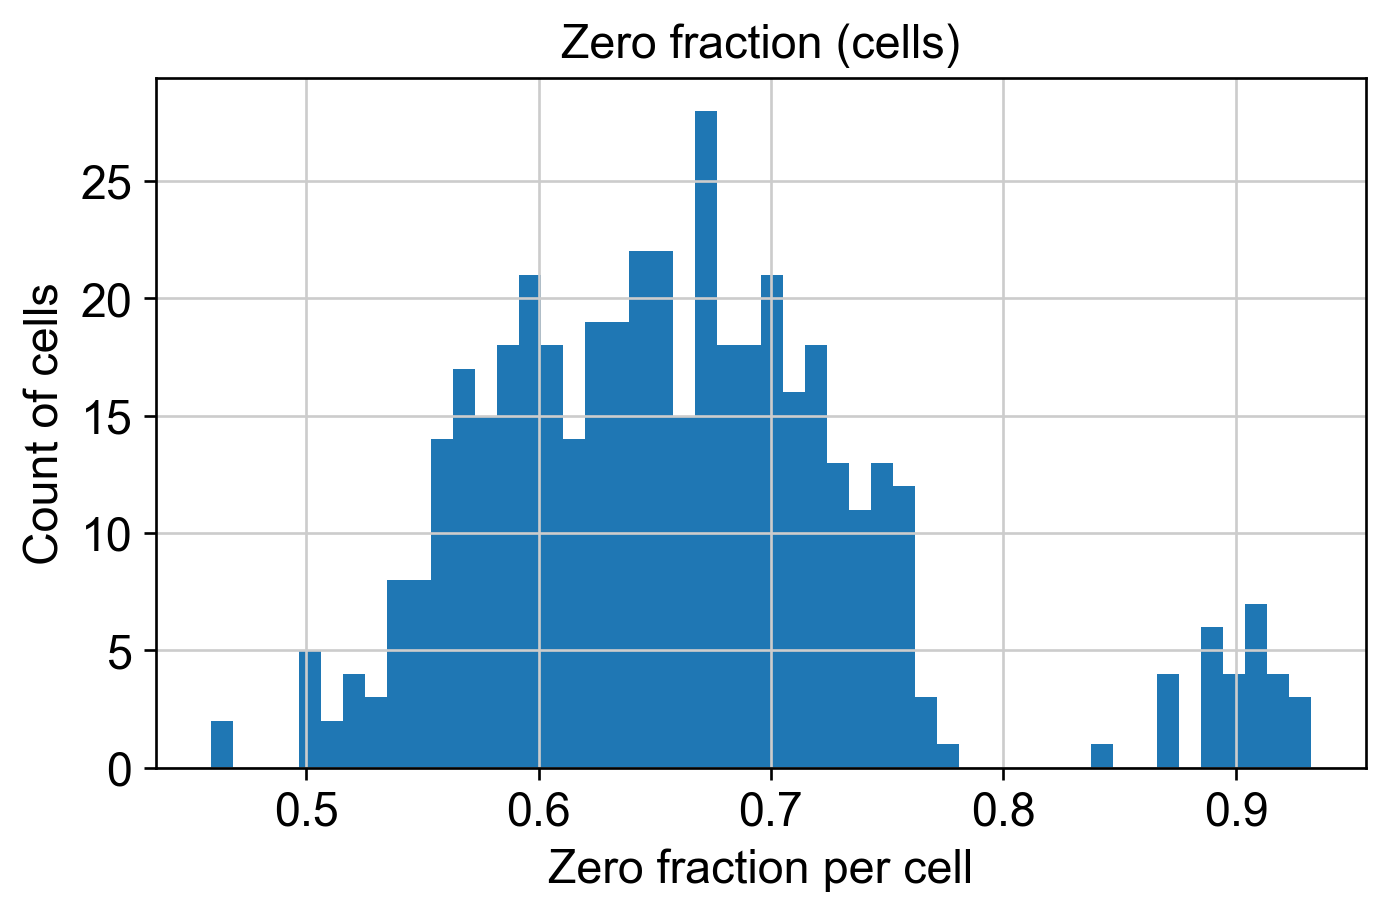

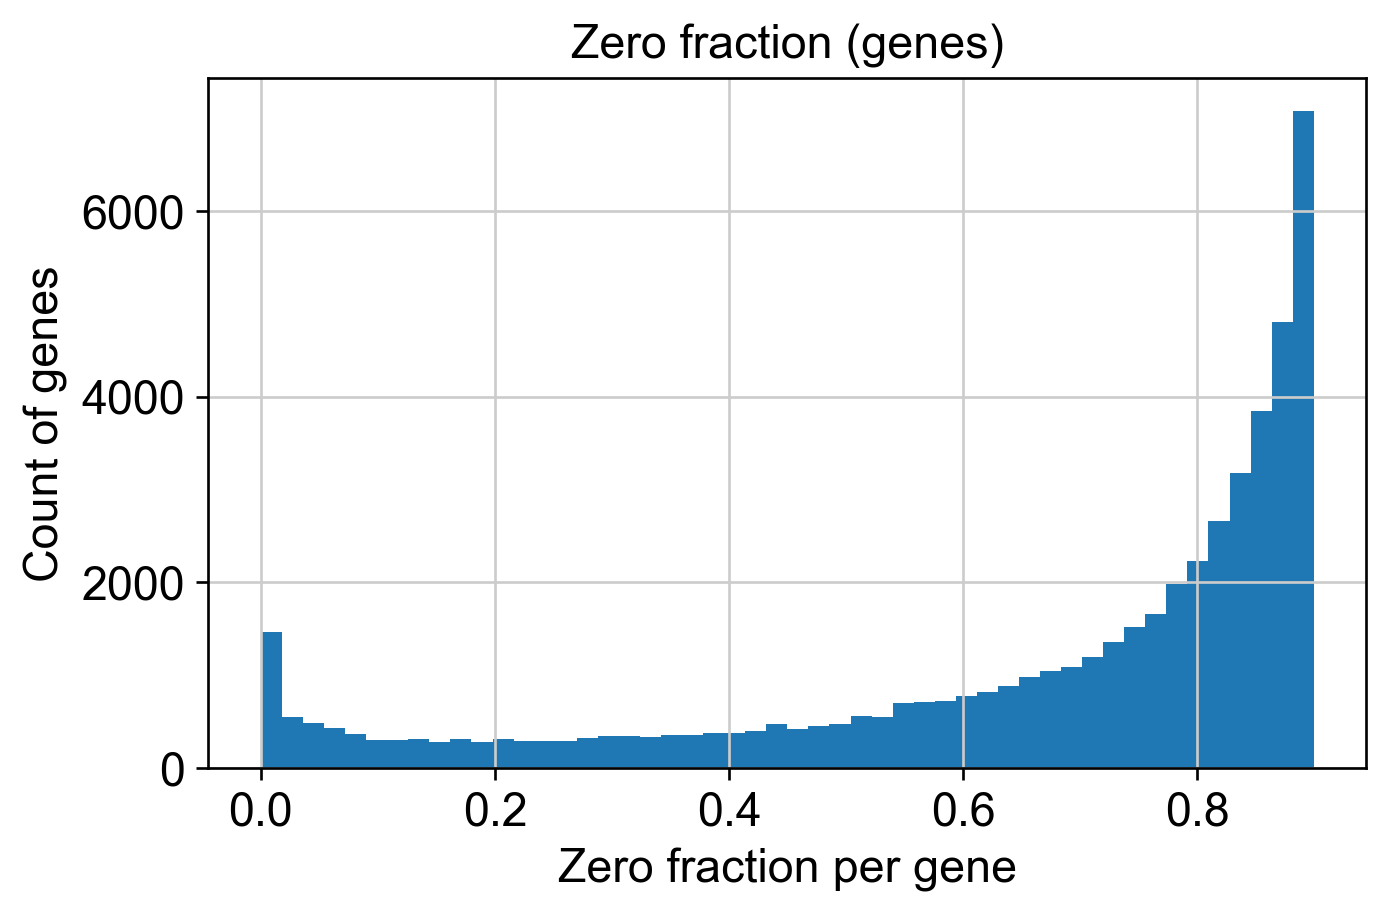

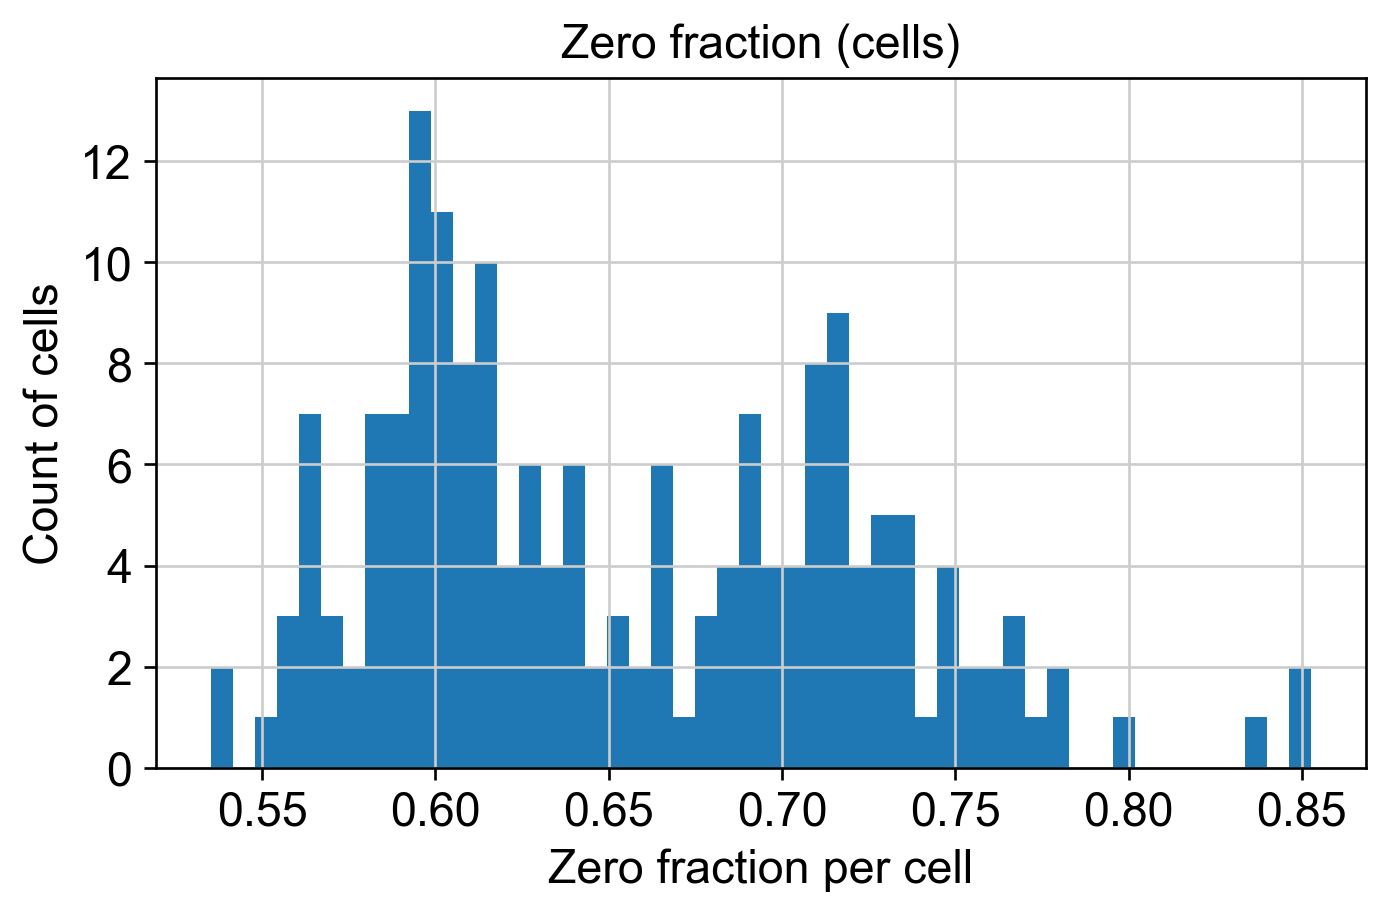

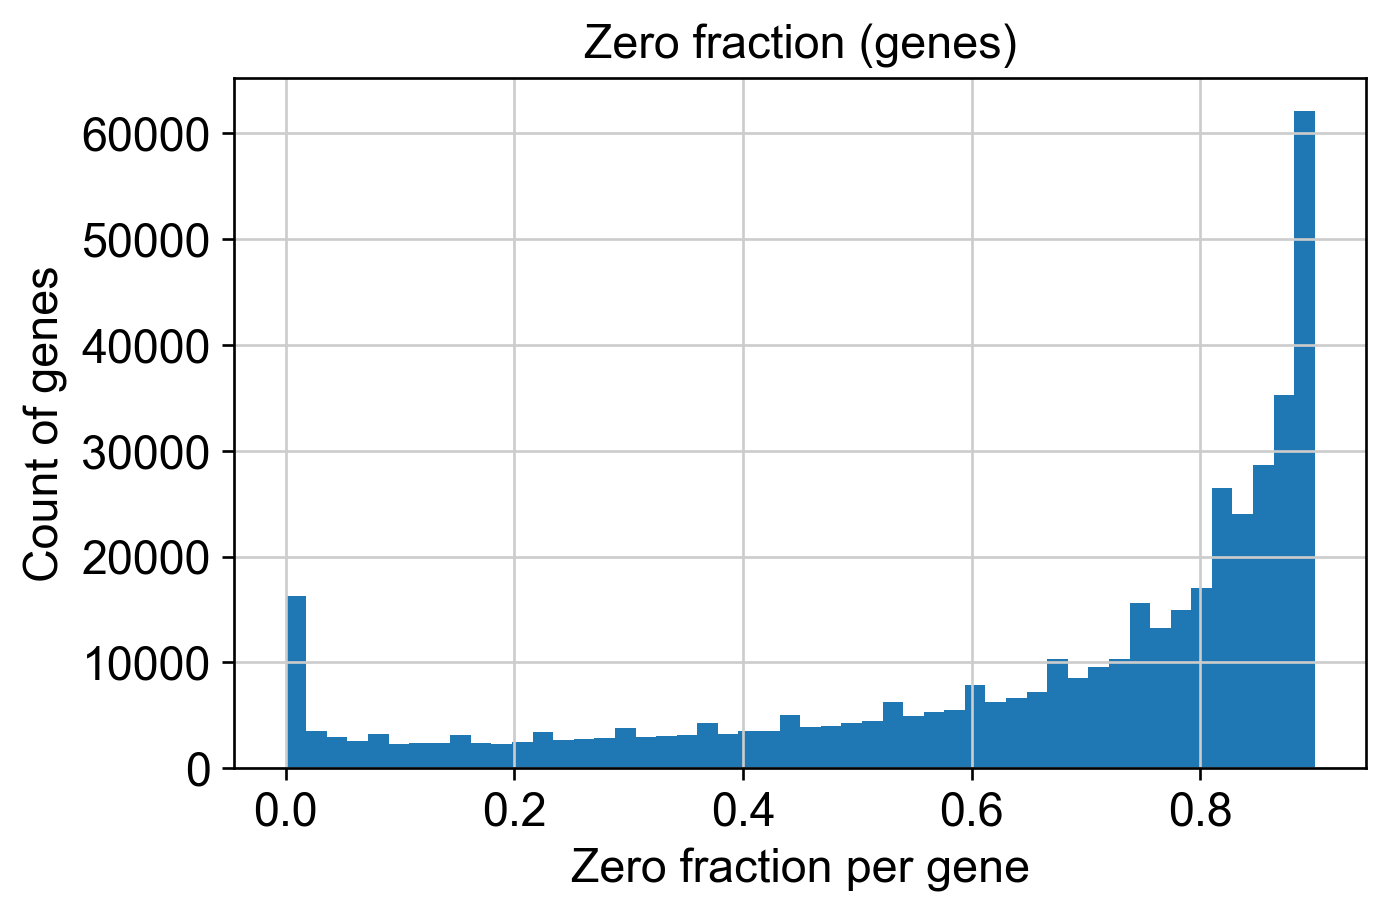

In [4]:
def zero_fraction_cell(X):
    if sps.issparse(X):
        zeros = X.shape[1] - (X != 0).sum(axis=1).A.ravel()
        return zeros / X.shape[1]
    else:
        return (X == 0).sum(axis=1) / X.shape[1]

def zero_fraction_gene(X):
    if sps.issparse(X):
        zeros = X.shape[0] - (X != 0).sum(axis=0).A.ravel()
        return zeros / X.shape[0]
    else:
        return (X == 0).sum(axis=0) / X.shape[0]

for adata_proc in [neu_adata_proc, cov_adata_proc]:
    adata_proc.obs['zero_frac_cell'] = zero_fraction_cell(adata_proc.X)
    adata_proc.var['zero_frac_gene'] = zero_fraction_gene(adata_proc.X)

    # Histograms
    fig, ax = plt.subplots()
    ax.hist(adata_proc.obs['zero_frac_cell'], bins=50)
    ax.set_xlabel('Zero fraction per cell')
    ax.set_ylabel('Count of cells')
    ax.set_title('Zero fraction (cells)')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(adata_proc.var['zero_frac_gene'], bins=50)
    ax.set_xlabel('Zero fraction per gene')
    ax.set_ylabel('Count of genes')
    ax.set_title('Zero fraction (genes)')
    plt.tight_layout()
    plt.show()


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs identified: 4000


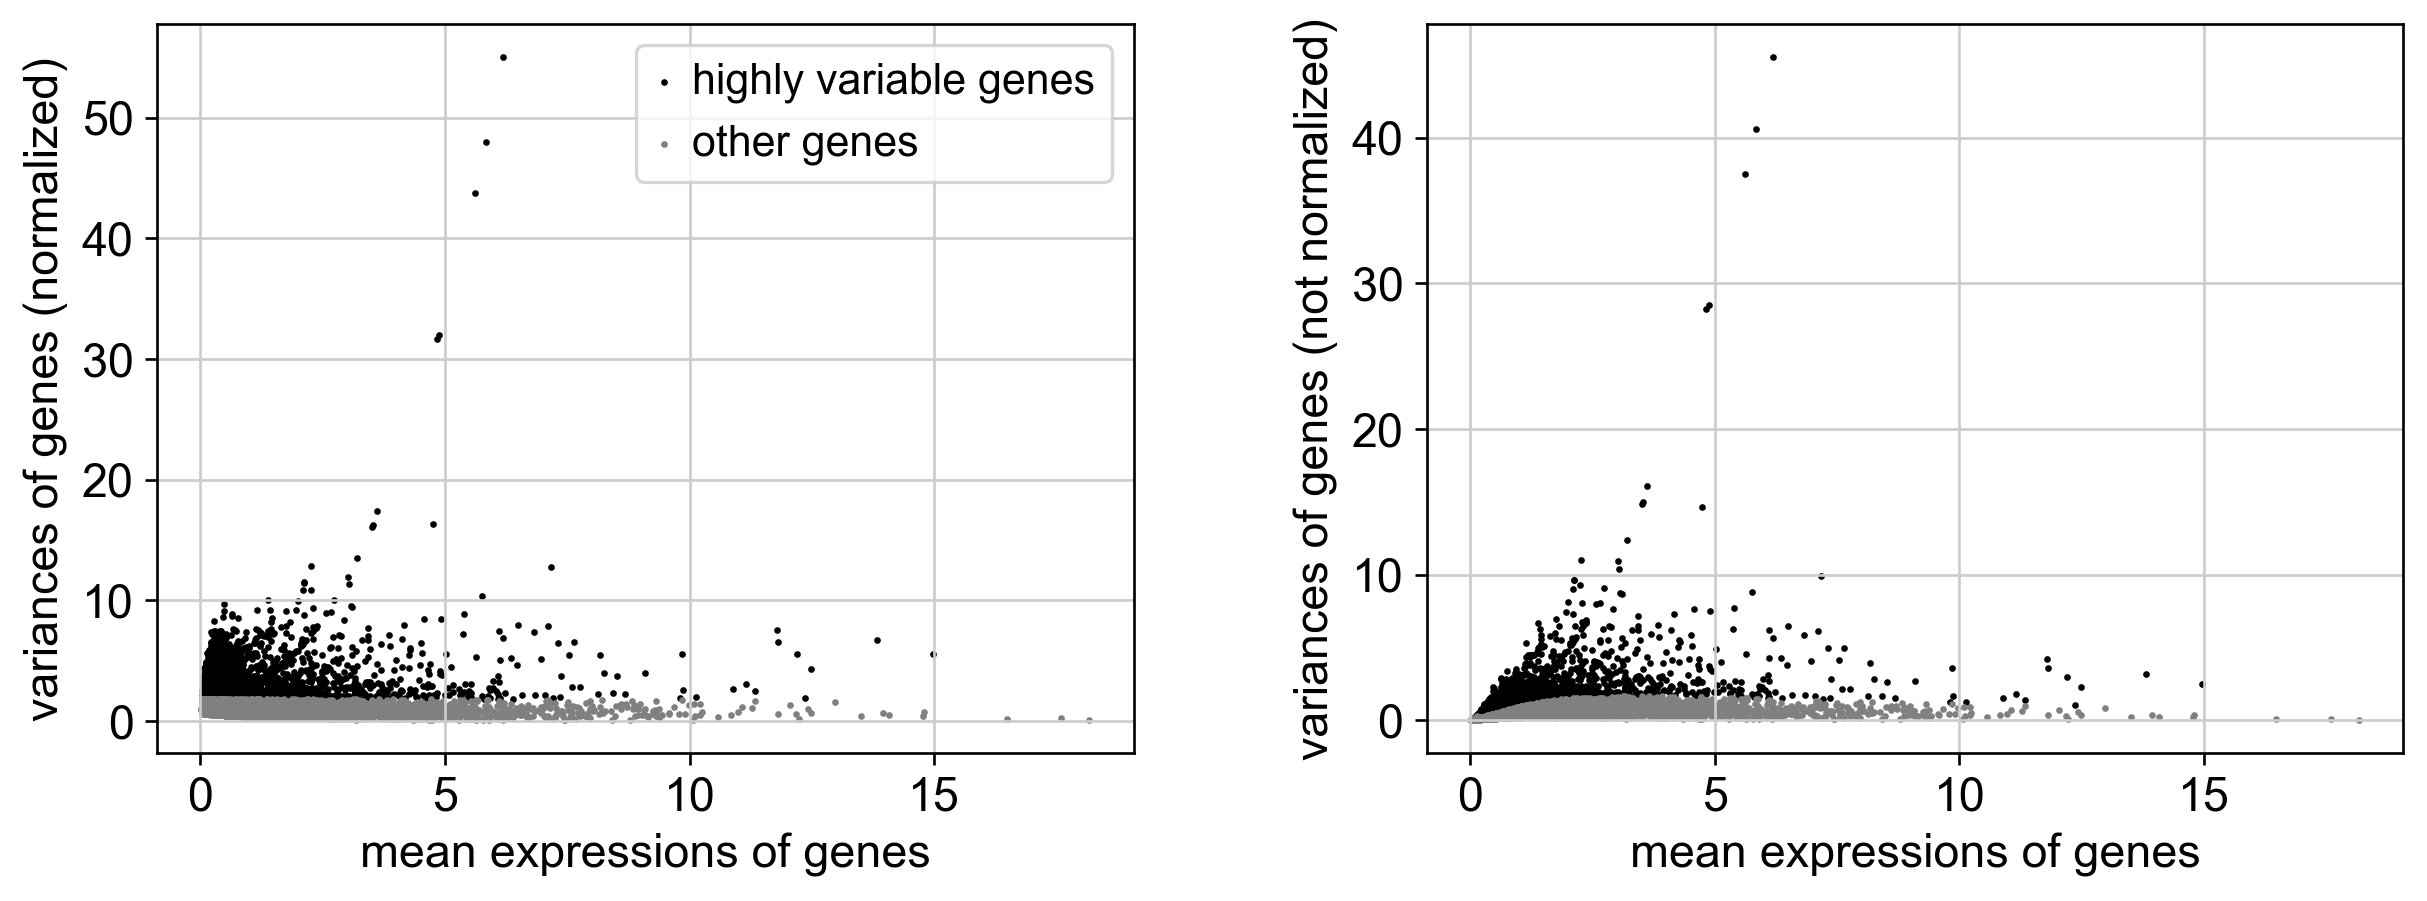

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs identified: 4000


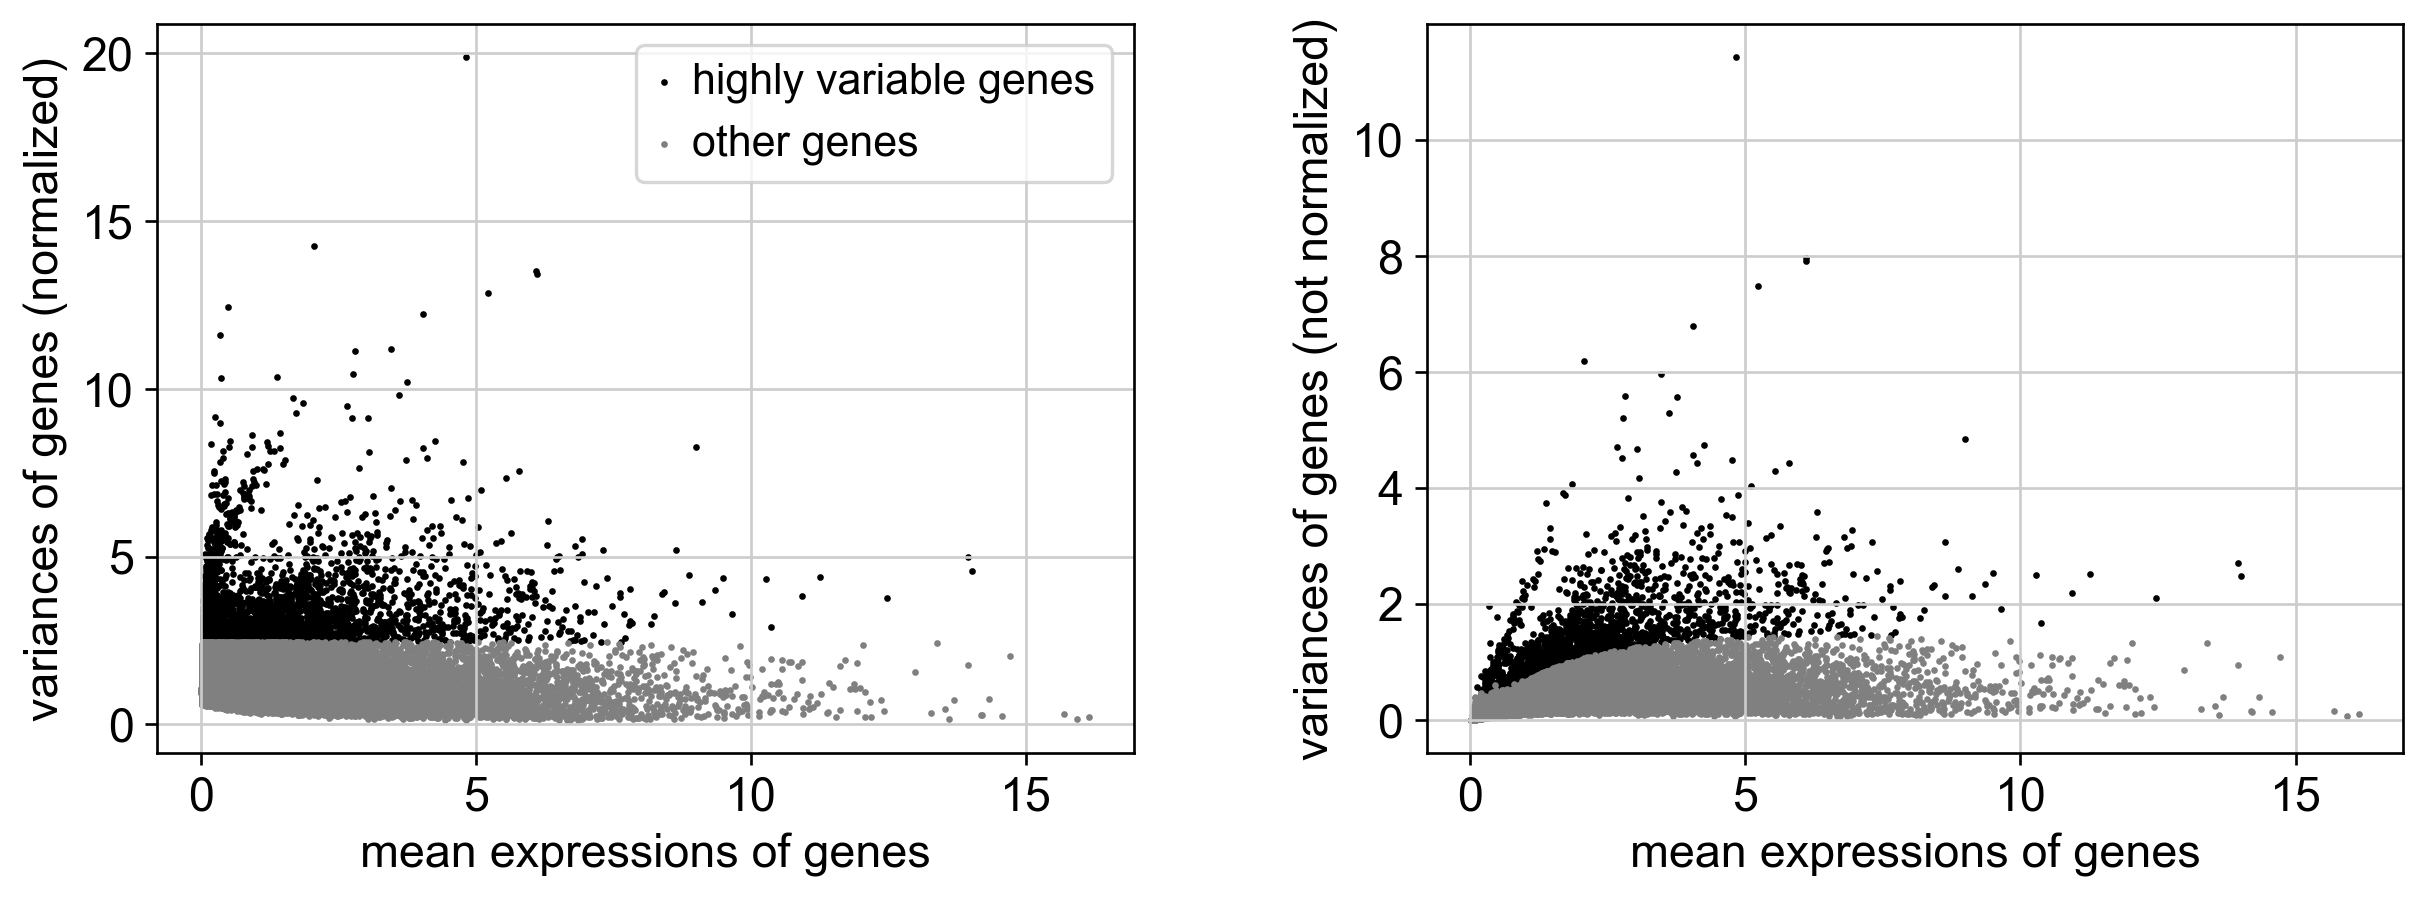

In [5]:
for adata_proc in [neu_adata_proc, cov_adata_proc]:
    '''
    seurat
    Uses Pearson residuals from a negative binomial model (rather than just variance).
    Accounts for:
        Mean-variance relationship (highly expressed genes naturally have higher variance, so that’s corrected).
        Sequencing depth differences between cells.
    models expected variance using a NB distribution, then looks for genes with residuals that are higher than expected.
    '''
    
    sc.pp.highly_variable_genes(adata_proc, flavor='seurat_v3', n_top_genes=4000, subset=False, inplace=True)
    print('HVGs identified:', adata_proc.var['highly_variable'].sum())

    try:
        sc.pl.highly_variable_genes(adata_proc, save=False)
        plt.show()
    except Exception as e:
        print('HVG plot skipped:', e) 

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs identified: 4000


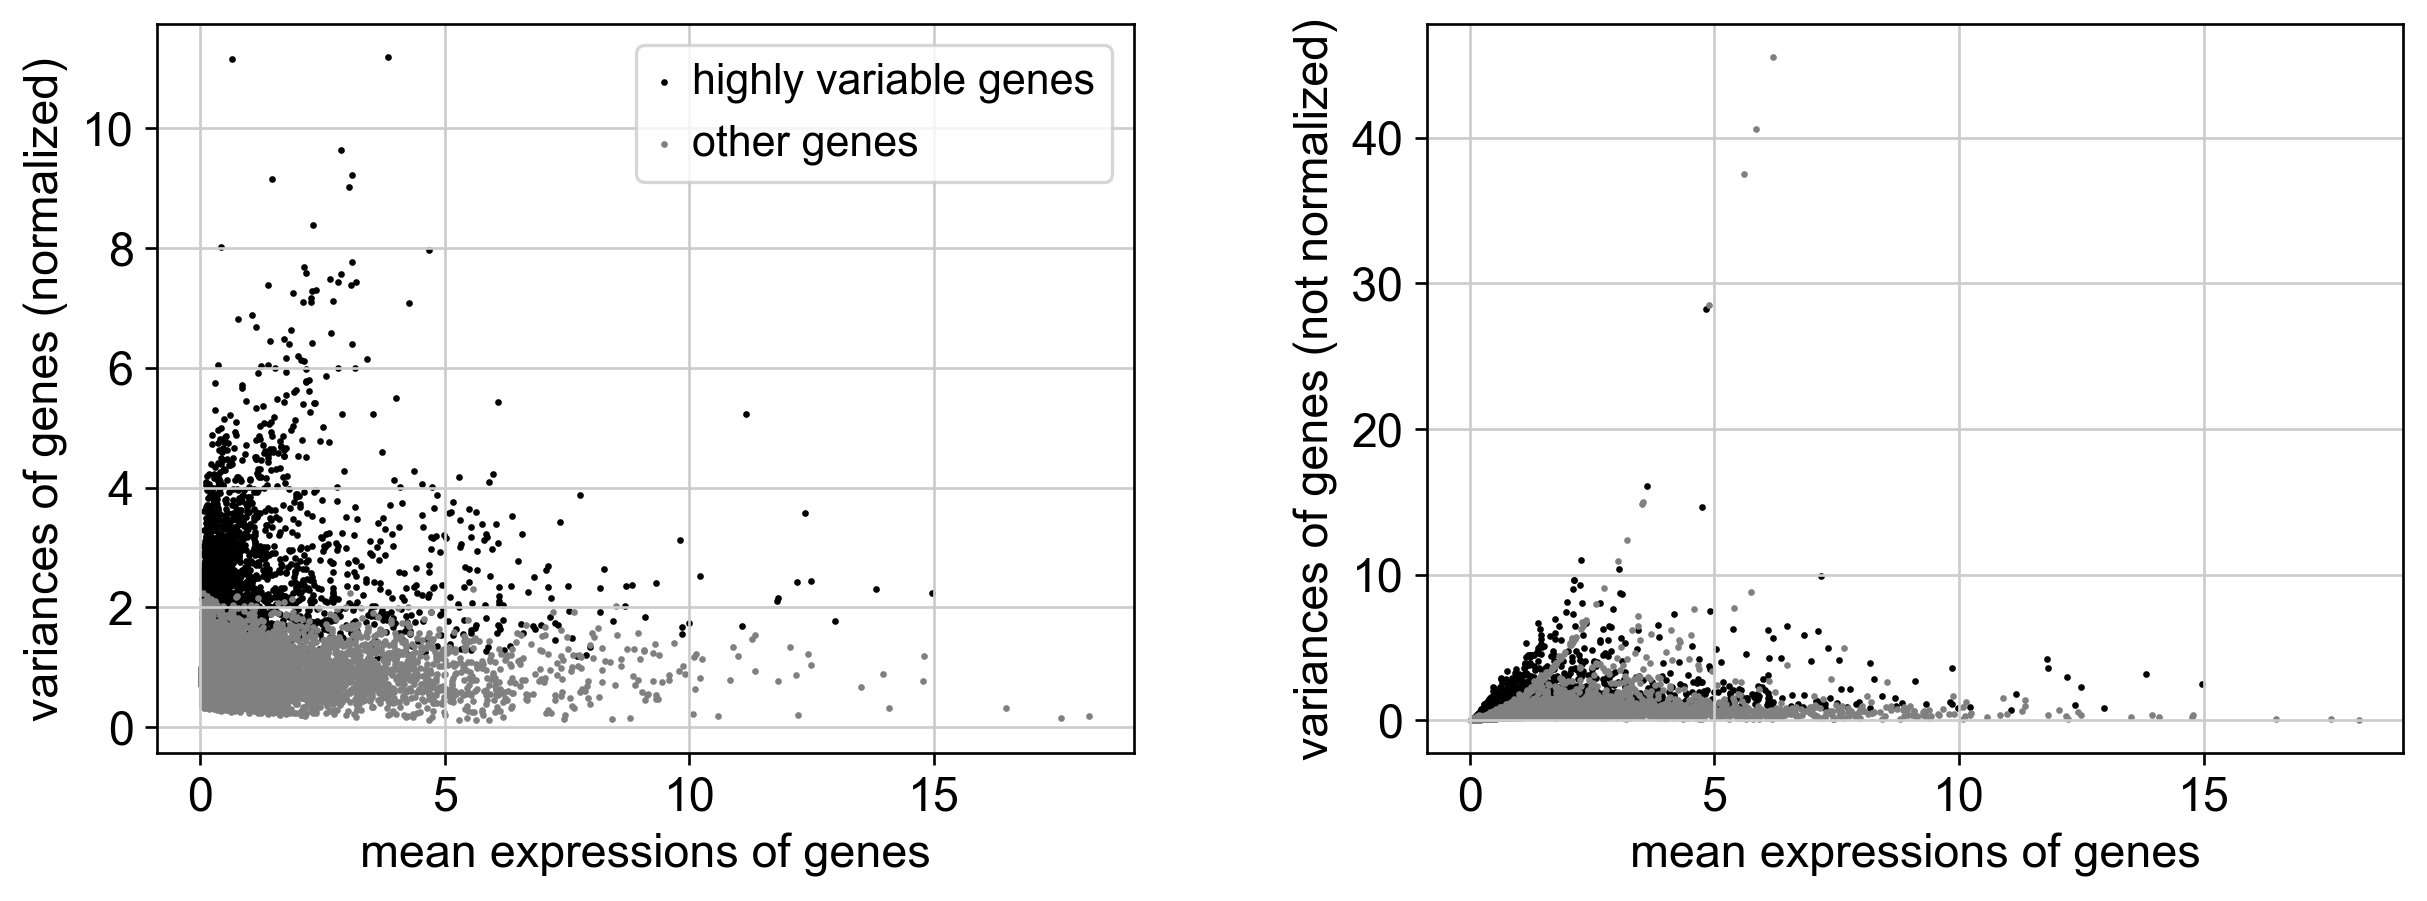

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVGs identified: 4000


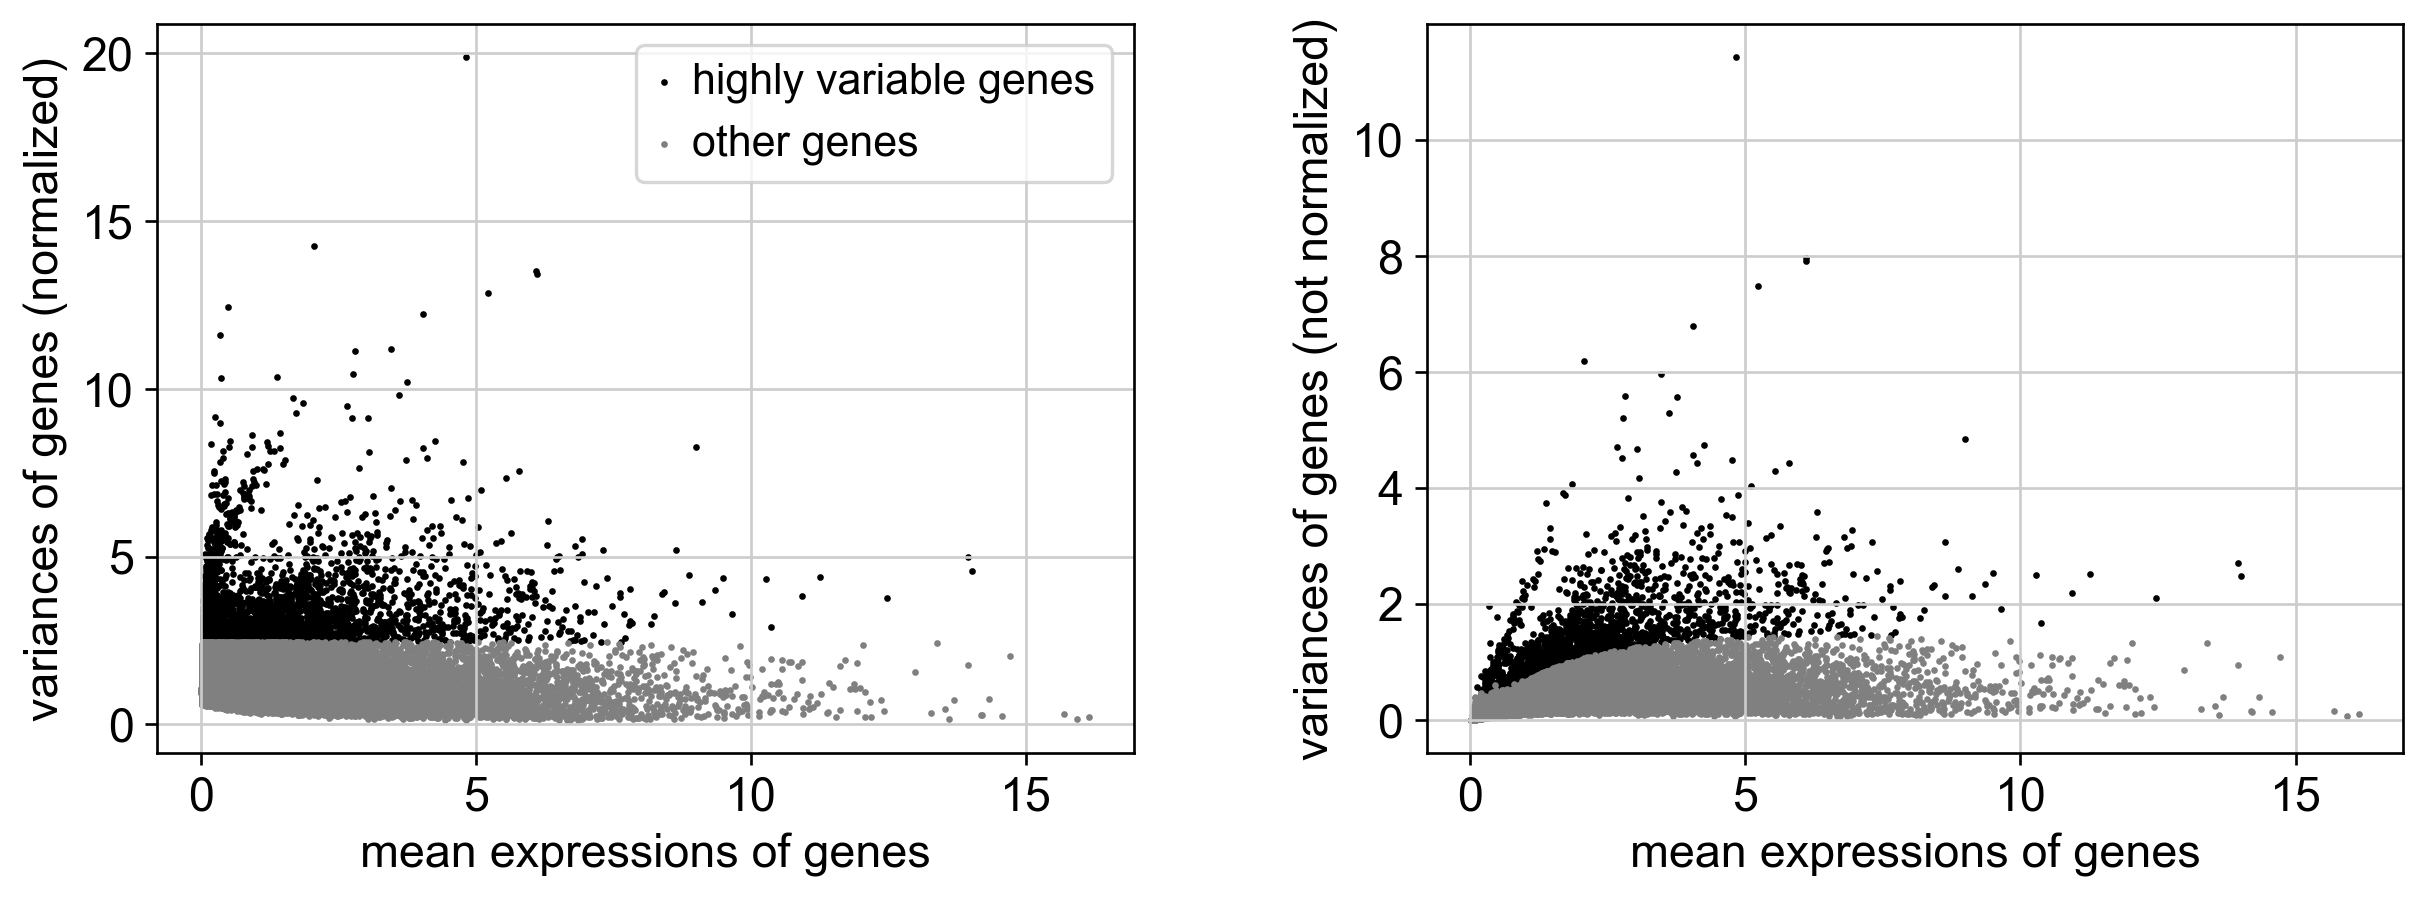

In [6]:
# with batch
for adata_proc in [neu_adata_proc, cov_adata_proc]:
    '''
    seurat
    Uses Pearson residuals from a negative binomial model (rather than just variance).
    Accounts for:
        Mean-variance relationship (highly expressed genes naturally have higher variance, so that’s corrected).
        Sequencing depth differences between cells.
    models expected variance using a NB distribution, then looks for genes with residuals that are higher than expected.
    '''
    
    sc.pp.highly_variable_genes(adata_proc, flavor='seurat_v3', n_top_genes=4000, subset=False, inplace=True, batch_key='BioProject')
    print('HVGs identified:', adata_proc.var['highly_variable'].sum())

    try:
        sc.pl.highly_variable_genes(adata_proc, save=False)
        plt.show()
    except Exception as e:
        print('HVG plot skipped:', e) 

## 3. Normalization & Dimensionality Reduction
- **What**: Perform normalization, log-transformation, select highly variable genes (HVG), and run PCA/UMAP.
- **Why**: To reduce noise and reveal latent structure.
- **Interpretation**: If groups separate strongly, it may reflect batch or biology.


In [7]:
import scanpy as sc
import matplotlib.pyplot as plt

def run_basic_eda(adata, n_top_genes=2000, n_pcs=30, random_state=42):
    # 1. Normalize library size
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    # 2. Log-transform
    sc.pp.log1p(adata)
    
    # 3. Identify highly variable genes
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=n_top_genes, subset=False, inplace=True)
    # sc.pp.highly_variable_genes(adata_proc, flavor='seurat_v3', n_top_genes=4000, subset=False, inplace=True, batch_key='BioProject')
    
    # 4. Scale and PCA
    # Each point: one sample
    # Clusters: similar samples (gene expression)
    # need to check the high PCs are batch effects or biological effects
    sc.pp.scale(adata, zero_center=True, max_value=10)
    sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack', random_state=random_state)
    
    # 5. Neighbors + UMAP
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(n_pcs, adata.obsm['X_pca'].shape[1]))
    sc.tl.umap(adata, random_state=random_state)
    
    # ---- Plots ----
    sc.pl.highly_variable_genes(adata)  # HVG diagnostic
    sc.pl.pca_variance_ratio(adata, log=True)  # explained variance
    sc.pl.pca_scatter(adata) if hasattr(sc.pl, "pca_scatter") else sc.pl.pca(adata)  
    sc.pl.umap(adata, title="UMAP (no batch label)")  
    
    return adata


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


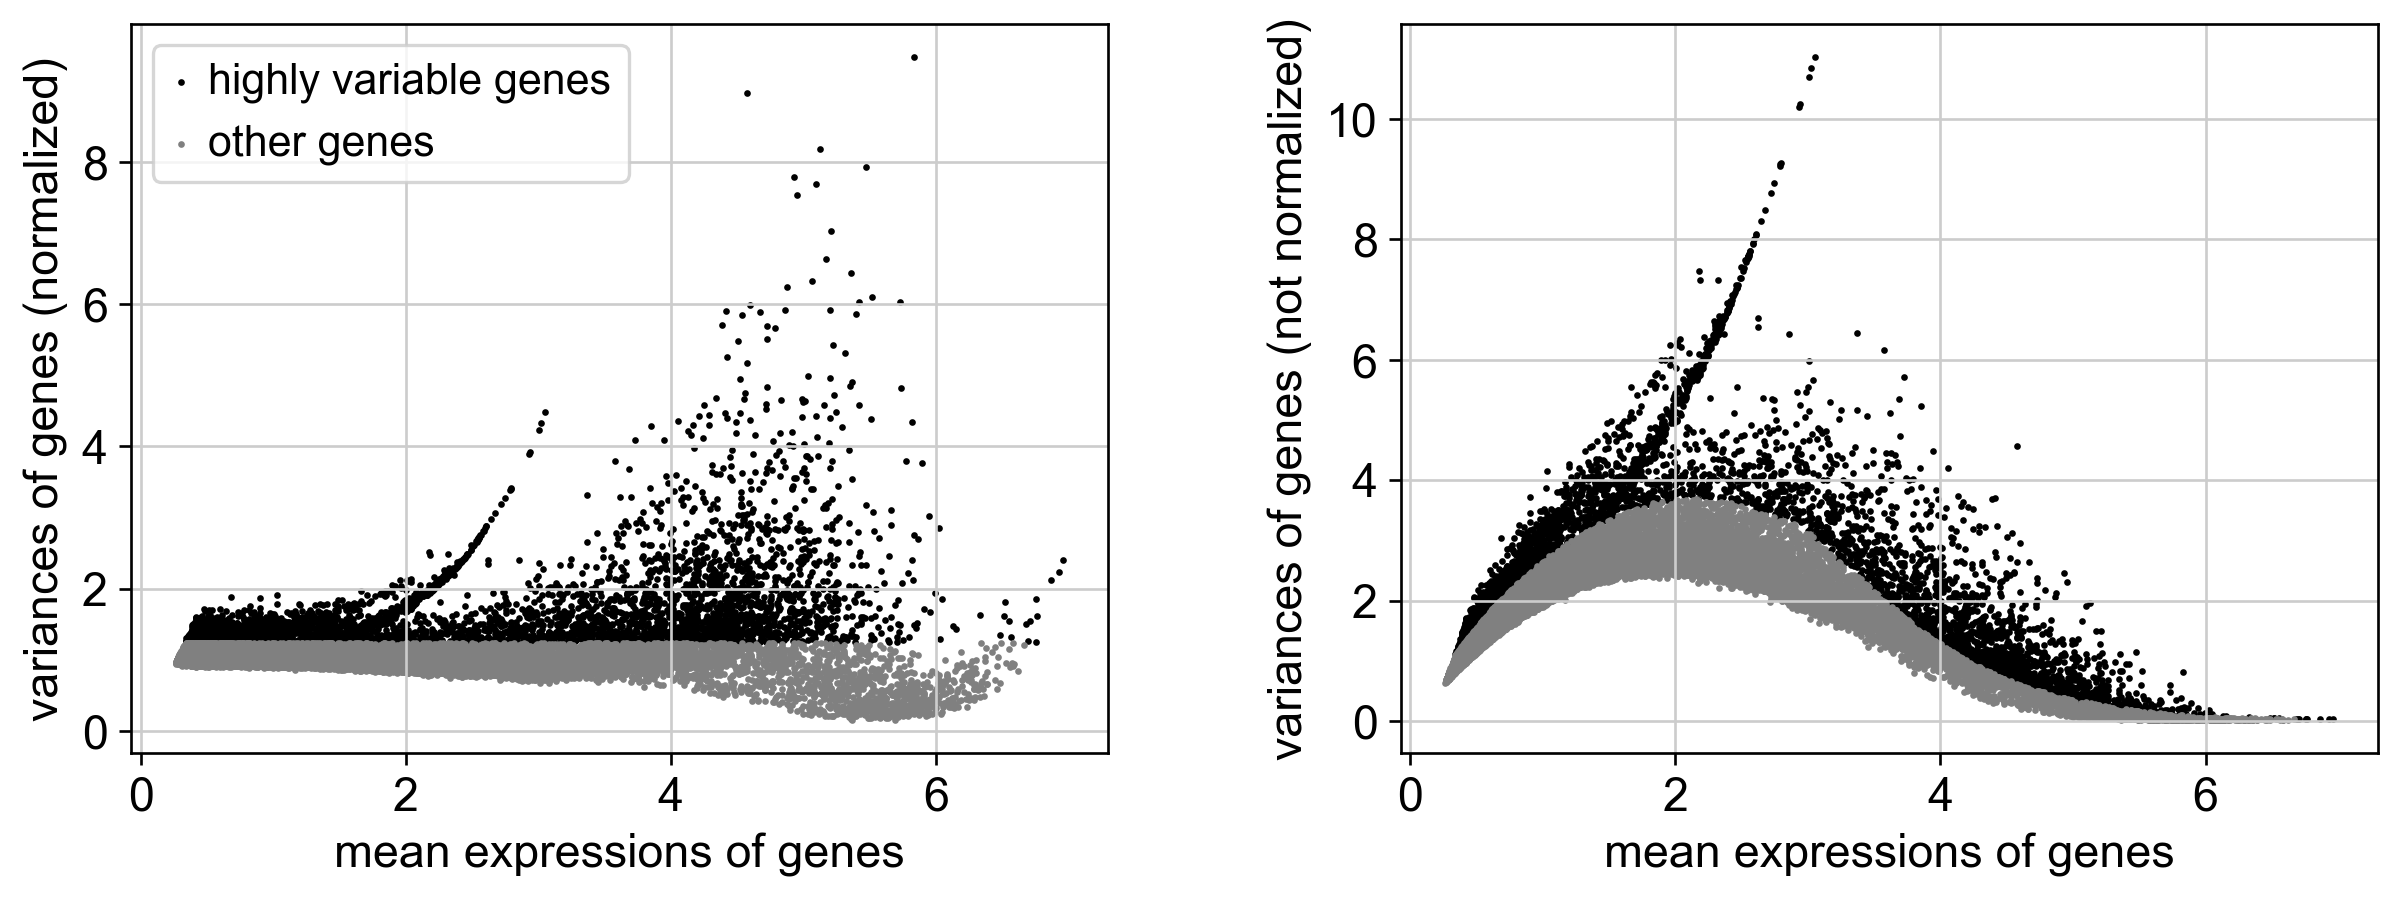

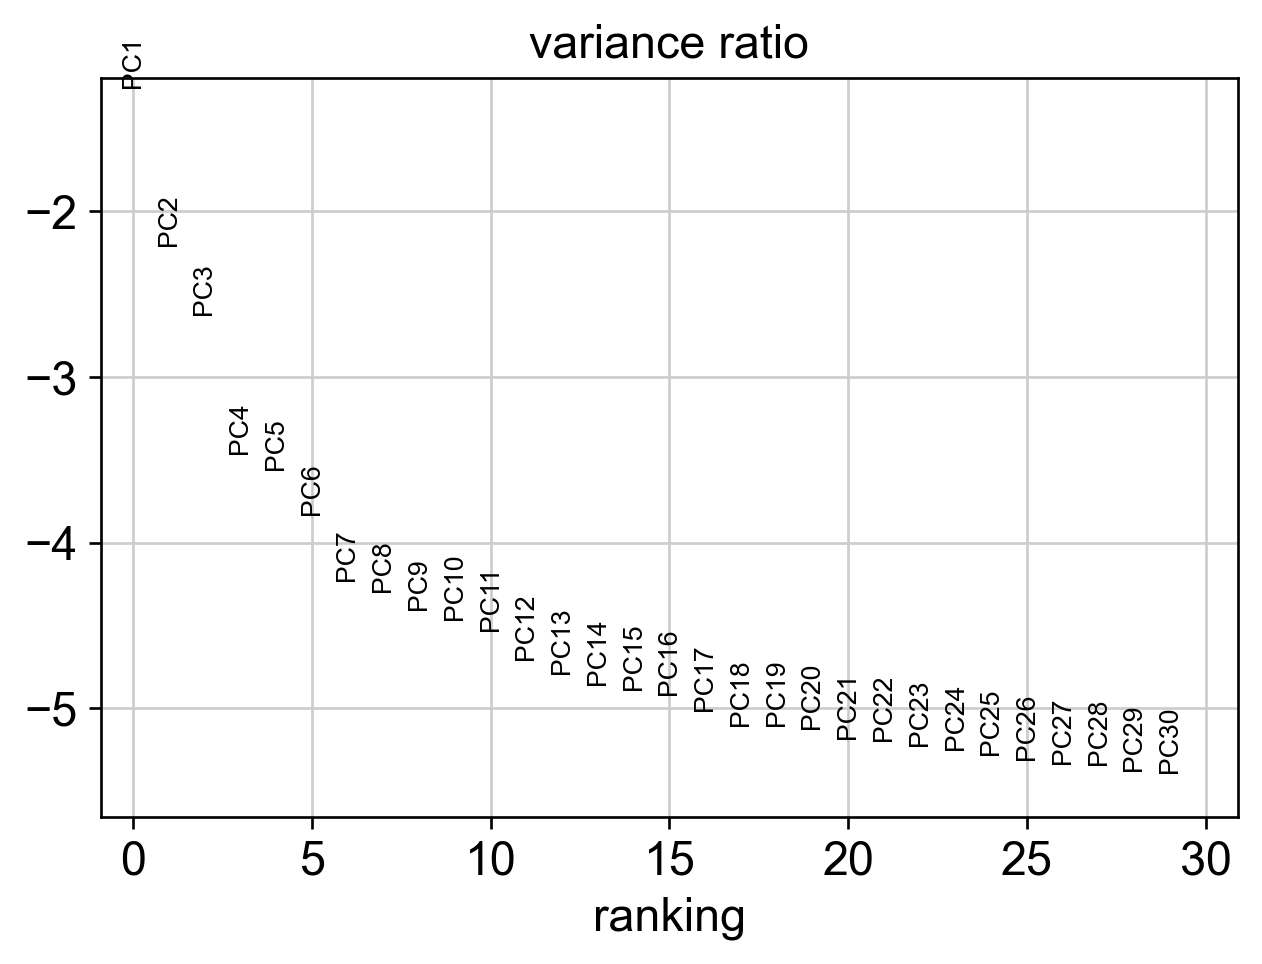

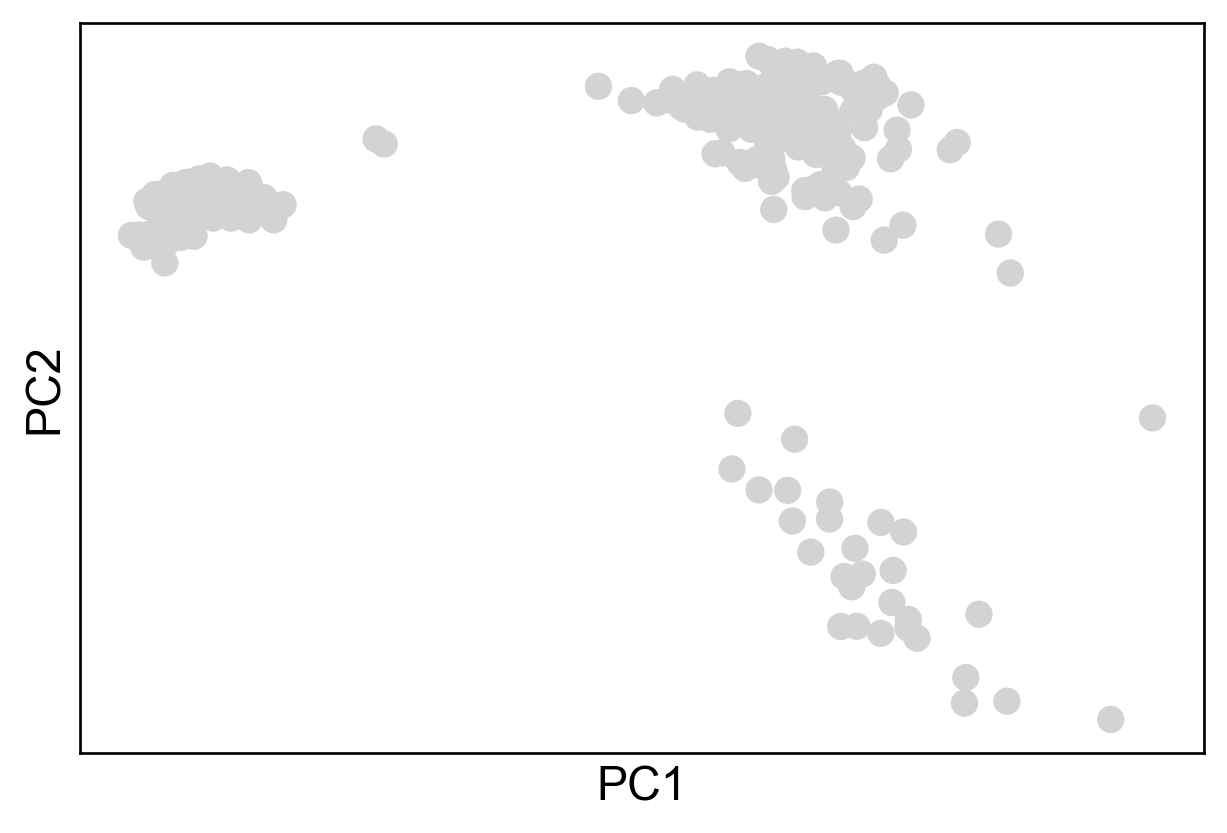

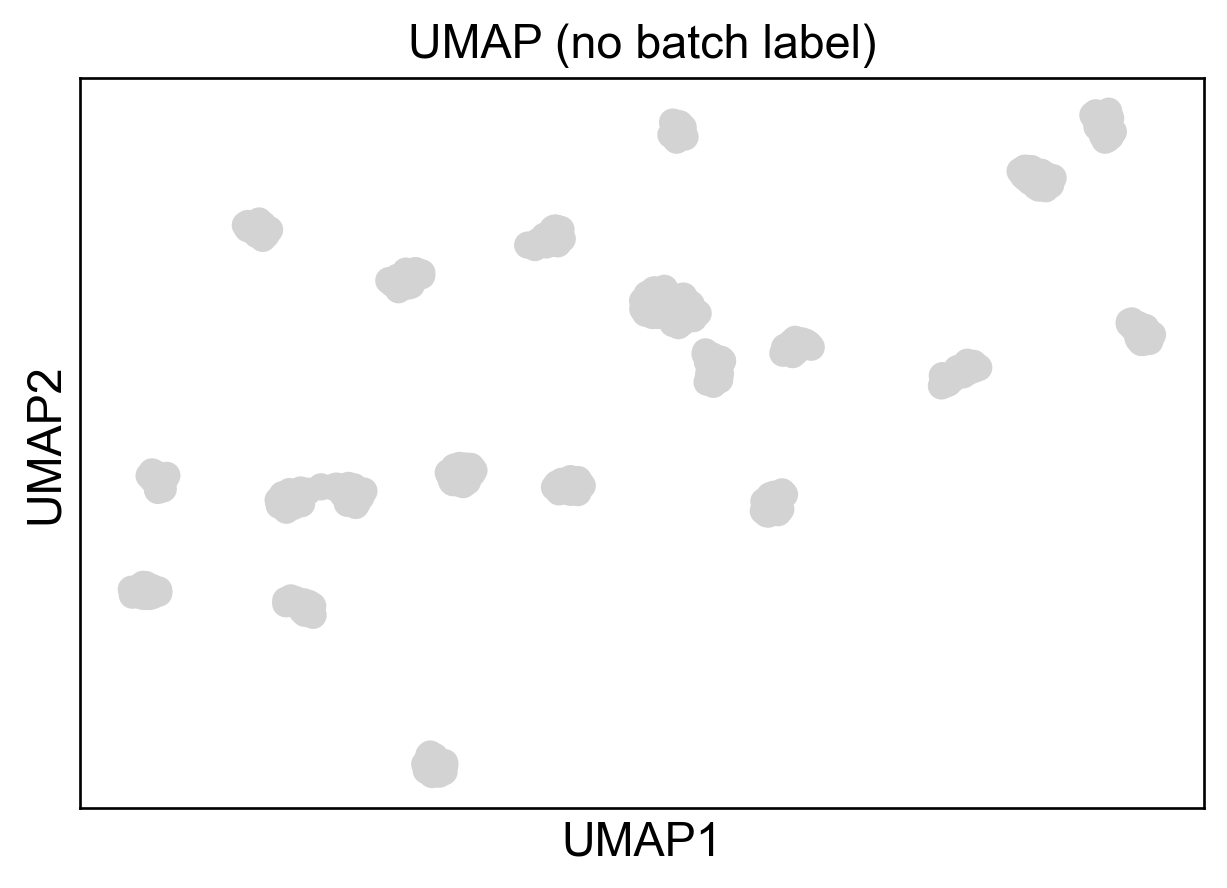

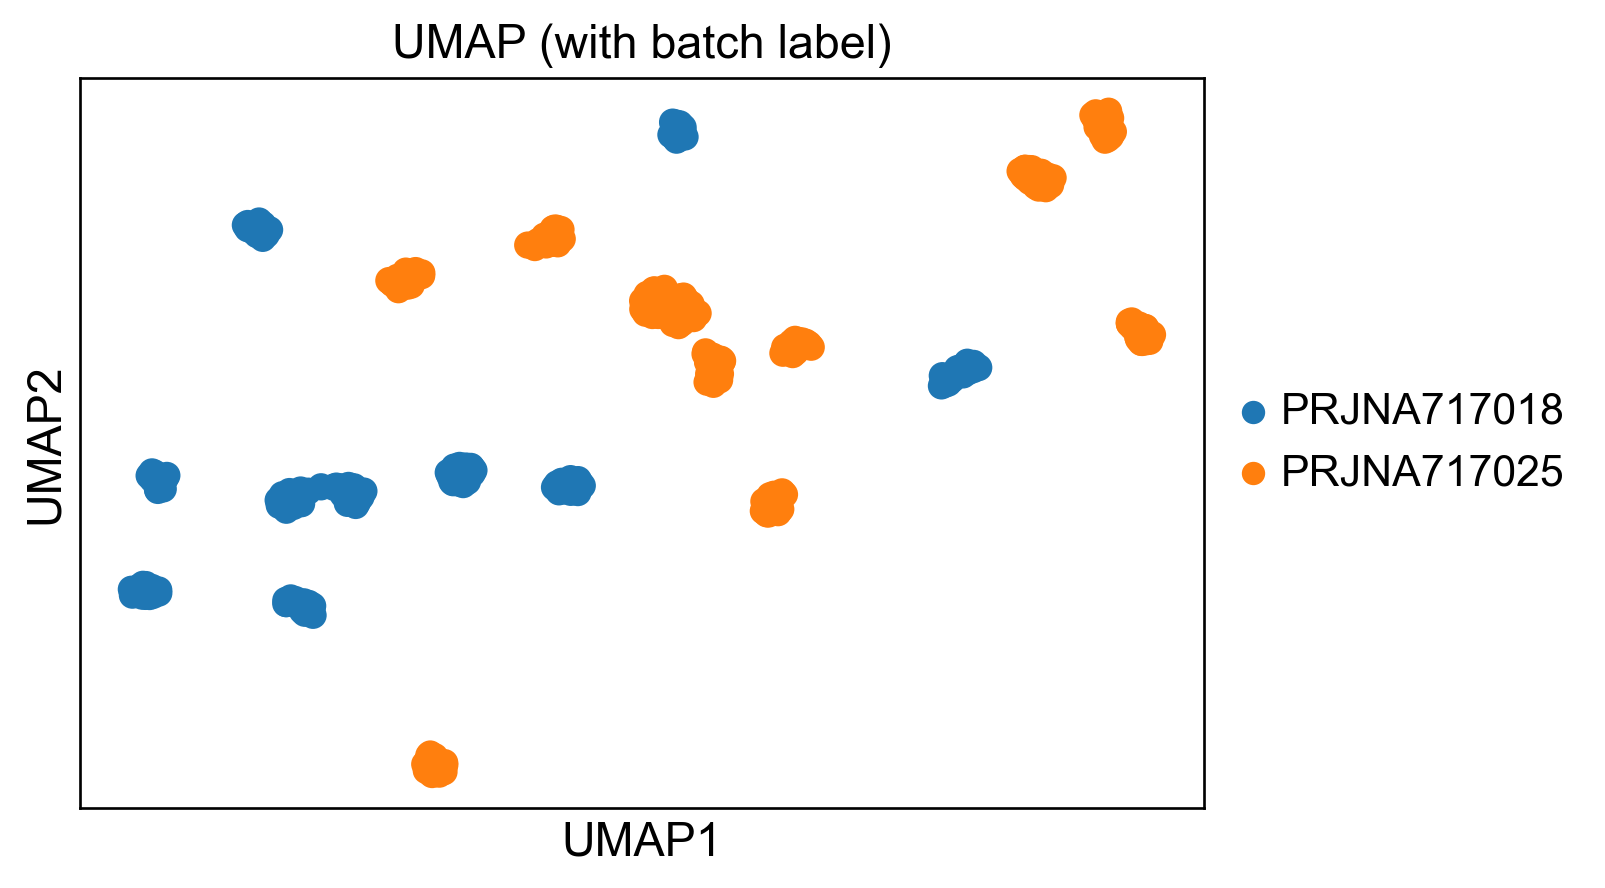

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


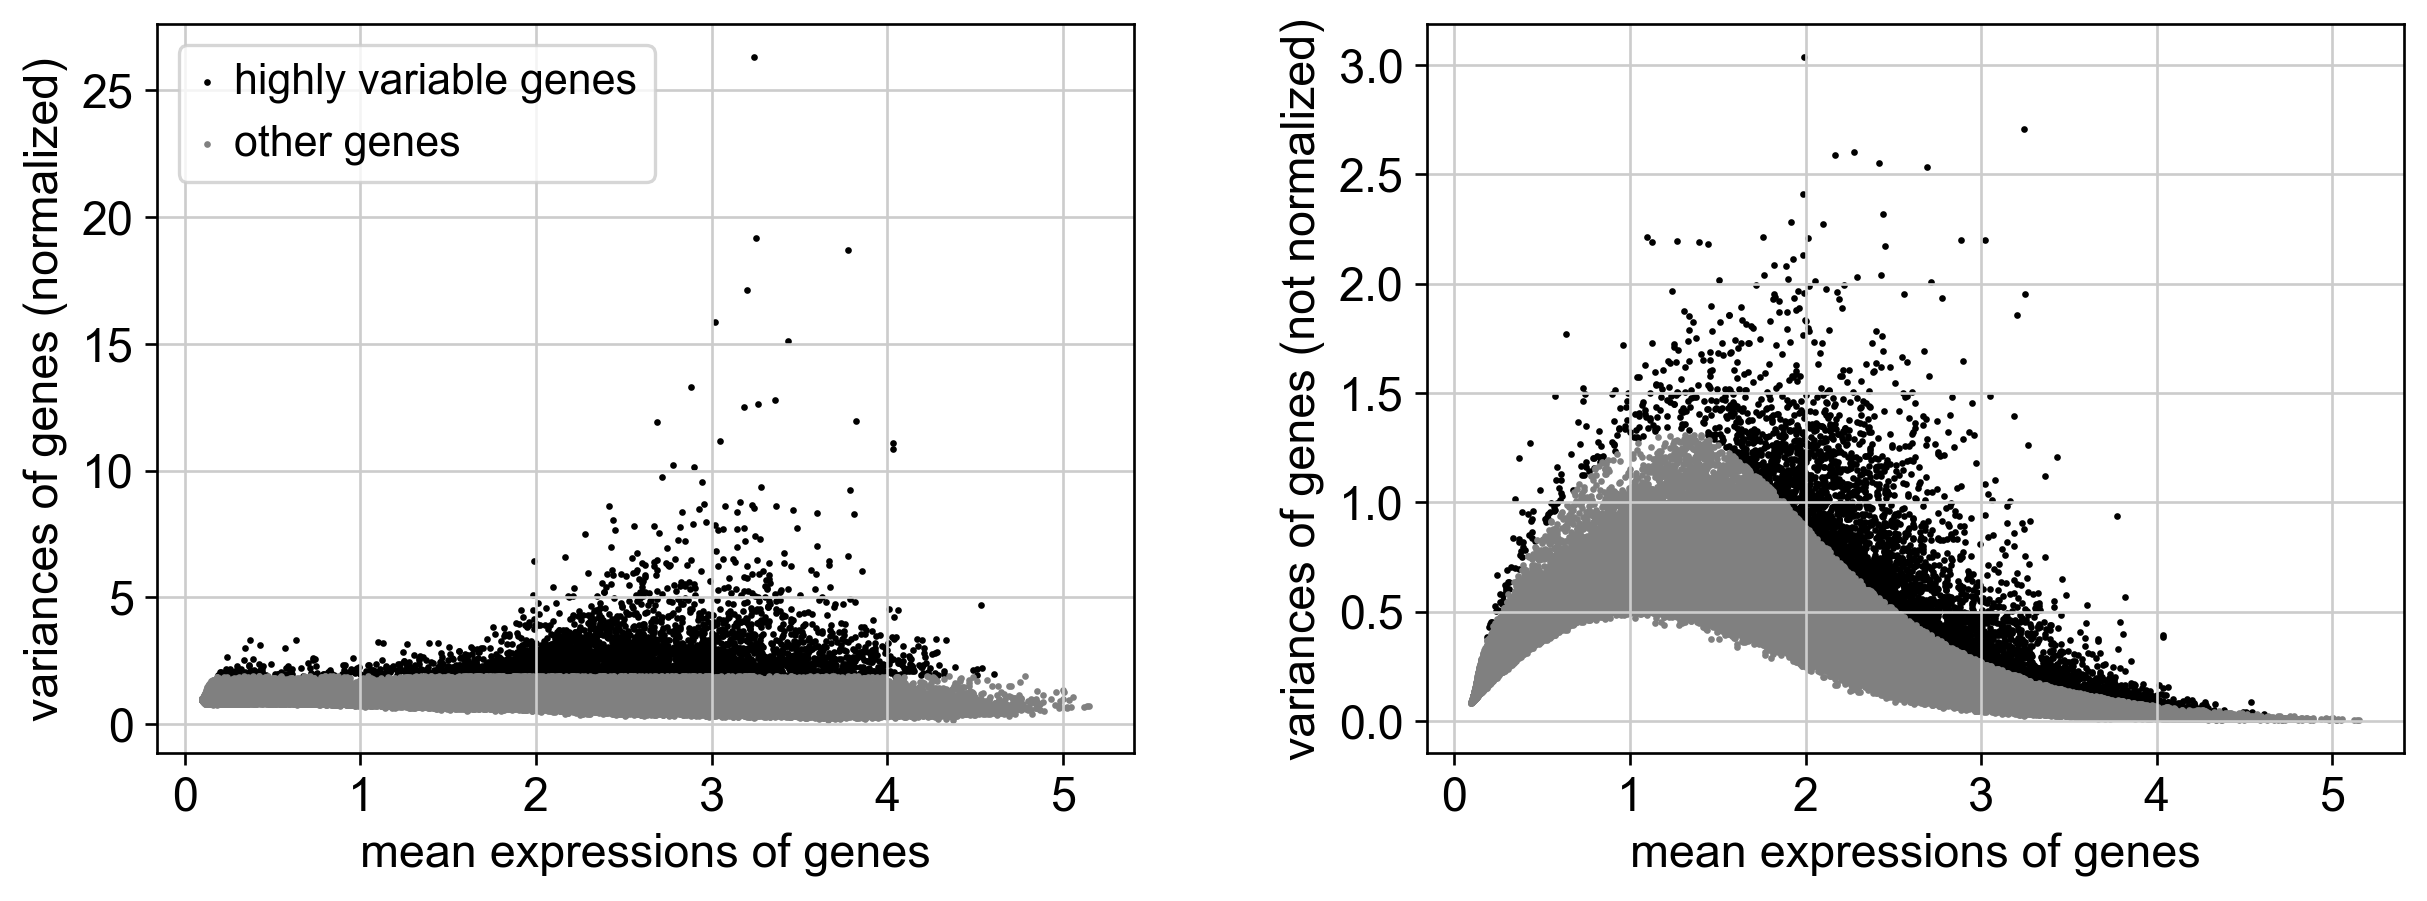

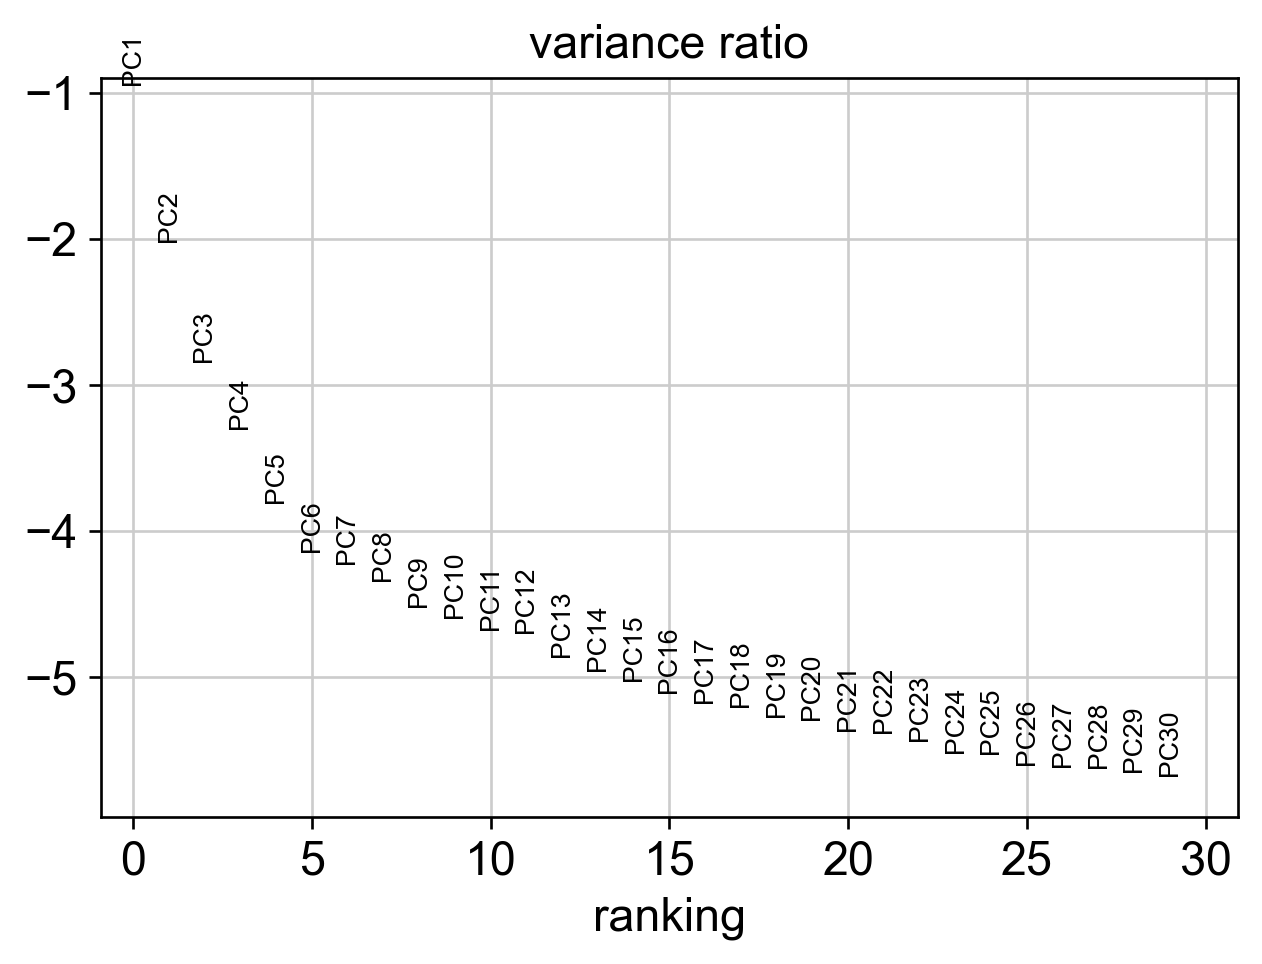

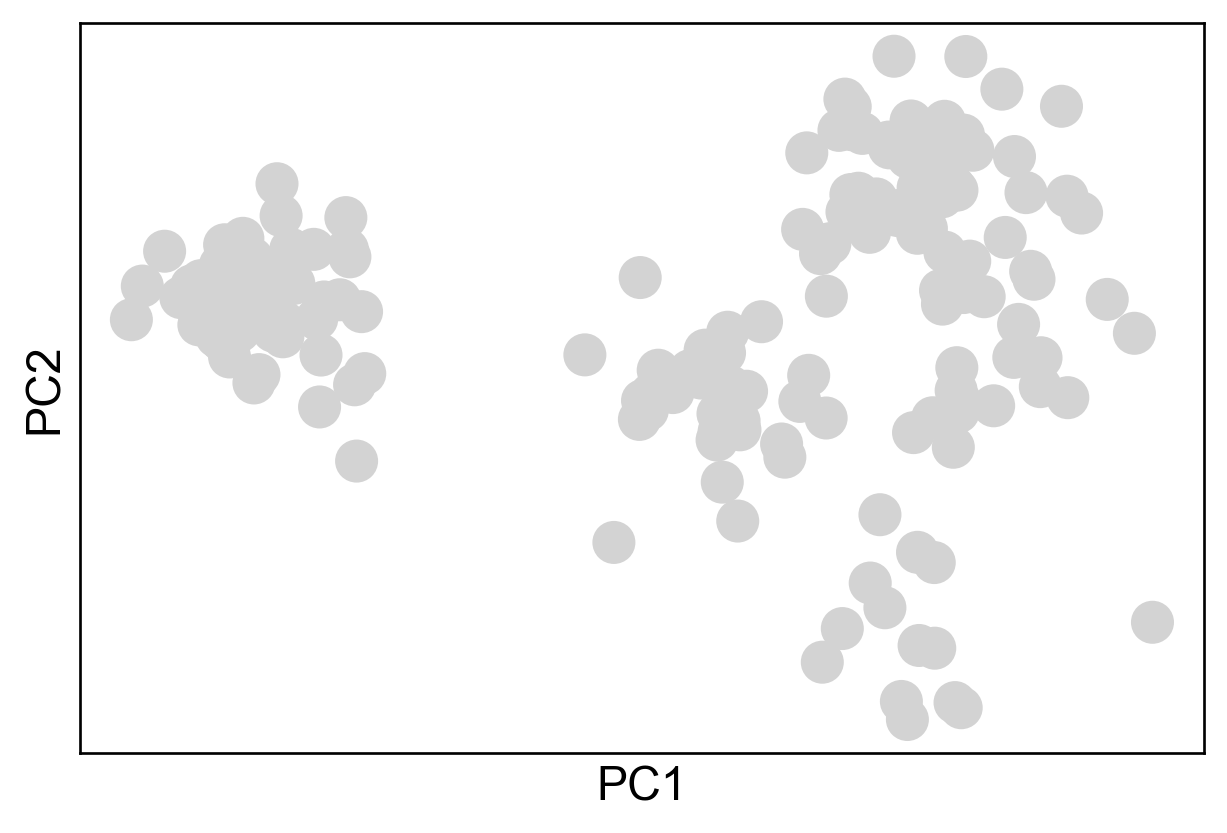

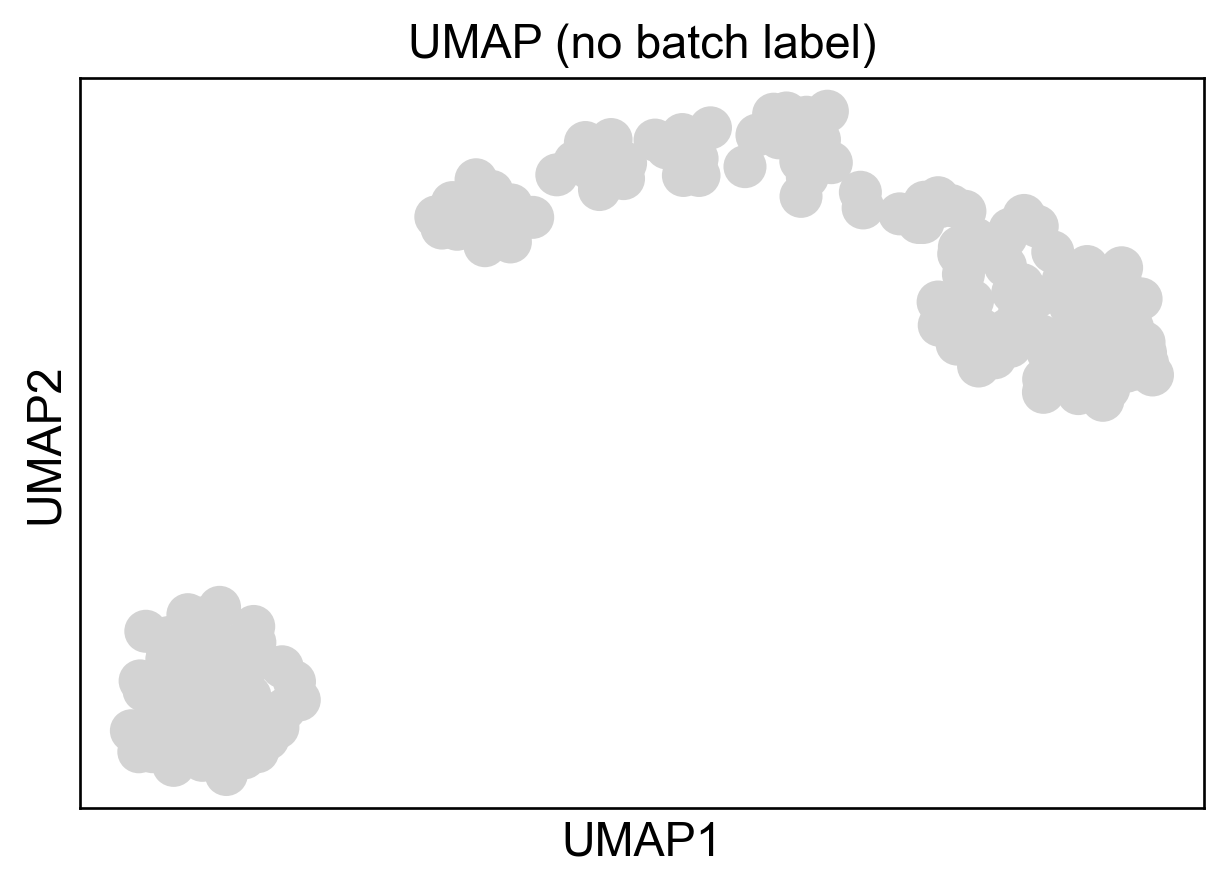

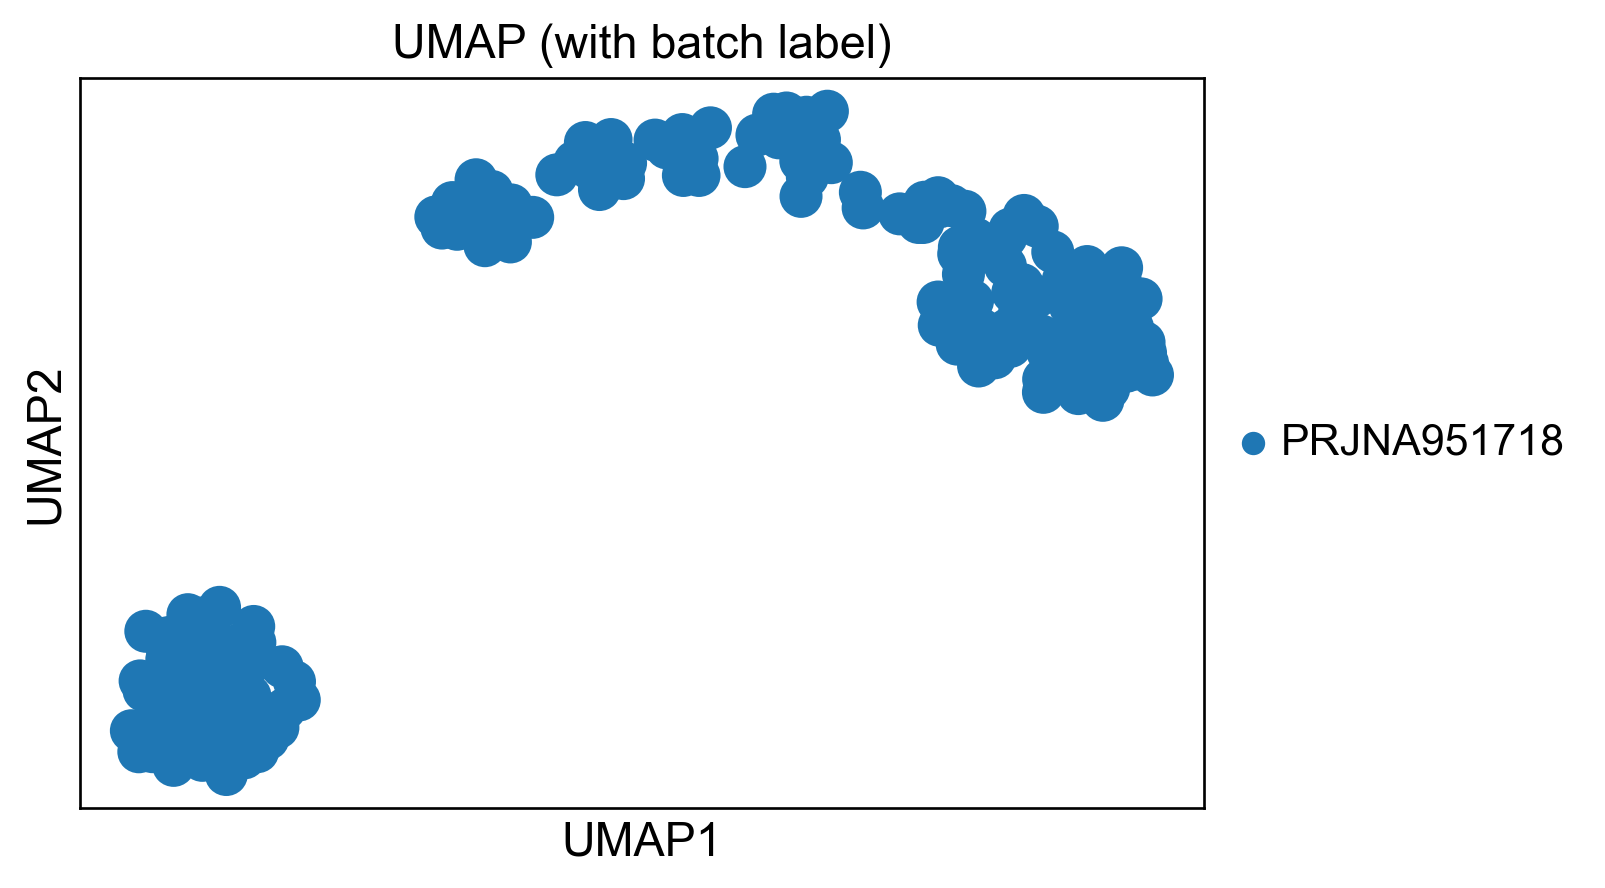

In [ ]:
for adata_proc in [neu_adata_proc, cov_adata_proc]:
    adata_proc = run_basic_eda(adata_proc, n_top_genes=4000, n_pcs=30, random_state=42)
    sc.pl.umap(adata_proc, color='BioProject', title="UMAP (with batch label)")
    plt.show()
    
# About the result: BipProject can't be used for batch label because the levle is only 1

## 4. Candidate Batch Scan
- **What**: Identify candidate batch-like variables in `.obs` and create a pseudo-batch via clustering.
- **Metrics**: Silhouette (↓ is better), Mixing Entropy (↑ is better), Predictability (↓ is better), iLISI (↑ is better), kBET (↑ is better).
- **Interpretation**: High separation + low mixing metrics suggest batch effects.


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr

# -------------------------------
# Config
# -------------------------------
N_PCS = 30
RANDOM_STATE = 42
POINT_SIZE = 8
LEGEND_FONTSIZE = 6
TOPK_K = 8

# Candidate sets (edit as you like)
BATCH_CANDIDATES = [
    "Center_name","Sequencer","Lab_library_preparation_kit","Lab_RNA_extraction_protocol",
    "Lab_library_selection","Lab_library_source","Assay_type","Lab_library_layout","Sample_type",
    "Experiment","SRA_study","BioProject","GEO_Accession_exp","source_name","Consent",
    "Release_date","create_date","version","BioSample","Sample_name"
]
GROUP_CANDIDATES = [
    "diagnosis","treatment","cohort","vaccine","naat_result","timepoint",
    "status","disease","condition","group","Participant_number","sex","age"
]
NUMERIC_QC_CANDIDATES = [
    "total_counts_before_preprocessing","total_counts_after_trimming",
    "total_counts_after_preprocessing","total_count_ratio__after_to_before","total_count",
    "QC_mapping_ratio_bacterial","QC_mapping_ratio_viral","QC_mapping_ratio_miRNA","QC_mapping_ratio_sncRNA"
]

# -------------------------------
# Utilities
# -------------------------------
def ensure_pca_umap(adata, n_pcs=N_PCS, n_neighbors=15, random_state=RANDOM_STATE):
    """Ensure PCA and UMAP exist (uses HVGs if available)."""
    # PCA
    need_pca = ("X_pca" not in adata.obsm) or (adata.obsm["X_pca"].shape[1] < n_pcs)
    if need_pca:
        if "highly_variable" in adata.var:
            sc.pp.scale(adata, zero_center=True, max_value=10)
            sc.tl.pca(adata, n_comps=n_pcs, use_highly_variable=True, svd_solver="arpack", random_state=random_state)
        else:
            sc.pp.scale(adata, zero_center=True, max_value=10)
            sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack", random_state=random_state)
    # Neighbors + UMAP
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=min(n_pcs, adata.obsm["X_pca"].shape[1]))
    if "X_umap" not in adata.obsm:
        sc.tl.umap(adata, random_state=random_state)

def topk_or_other(adata, key, k=TOPK_K, other_name="Other"):
    """Return name of a new obs column collapsing levels to top-k + Other."""
    col = f"{key}_top{k}"
    vc = adata.obs[key].astype(str).value_counts()
    keep = set(vc.head(k).index)
    adata.obs[col] = adata.obs[key].astype(str).where(adata.obs[key].astype(str).isin(keep), other_name)
    return col

# -------------------------------
# 1) ANOVA on PCs (categorical label)
# -------------------------------
def anova_per_pc(adata, label_key, n_pcs=N_PCS):
    """Return per-PC p-values (array of length n_pcs) for association with a categorical label."""
    pcs = adata.obsm["X_pca"][:, :n_pcs]
    y = pd.Categorical(adata.obs[label_key]).codes
    # f_classif treats each PC as a feature; returns p-values per feature
    _, pvals = f_classif(pcs, y)
    # Protect against zeros
    pvals = np.maximum(pvals, 1e-300)
    return pvals

def plot_anova_heatmap(adata, label_keys, n_pcs=N_PCS):
    """Plot heatmap of −log10(p) per PC for multiple labels (categoricals)."""
    mats, labels = [], []
    for k in label_keys:
        try:
            p = anova_per_pc(adata, k, n_pcs=n_pcs)
            mats.append(-np.log10(p))
            labels.append(k)
        except Exception:
            pass
    if not mats:
        print("No valid labels to plot ANOVA heatmap.")
        return
    M = np.vstack(mats)
    plt.figure(figsize=(8, 0.6*len(labels) + 1.5))
    plt.imshow(M, aspect="auto", interpolation="nearest")
    plt.colorbar(label="−log10(p)")
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(n_pcs), range(1, n_pcs+1))
    plt.xlabel("PC")
    plt.title("Per-PC association (ANOVA) with categorical labels")
    plt.tight_layout(); plt.show()

# -------------------------------
# 2) Classification accuracy (categorical label)
# -------------------------------
def batch_predictability_cv(adata, label_key, n_pcs=N_PCS, random_state=RANDOM_STATE):
    """5-fold CV accuracy predicting the label from PCs (higher = stronger association)."""
    pcs = adata.obsm["X_pca"][:, :n_pcs]
    y = pd.Categorical(adata.obs[label_key]).codes
    # Guard: need at least 2 samples per class for stratified CV
    if pd.Series(y).value_counts().min() < 2:
        return np.nan, np.nan
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LogisticRegression(max_iter=500, multi_class="auto", n_jobs=None))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    acc = cross_val_score(clf, pcs, y, cv=cv, scoring="accuracy")
    return float(acc.mean()), float(acc.std())

# -------------------------------
# 3) Silhouette (categorical label)
# -------------------------------
def silhouette_by_label(adata, label_key, n_pcs=N_PCS):
    """Silhouette in PC space (higher = stronger separation by the label)."""
    pcs = adata.obsm["X_pca"][:, :n_pcs]
    y = pd.Categorical(adata.obs[label_key]).codes
    vc = pd.Series(y).value_counts()
    if (vc < 2).any():
        return np.nan
    try:
        return float(silhouette_score(pcs, y))
    except Exception:
        return np.nan

# -------------------------------
# 4) kNN entropy (categorical label)
# -------------------------------
def knn_label_entropy(adata, label_key):
    """
    Average normalized Shannon entropy of neighbor label distribution.
    Lower entropy = more segregated by label (stronger batch-like effect).
    """
    if "connectivities" not in adata.obsp:
        raise RuntimeError("Run neighbors first (adata.obsp['connectivities'] missing).")
    C = adata.obsp["connectivities"].tocsr()
    y = pd.Categorical(adata.obs[label_key]).codes
    n = C.shape[0]
    k = int(np.round(C.sum(axis=1).A1.mean()))  # average degree (not used directly)
    n_classes = len(np.unique(y))
    if n_classes <= 1:
        return np.nan
    logs = np.log(n_classes)

    ent = []
    for i in range(n):
        row = C.getrow(i)
        idx = row.indices
        w = row.data
        if idx.size == 0:
            continue
        # Weighted label histogram among neighbors
        lab = y[idx]
        # Sum weights per class
        counts = np.bincount(lab, weights=w, minlength=n_classes)
        p = counts / counts.sum() if counts.sum() > 0 else counts
        # Shannon entropy, normalized to [0,1] by log(n_classes)
        if p.sum() > 0:
            e = -(p * np.log(p + 1e-12)).sum() / logs
            ent.append(e)
    return float(np.mean(ent)) if ent else np.nan

# -------------------------------
# 5) PC1/PC2 vs numeric metadata (correlation)
# -------------------------------
def correlate_pcs_with_numeric(adata, numeric_keys=("total_count",)):
    """
    Return a DataFrame of Pearson r and p-values for PC1/PC2 vs numeric metadata.
    Helps decide if depth/QC drives PC1/PC2.
    """
    pcs = adata.obsm["X_pca"][:, :2]  # PC1, PC2
    out = []
    for k in numeric_keys:
        if k not in adata.obs.columns:
            continue
        x = pd.to_numeric(adata.obs[k], errors="coerce").values
        if np.isfinite(x).sum() < 3:
            continue
        r1, p1 = pearsonr(pcs[:,0], x)
        r2, p2 = pearsonr(pcs[:,1], x)
        out.append({"key": k, "PC": "PC1", "r": r1, "p": p1})
        out.append({"key": k, "PC": "PC2", "r": r2, "p": p2})
    return pd.DataFrame(out) if out else pd.DataFrame(columns=["key","PC","r","p"])

# -------------------------------
# 6) UMAP coloring helpers
# -------------------------------
def plot_umap_by_key(adata, key, title_prefix="UMAP", topk=True):
    """Color UMAP by a categorical key (optionally collapse to top-k + Other)."""
    if key not in adata.obs.columns:
        print(f"Skip: {key} not in .obs")
        return
    col = key
    nlev = adata.obs[key].astype(str).nunique(dropna=True)
    if topk and nlev > TOPK_K:
        col = topk_or_other(adata, key, k=TOPK_K)
    sc.pl.umap(
        adata, color=[col], size=POINT_SIZE,
        legend_loc="right margin", legend_fontsize=LEGEND_FONTSIZE,
        title=f"{title_prefix}: colored by {col}", show=True
    )

# -------------------------------
# 7) One-stop evaluator for many candidate labels
# -------------------------------
def evaluate_labels(adata, label_keys, n_pcs=N_PCS):
    """
    Compute metrics for each categorical label:
    - ANOVA mean −log10(p) across PCs
    - CV accuracy (mean, std)
    - Silhouette
    - kNN entropy
    Returns a DataFrame sorted by a composite rank.
    """
    rows = []
    for k in label_keys:
        if k not in adata.obs.columns:
            continue
        if adata.obs[k].astype(str).nunique(dropna=True) < 2:
            continue
        try:
            p = anova_per_pc(adata, k, n_pcs=n_pcs)
            mlogp = float(np.mean(-np.log10(p)))
        except Exception:
            p, mlogp = None, np.nan
        try:
            acc_mean, acc_std = batch_predictability_cv(adata, k, n_pcs=n_pcs)
        except Exception:
            acc_mean, acc_std = np.nan, np.nan
        try:
            sil = silhouette_by_label(adata, k, n_pcs=n_pcs)
        except Exception:
            sil = np.nan
        try:
            ent = knn_label_entropy(adata, k)
        except Exception:
            ent = np.nan
        rows.append({
            "label_key": k,
            "mean_-log10p": mlogp,
            "cv_acc_mean": acc_mean,
            "cv_acc_std": acc_std,
            "silhouette": sil,
            "knn_entropy": ent
        })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    # Rank: higher acc/sil/(-log10p) is stronger; lower entropy is stronger
    df["rank_acc"] = df["cv_acc_mean"].rank(ascending=False, method="min", na_option="bottom")
    df["rank_sil"] = df["silhouette"].rank(ascending=False, method="min", na_option="bottom")
    df["rank_logp"] = df["mean_-log10p"].rank(ascending=False, method="min", na_option="bottom")
    df["rank_ent"] = df["knn_entropy"].rank(ascending=True, method="min", na_option="bottom")
    df["rank_avg"] = df[["rank_acc","rank_sil","rank_logp","rank_ent"]].mean(axis=1)
    return df.sort_values("rank_avg").reset_index(drop=True)

# -------------------------------
# RUN (example on your two AnnData objects)
# -------------------------------
def run_all(adata, tag="dataset"):
    """Run PCA/UMAP, test many labels, show heatmap, show UMAPs, and PC correlations."""
    print(f"\n=== {tag}: ensuring PCA/UMAP and evaluating labels ===")
    ensure_pca_umap(adata)

    # 1) Evaluate categorical labels (batch + group candidates)
    cats = [k for k in (BATCH_CANDIDATES + GROUP_CANDIDATES) if k in adata.obs.columns]
    eval_df = evaluate_labels(adata, cats)
    if not eval_df.empty:
        print(eval_df.head(10))  # quick peek
        # 2) Heatmap of per-PC ANOVA for top labels
        top_for_heatmap = eval_df["label_key"].head(min(8, len(eval_df))).tolist()
        plot_anova_heatmap(adata, top_for_heatmap)

        # 3) UMAP colored by the strongest labels
        for k in top_for_heatmap[:4]:
            plot_umap_by_key(adata, k, title_prefix=f"{tag} UMAP", topk=True)
    else:
        print("No categorical label had ≥2 levels; skipping label evaluation.")

    # 4) Correlate PC1/PC2 with numeric QC covariates (depth etc.)
    num_candidates = [k for k in NUMERIC_QC_CANDIDATES if k in adata.obs.columns]
    if num_candidates:
        corr_df = correlate_pcs_with_numeric(adata, numeric_keys=num_candidates)
        if not corr_df.empty:
            print("\nPC1/PC2 vs numeric metadata (Pearson r, p):")
            print(corr_df.sort_values("p").head(12))
    return eval_df




=== NEU: ensuring PCA/UMAP and evaluating labels ===


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: divide by zero encountered in divide
  msw = sswn / float(dfwn)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-pac

           label_key  mean_-log10p  cv_acc_mean  cv_acc_std  silhouette  \
0          SRA_study      5.645187     0.995506    0.005504    0.223317   
1         BioProject      5.645187     0.995506    0.005504    0.223317   
2          treatment      5.645187     0.995506    0.005504    0.223317   
3             cohort      5.645187     0.995506    0.005504    0.223317   
4        create_date     13.154728     0.523446    0.030318   -0.048770   
5          diagnosis      3.499828     0.525643    0.035468    0.009901   
6         Experiment           NaN          NaN         NaN         NaN   
7  GEO_Accession_exp           NaN          NaN         NaN         NaN   
8          BioSample           NaN          NaN         NaN         NaN   
9        Sample_name           NaN          NaN         NaN         NaN   

   knn_entropy  rank_acc  rank_sil  rank_logp  rank_ent  rank_avg  
0     0.001148       1.0       1.0        2.0       1.0      1.25  
1     0.001148       1.0       1.0    

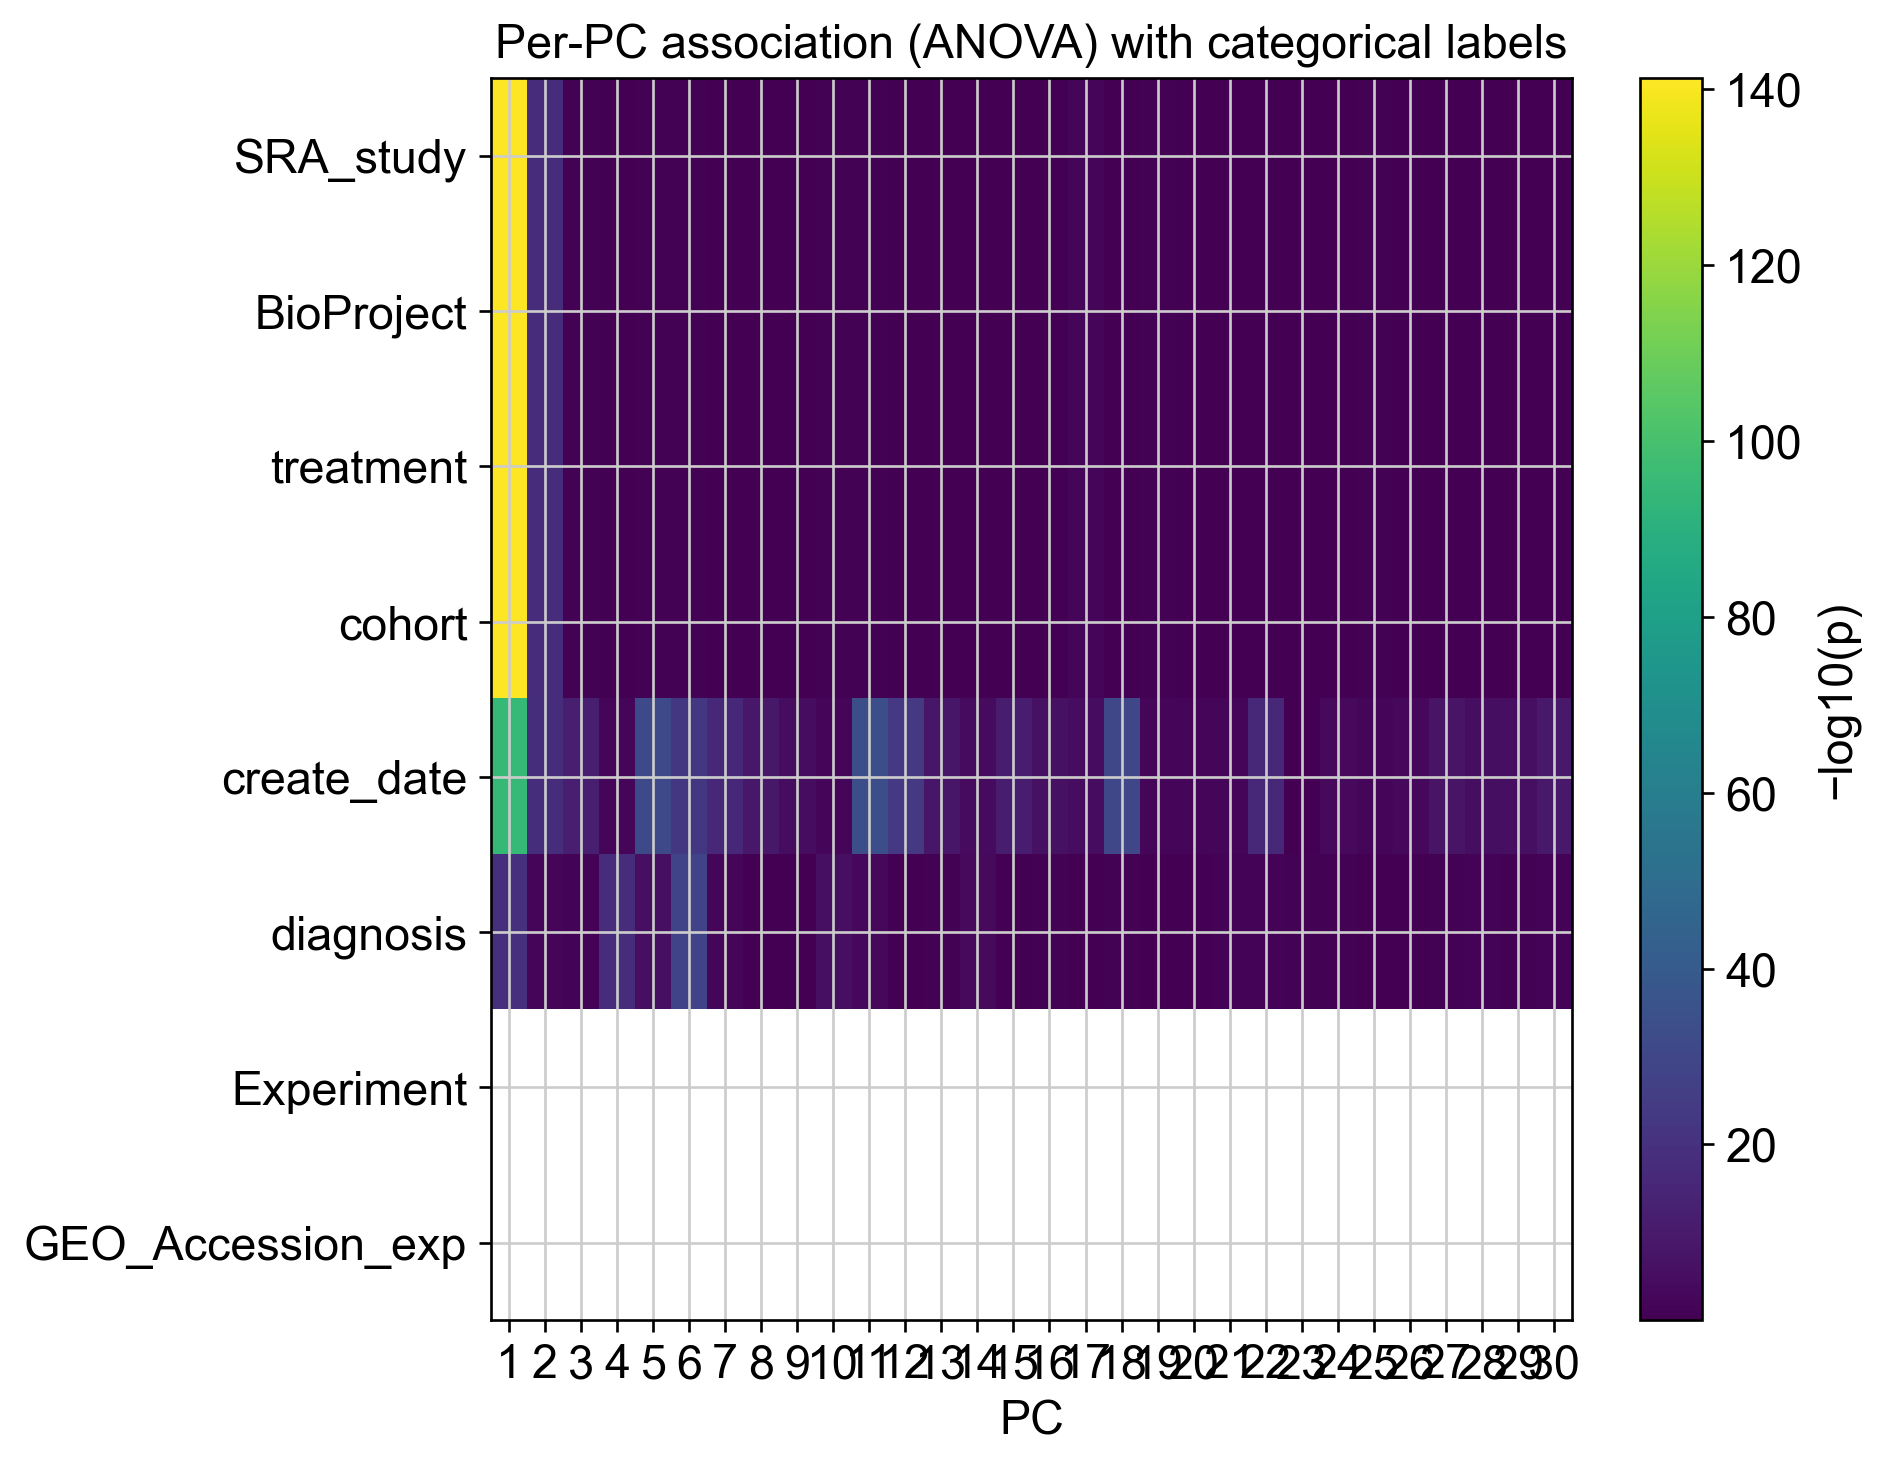

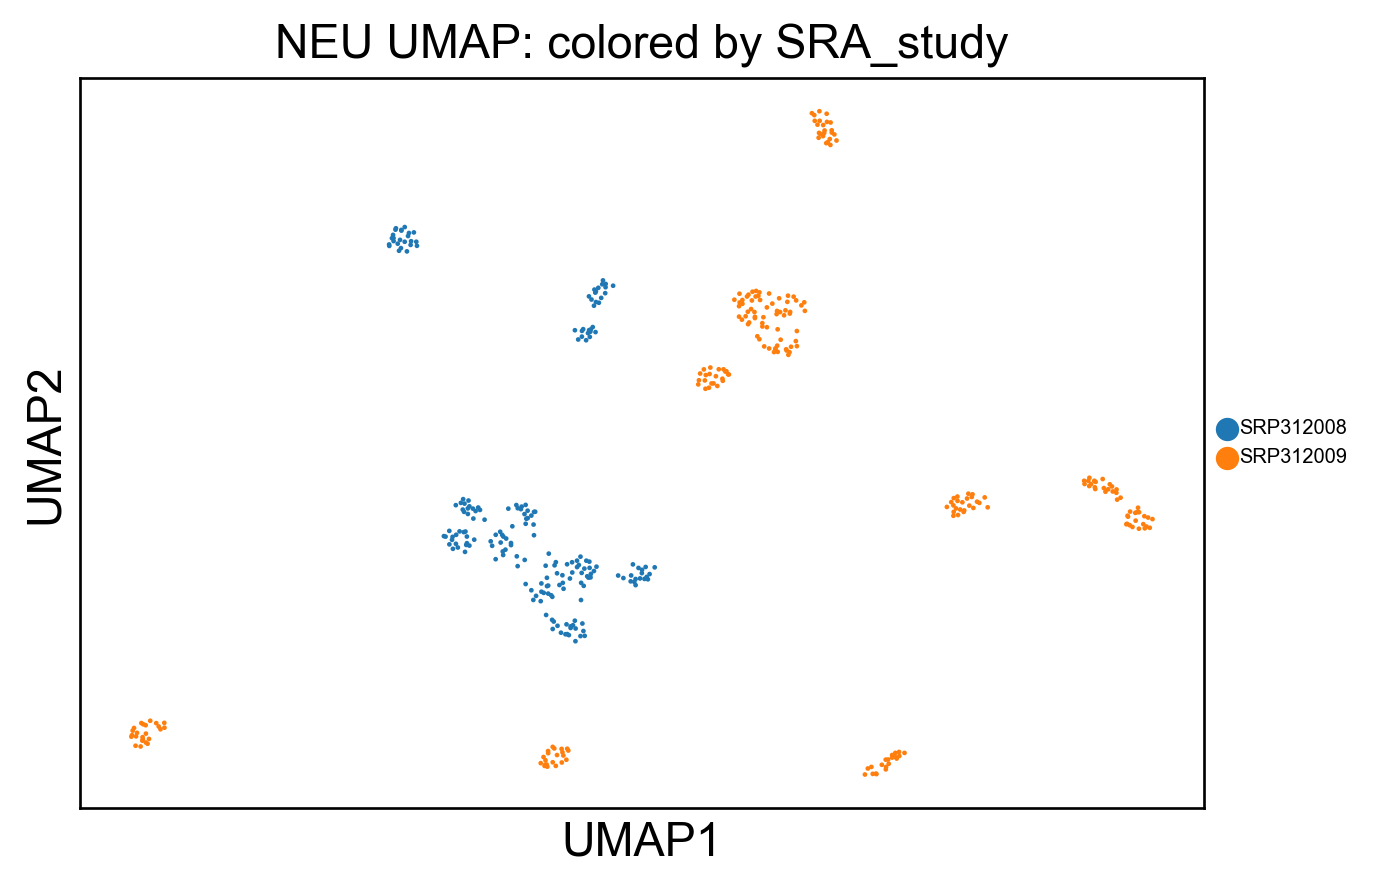

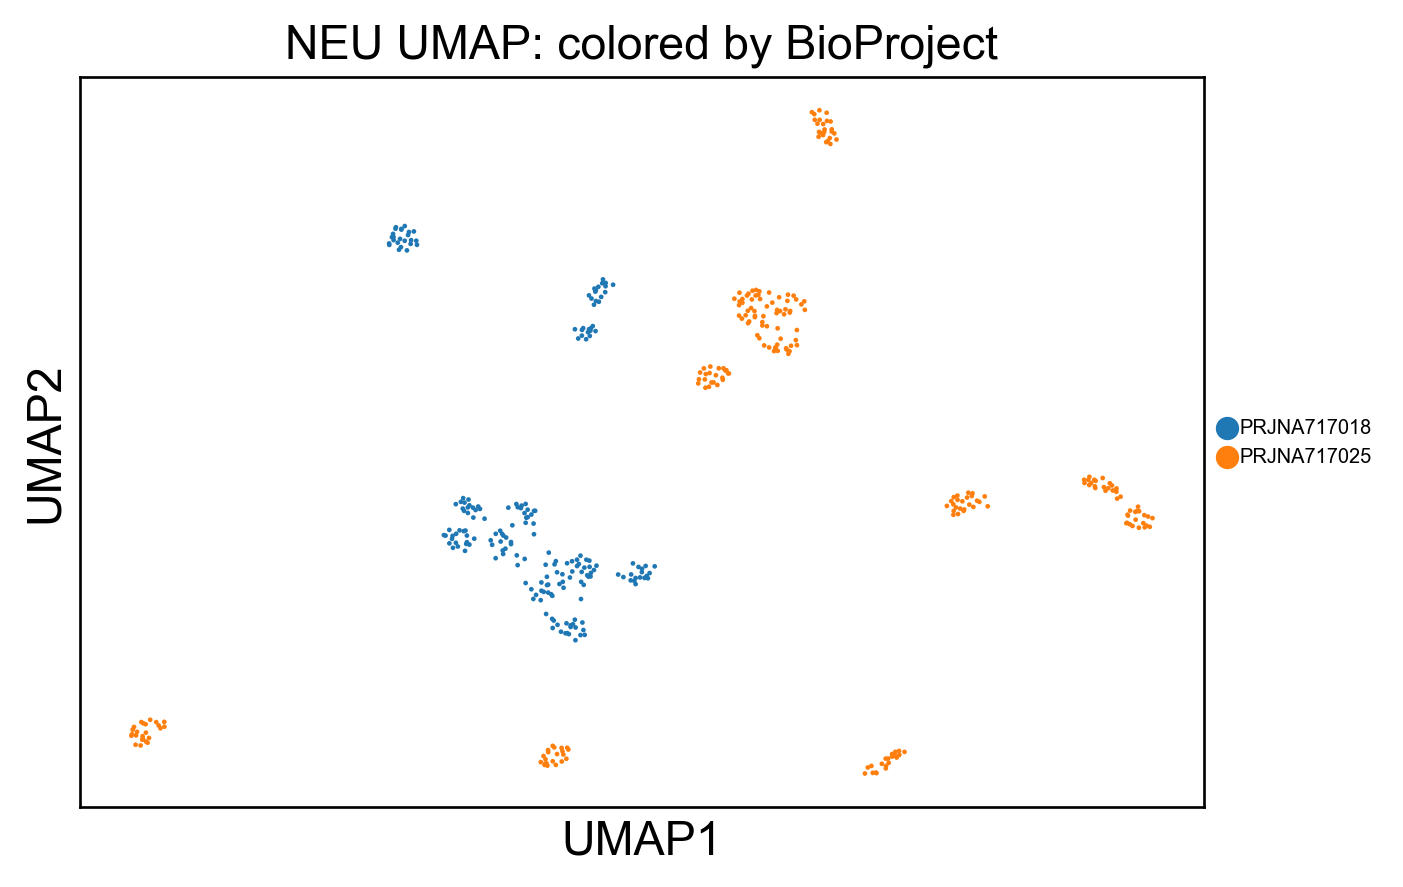

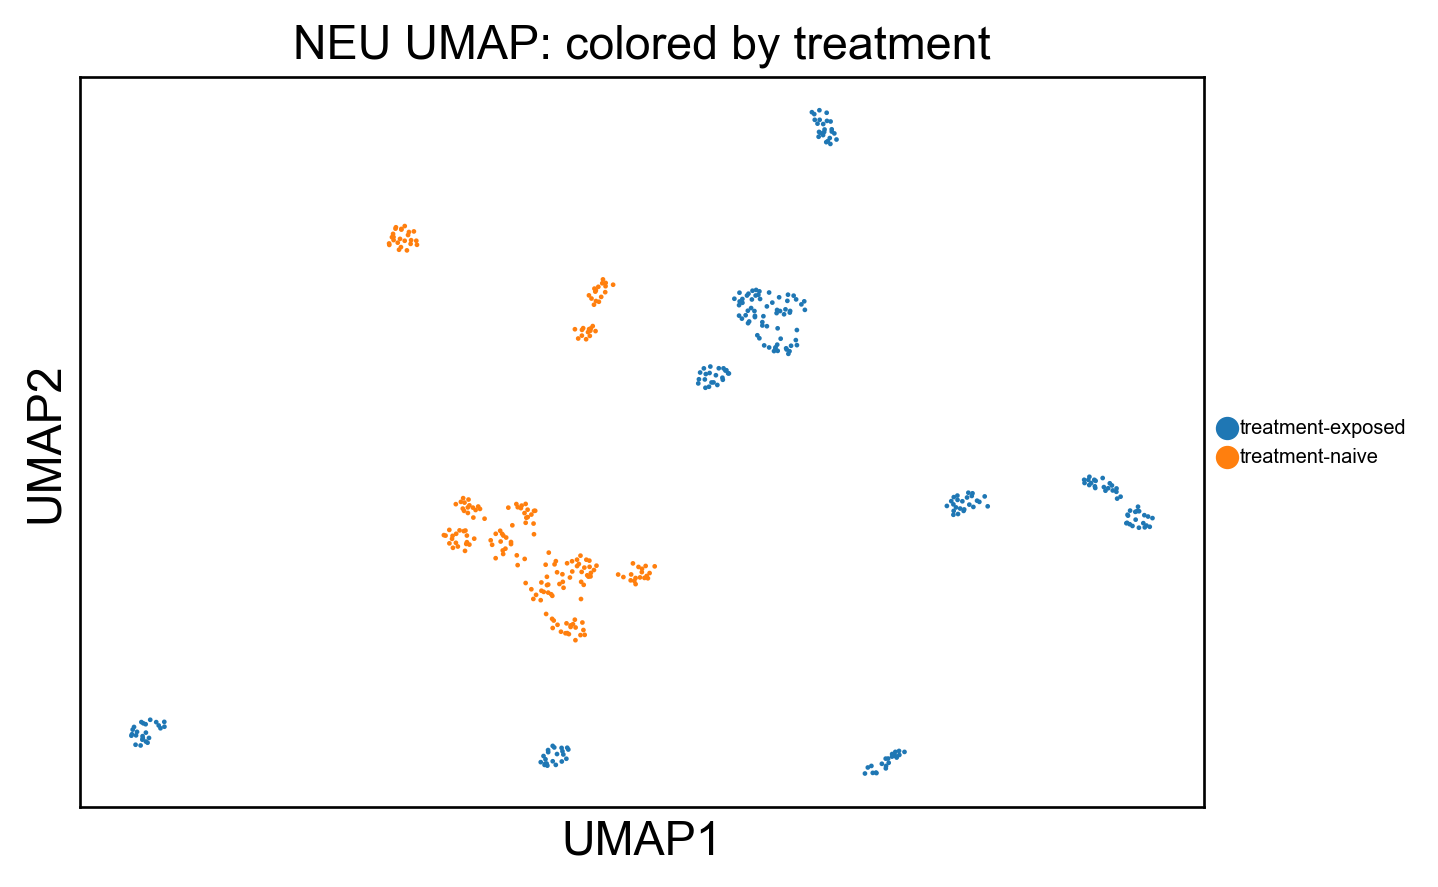

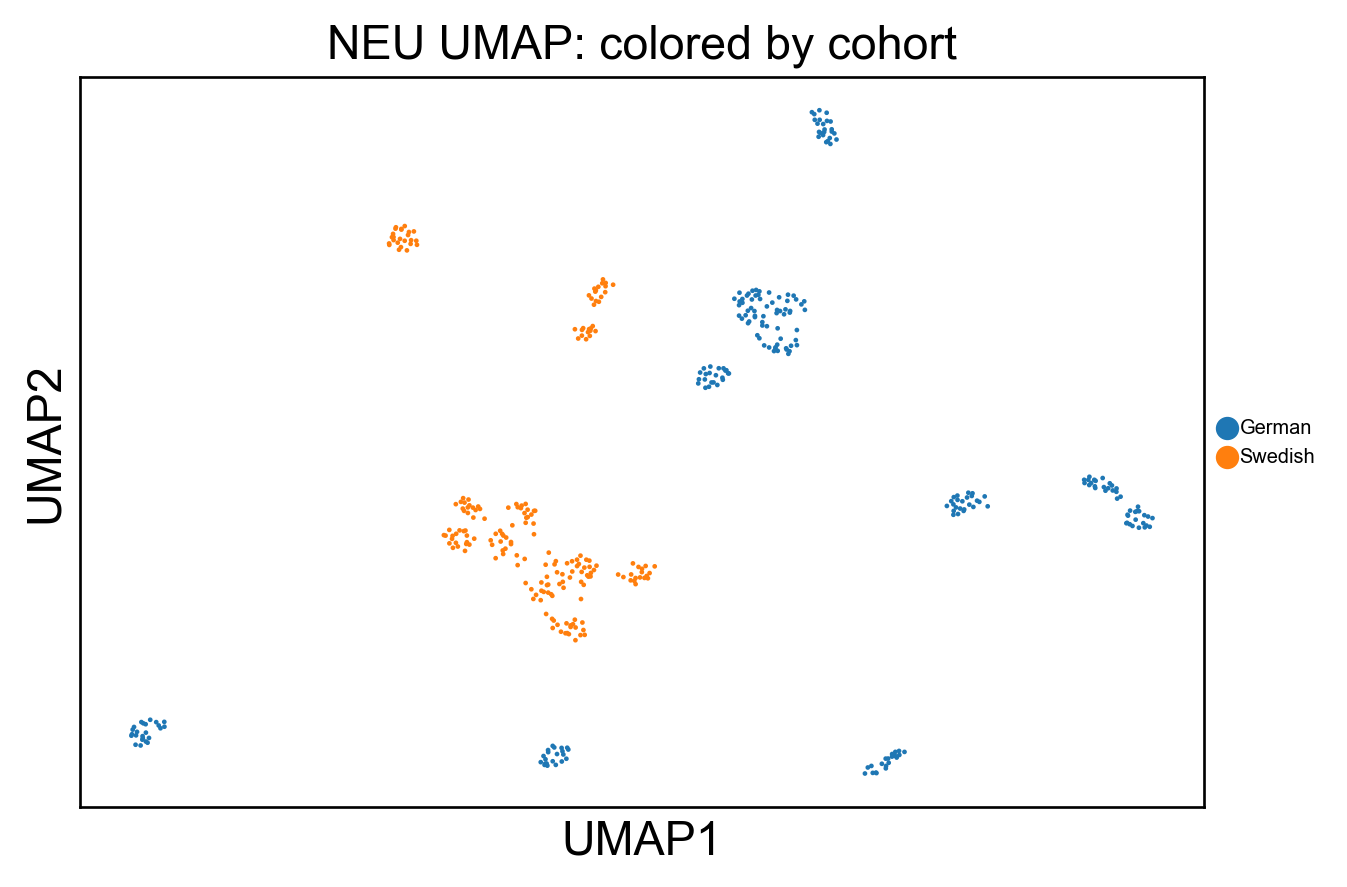

/var/folders/1t/p5pyw3cx76z8ldch6bnxjb_r0000gn/T/ipykernel_14029/3396464646.py:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r1, p1 = pearsonr(pcs[:,0], x)
/var/folders/1t/p5pyw3cx76z8ldch6bnxjb_r0000gn/T/ipykernel_14029/3396464646.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r2, p2 = pearsonr(pcs[:,1], x)



PC1/PC2 vs numeric metadata (Pearson r, p):
                                   key   PC         r              p
14              QC_mapping_ratio_miRNA  PC1 -0.890216  4.694214e-154
6   total_count_ratio__after_to_before  PC1 -0.800130  7.858008e-101
17             QC_mapping_ratio_sncRNA  PC2  0.760213   2.214785e-85
10          QC_mapping_ratio_bacterial  PC1  0.735621   2.717499e-77
16             QC_mapping_ratio_sncRNA  PC1  0.288253   5.312914e-10
15              QC_mapping_ratio_miRNA  PC2 -0.212128   6.070416e-06
0    total_counts_before_preprocessing  PC1  0.210088   7.485005e-06
11          QC_mapping_ratio_bacterial  PC2  0.189458   5.555611e-05
5     total_counts_after_preprocessing  PC2  0.188070   6.311180e-05
9                          total_count  PC2  0.187036   6.935710e-05
7   total_count_ratio__after_to_before  PC2 -0.183988   9.134845e-05
1    total_counts_before_preprocessing  PC2  0.177250   1.653136e-04

=== COV: ensuring PCA/UMAP and evaluating labels ===


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: divide by zero encountered in divide
  msw = sswn / float(dfwn)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-pac

            label_key  mean_-log10p  cv_acc_mean  cv_acc_std  silhouette  \
0         naat_result      1.483395     0.838889    0.064310   -0.074127   
1                 sex      0.868896     0.761111    0.033333    0.035238   
2  Participant_number      3.051081          NaN         NaN         NaN   
3         create_date      0.681644     0.616667    0.040825   -0.108794   
4           timepoint      0.803727     0.500000    0.060858   -0.030290   
5         Sample_name           NaN          NaN         NaN         NaN   
6                 age      1.161863          NaN         NaN         NaN   
7          Experiment           NaN          NaN         NaN         NaN   
8           BioSample           NaN          NaN         NaN         NaN   
9             vaccine      0.532408     0.577778    0.064310    0.013259   

   knn_entropy  rank_acc  rank_sil  rank_logp  rank_ent  rank_avg  
0     0.354228       1.0       4.0        2.0       1.0      2.00  
1     0.797267       2.0   

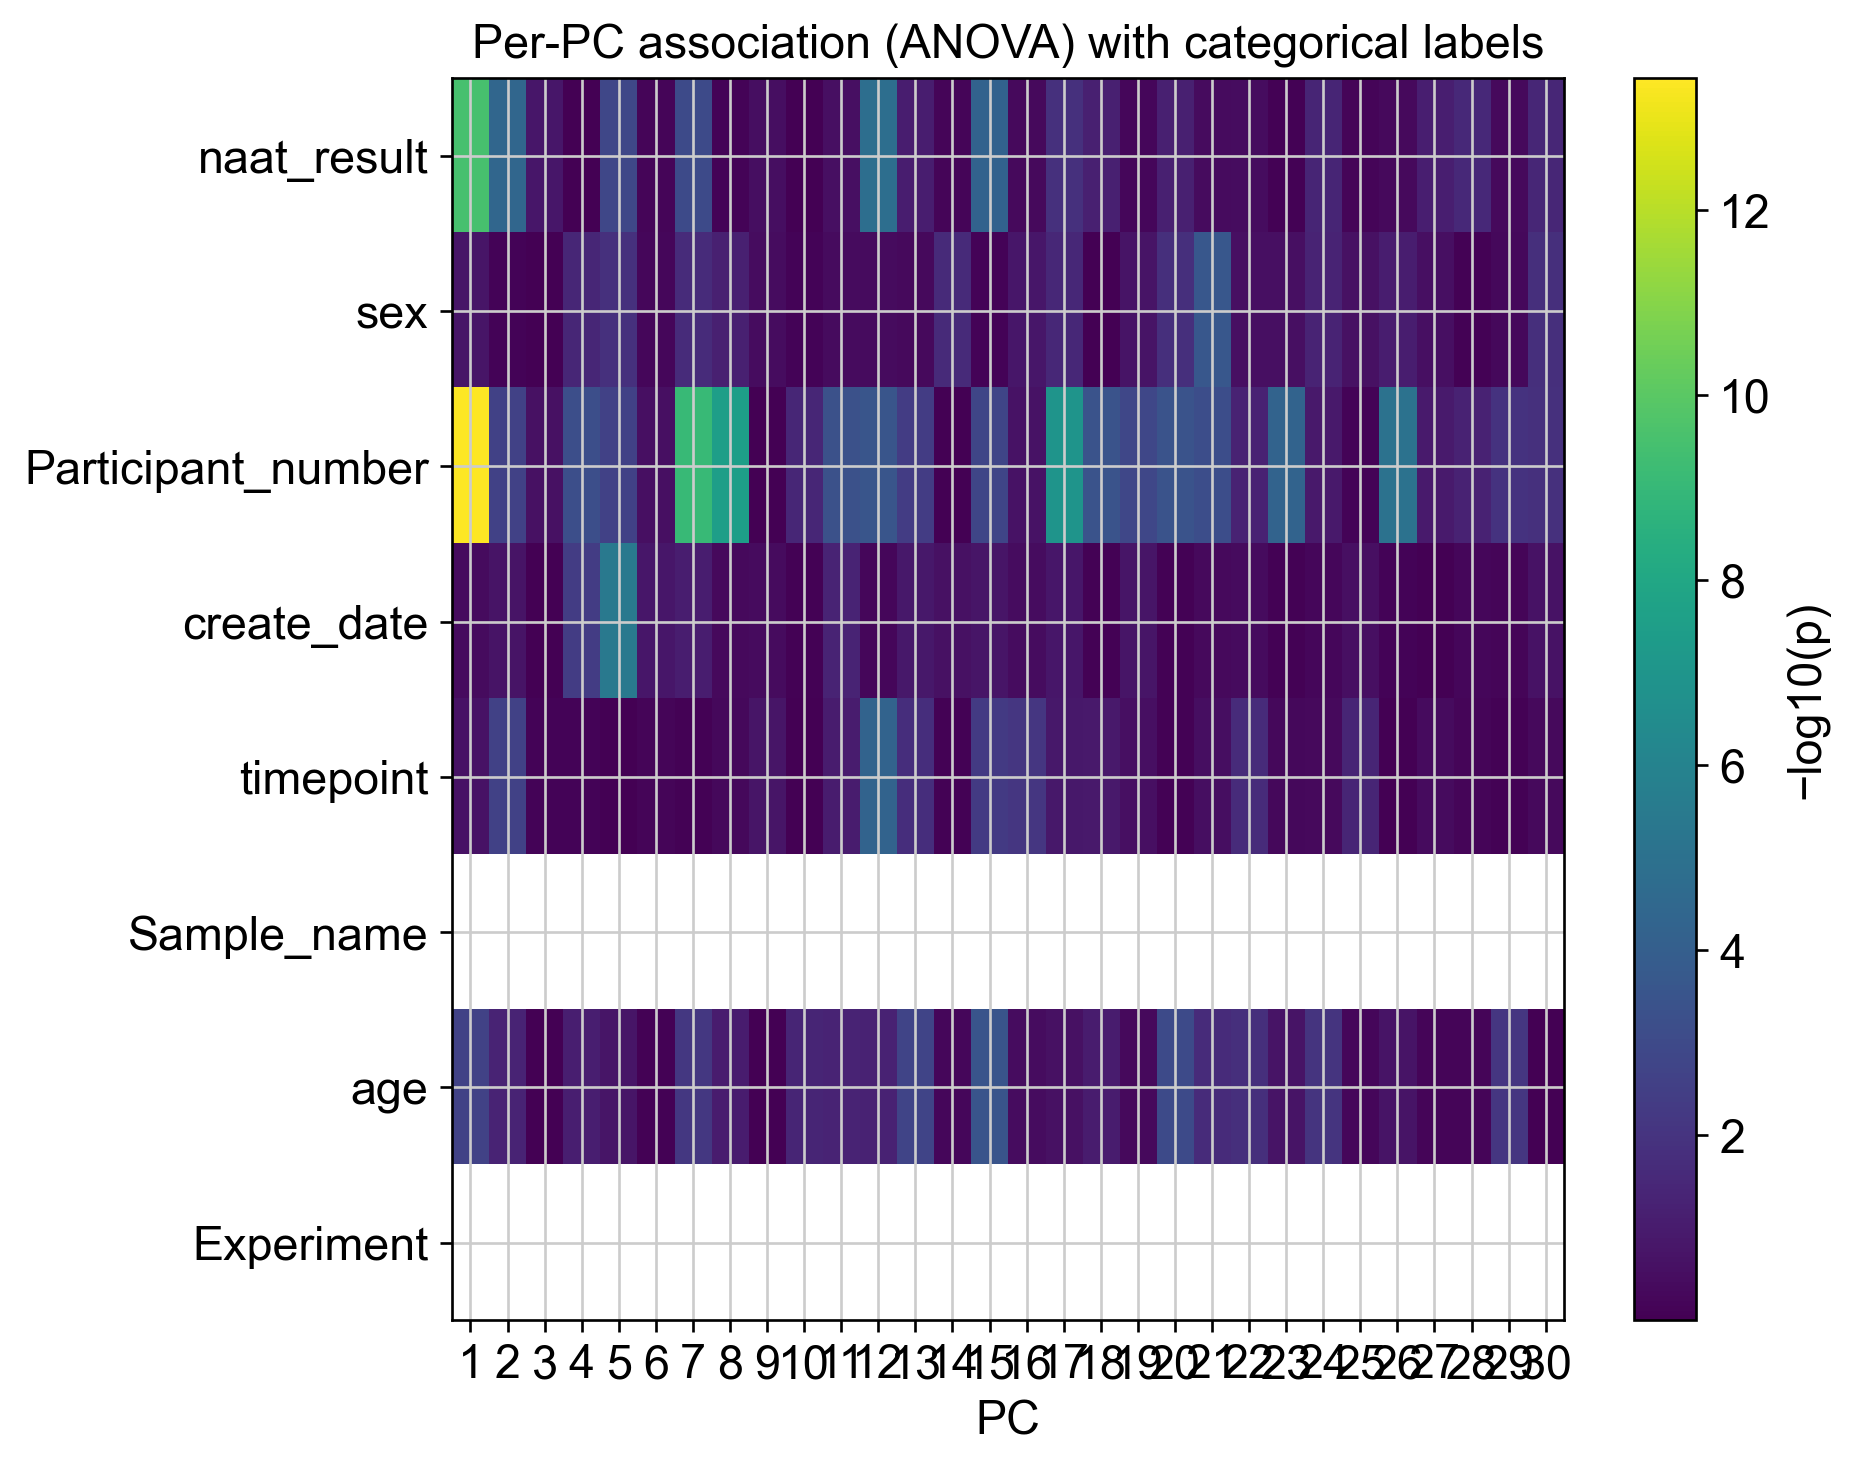

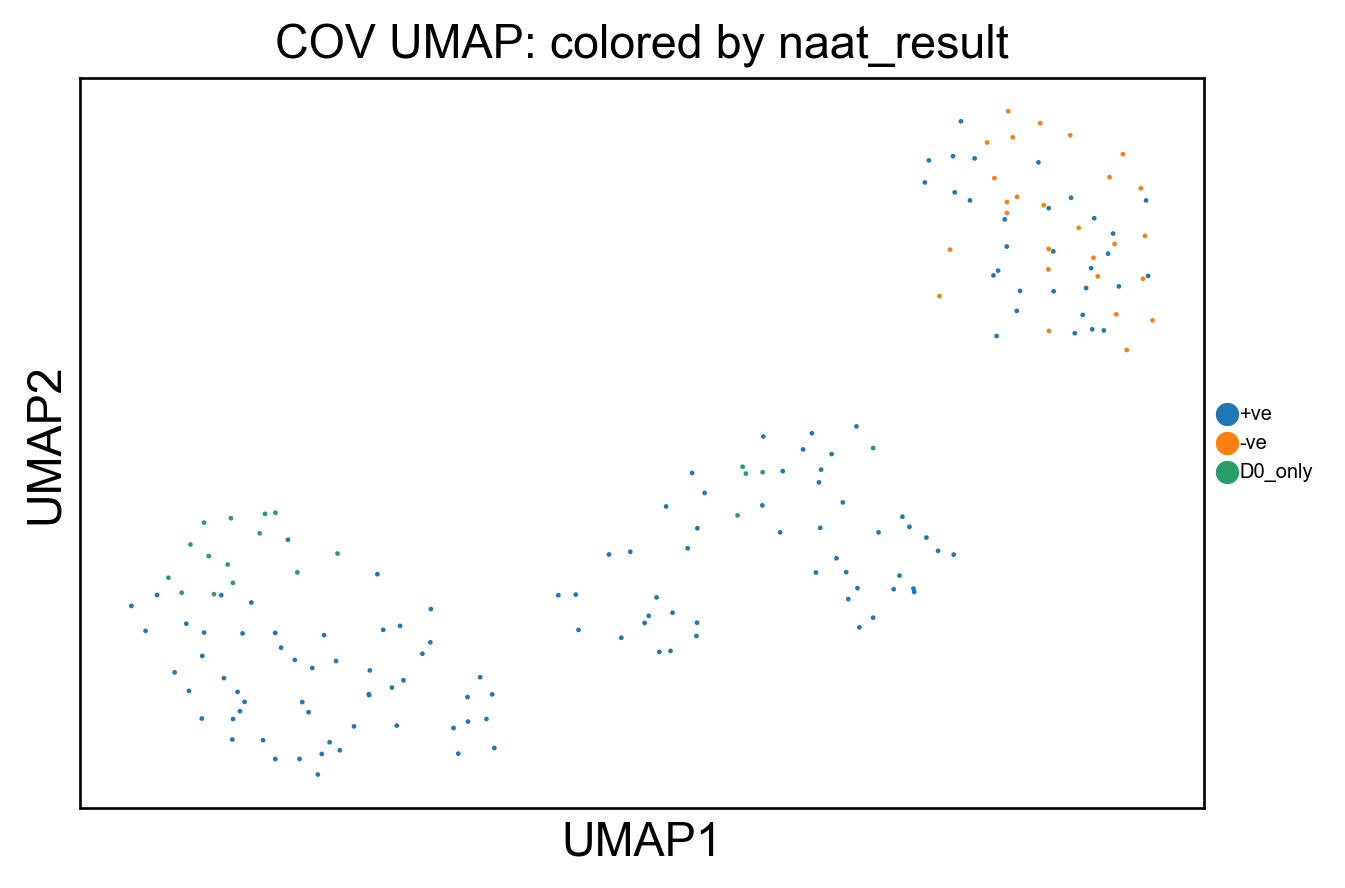

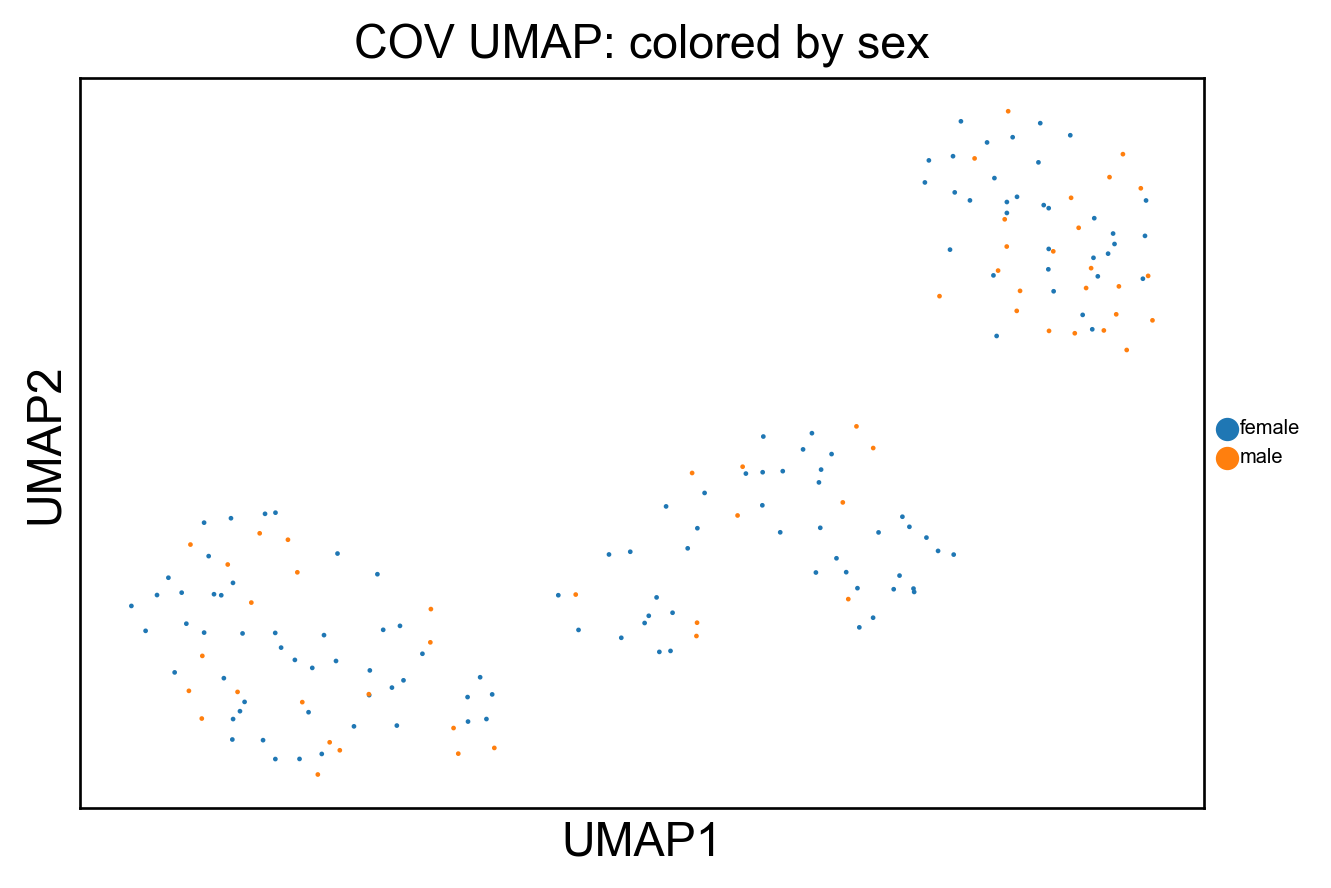

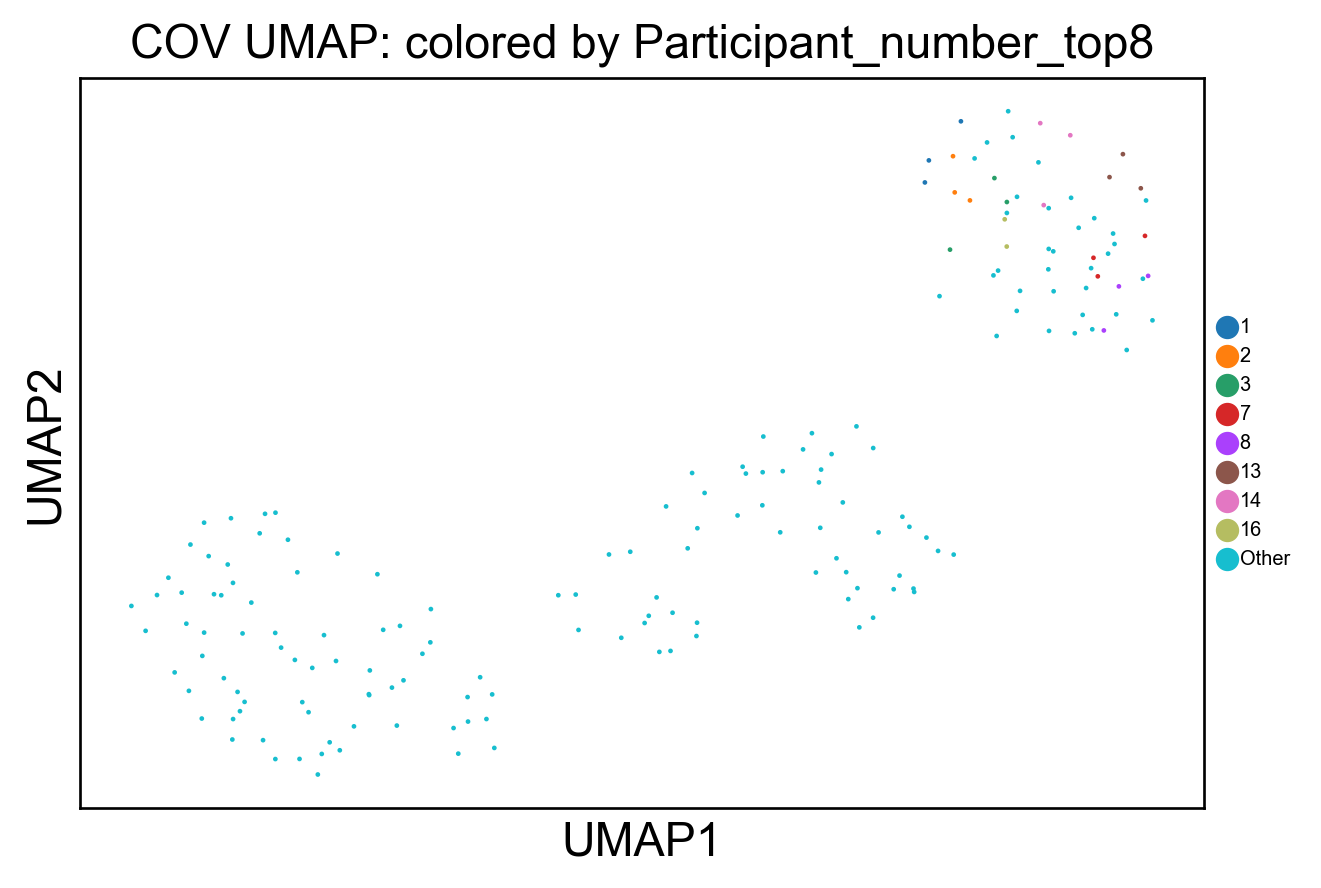

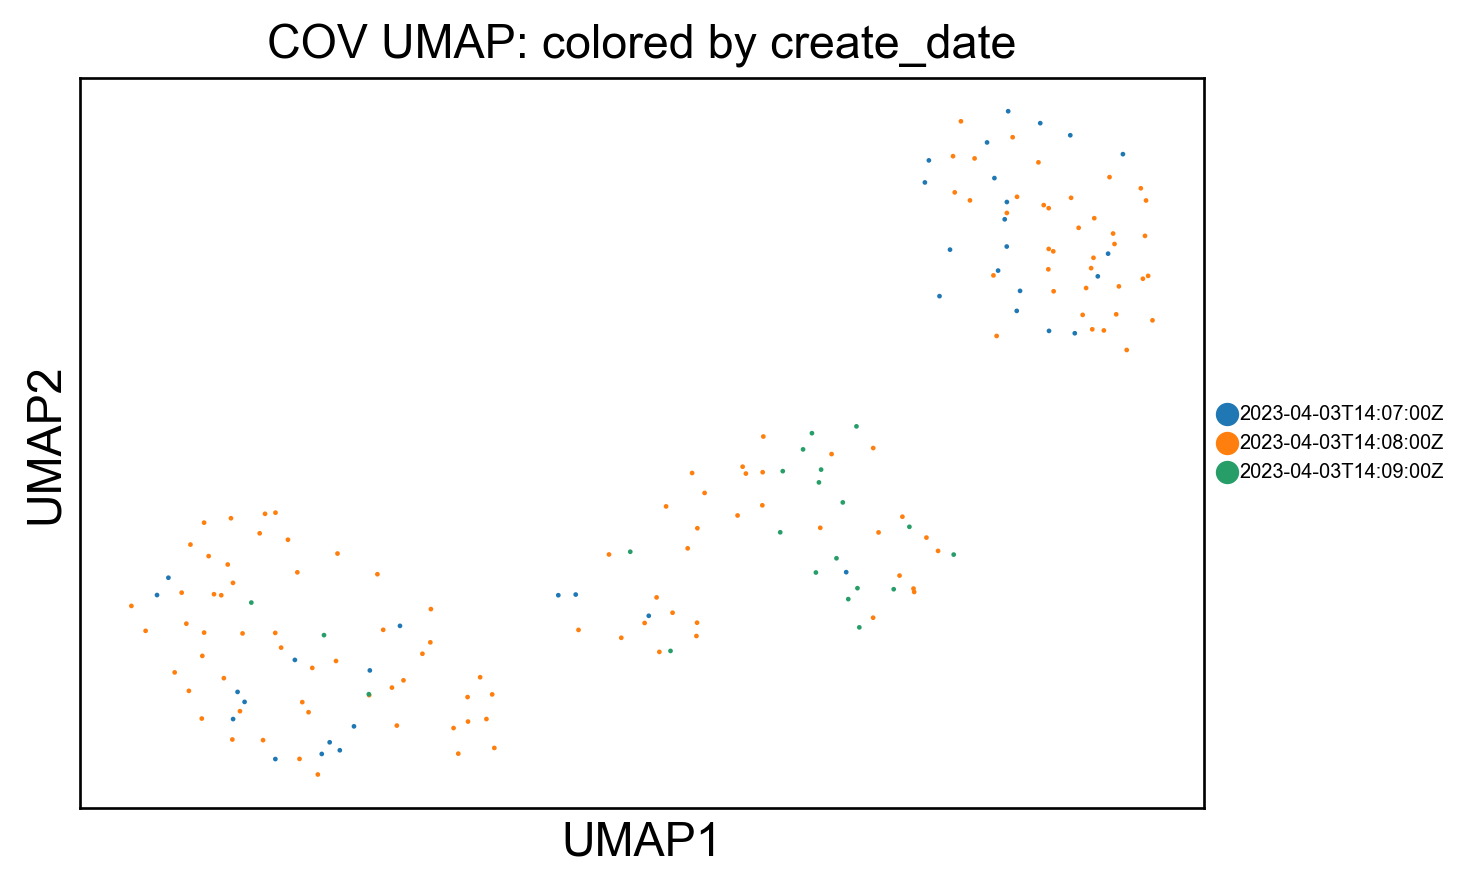


PC1/PC2 vs numeric metadata (Pearson r, p):
                                  key   PC         r             p
8          QC_mapping_ratio_bacterial  PC1  0.701959  4.925143e-28
14            QC_mapping_ratio_sncRNA  PC1  0.615385  3.863868e-20
12             QC_mapping_ratio_miRNA  PC1 -0.594933  1.292096e-18
0   total_counts_before_preprocessing  PC1  0.469952  2.818290e-11
2    total_counts_after_preprocessing  PC1  0.469952  2.818290e-11
6                         total_count  PC1  0.461191  7.249771e-11
13             QC_mapping_ratio_miRNA  PC2  0.424177  2.958673e-09
10             QC_mapping_ratio_viral  PC1  0.392104  5.222759e-08
15            QC_mapping_ratio_sncRNA  PC2 -0.307579  2.667535e-05
9          QC_mapping_ratio_bacterial  PC2 -0.274685  1.902271e-04
11             QC_mapping_ratio_viral  PC2 -0.254976  5.517035e-04
7                         total_count  PC2  0.010418  8.896033e-01


/var/folders/1t/p5pyw3cx76z8ldch6bnxjb_r0000gn/T/ipykernel_14029/3396464646.py:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r1, p1 = pearsonr(pcs[:,0], x)
/var/folders/1t/p5pyw3cx76z8ldch6bnxjb_r0000gn/T/ipykernel_14029/3396464646.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r2, p2 = pearsonr(pcs[:,1], x)


In [6]:
neu_res = run_all(neu_adata_proc, tag="NEU")
cov_res = run_all(cov_adata_proc, tag="COV")

## 5. QC Plots
- **What**: RLE plots, density plots, expression boxplots, and QC heatmaps.
- **Why**: To check whether technical variation manifests in expression distributions.
- **Interpretation**: Shifts or clustering by technical variables suggest batch effects.


In [ ]:
for ad in (neu_adata_proc, cov_adata_proc):
    sc.pp.normalize_total(ad, target_sum=1e6)
    sc.pp.log1p(ad)
    sc.pp.highly_variable_genes(ad, flavor='seurat_v3', n_top_genes=2000, subset=False)
    sc.tl.pca(ad, n_comps=50, svd_solver='arpack')

/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:392: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


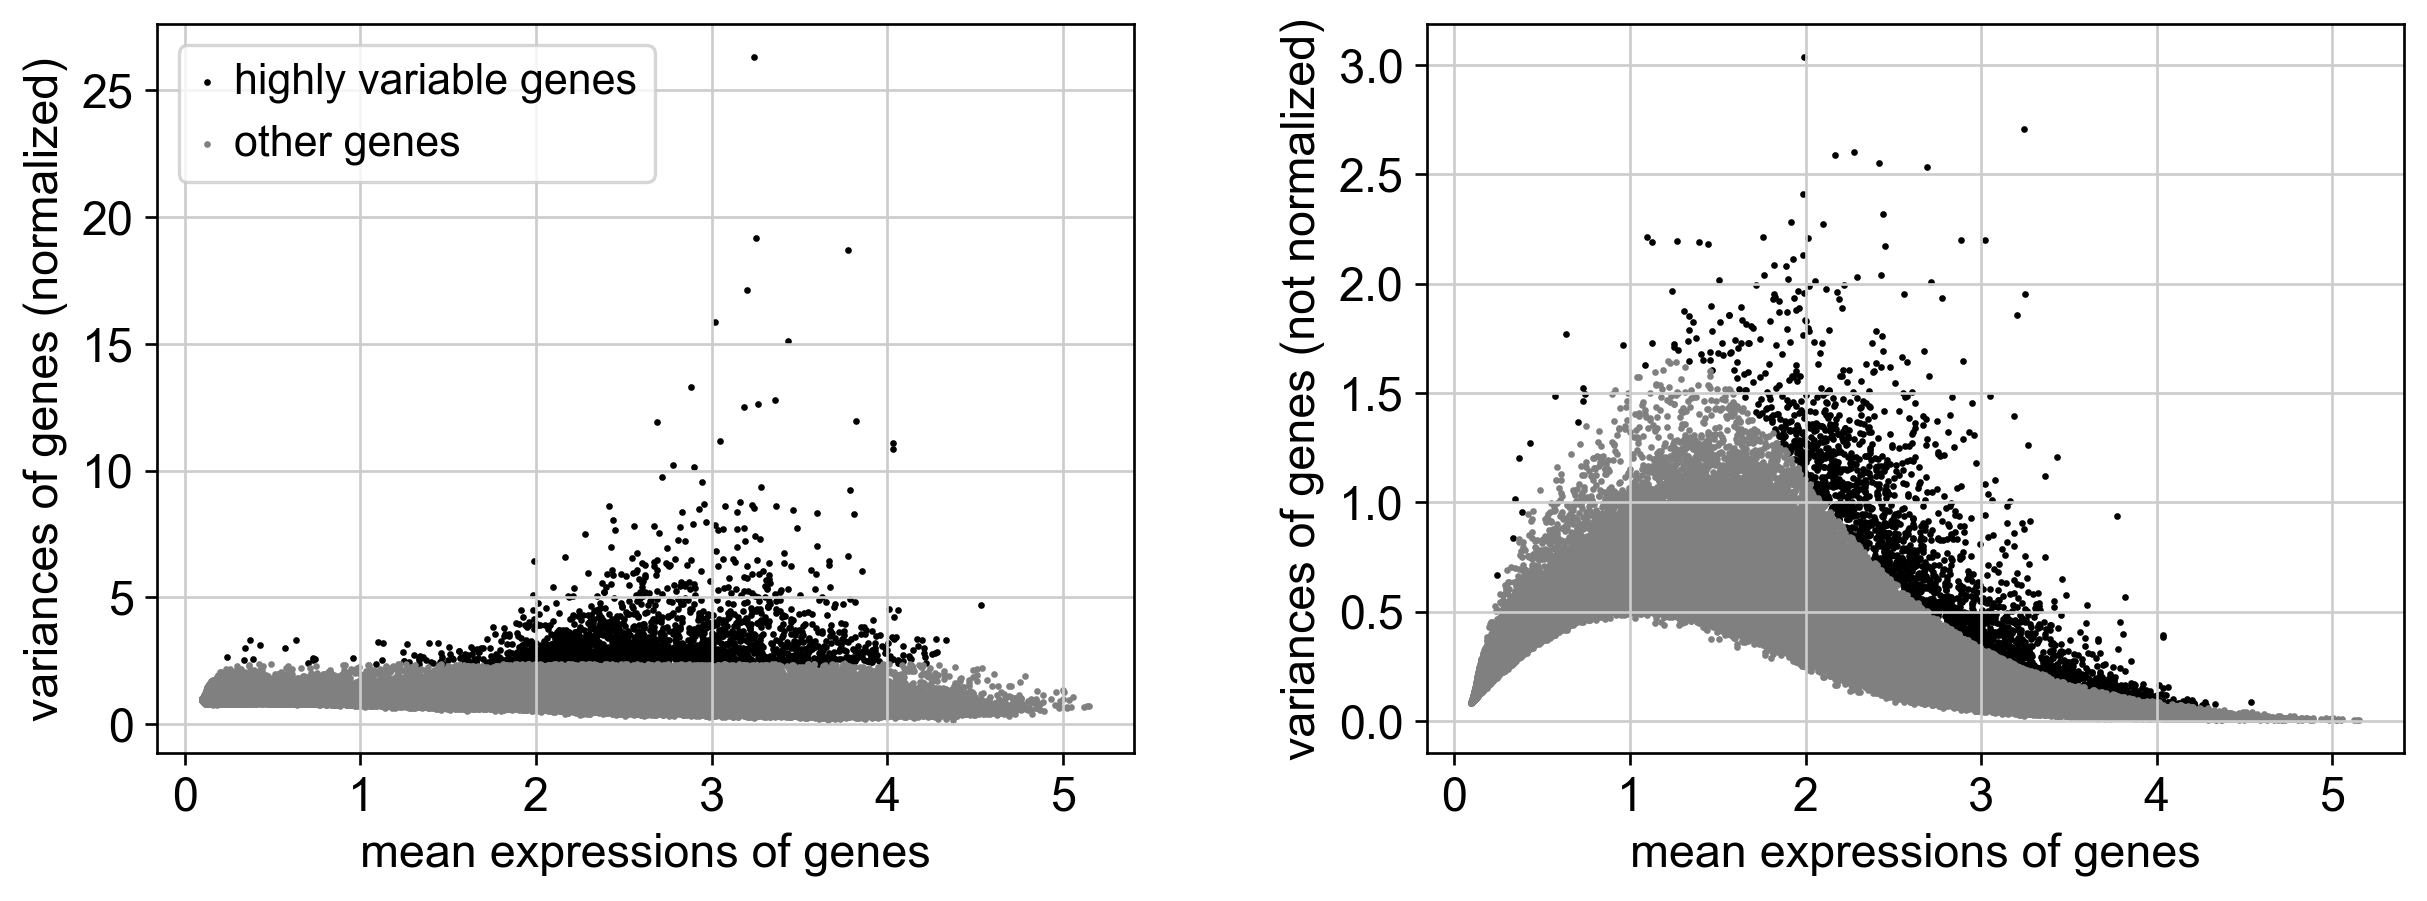

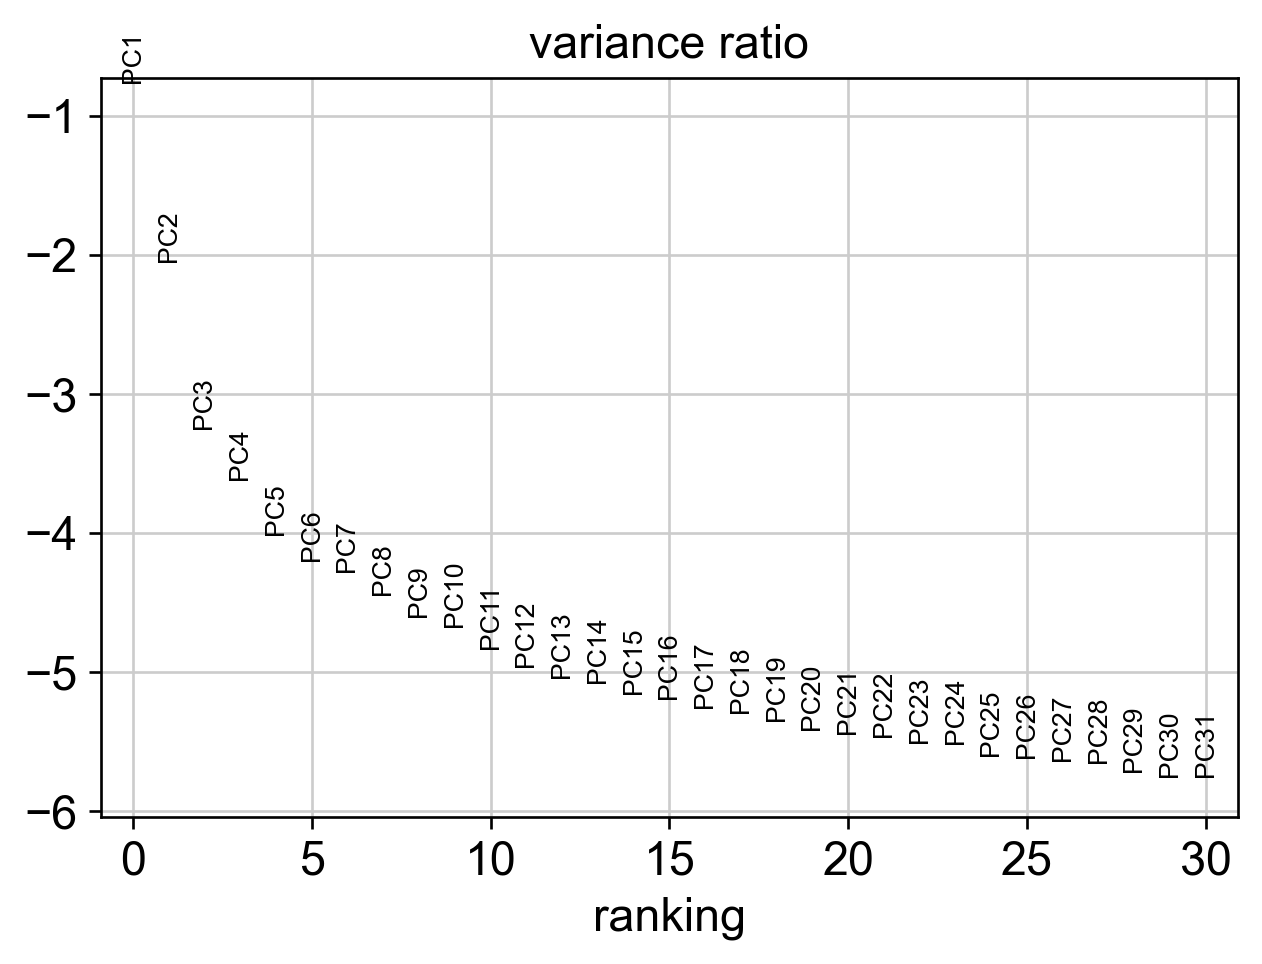

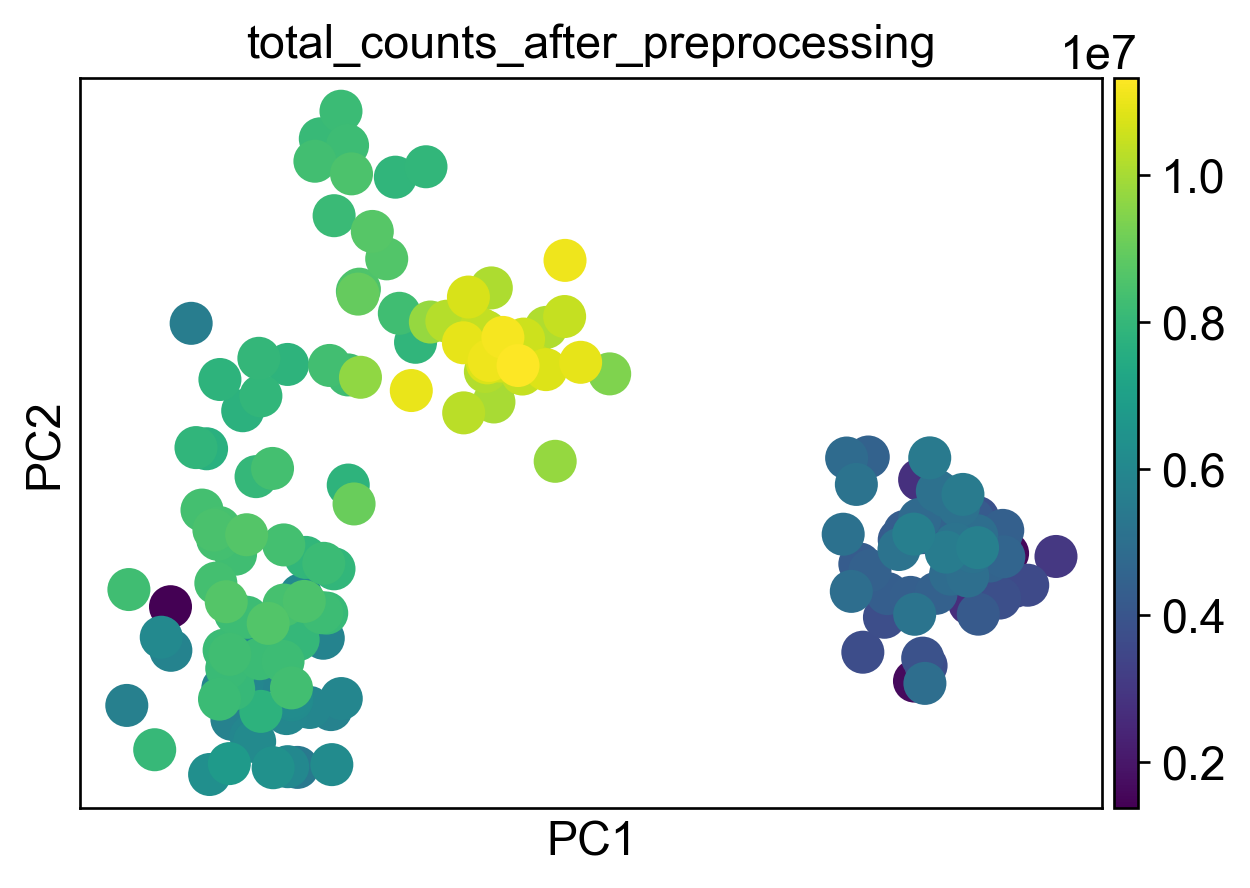

In [ ]:
# HVG QC plot
sc.pl.highly_variable_genes(ad)

# PCA variance ratio (explained variance per PC)
sc.pl.pca_variance_ratio(ad, log=True)

# PCA scatter
sc.pl.pca(ad, color=['total_counts_after_preprocessing'])


## 6. Variance Explained (ANOVA on PCs)
- **What**: Run ANOVA on principal components with respect to candidate labels.
- **Why**: To quantify how much variance is explained by each label.
- **Interpretation**: Multiple PCs with significant p-values and large η² indicate strong label effects.


/Users/mjlee/master_thesis/Thesis_project/thesispjt/thesis-impute/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


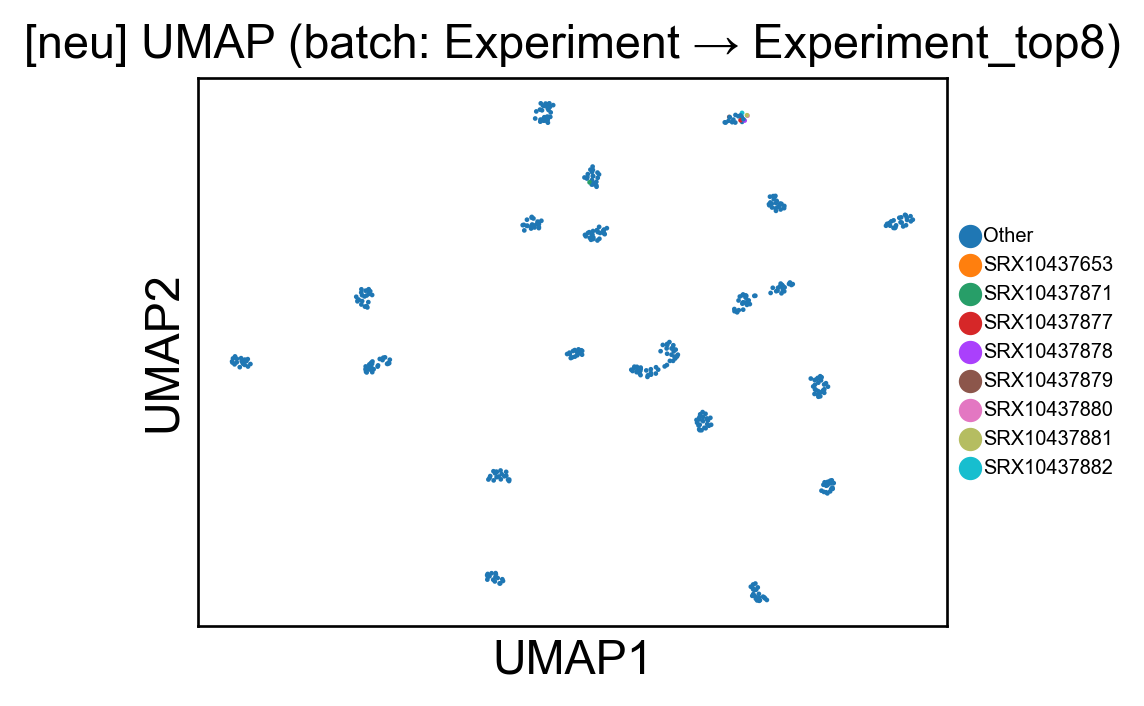

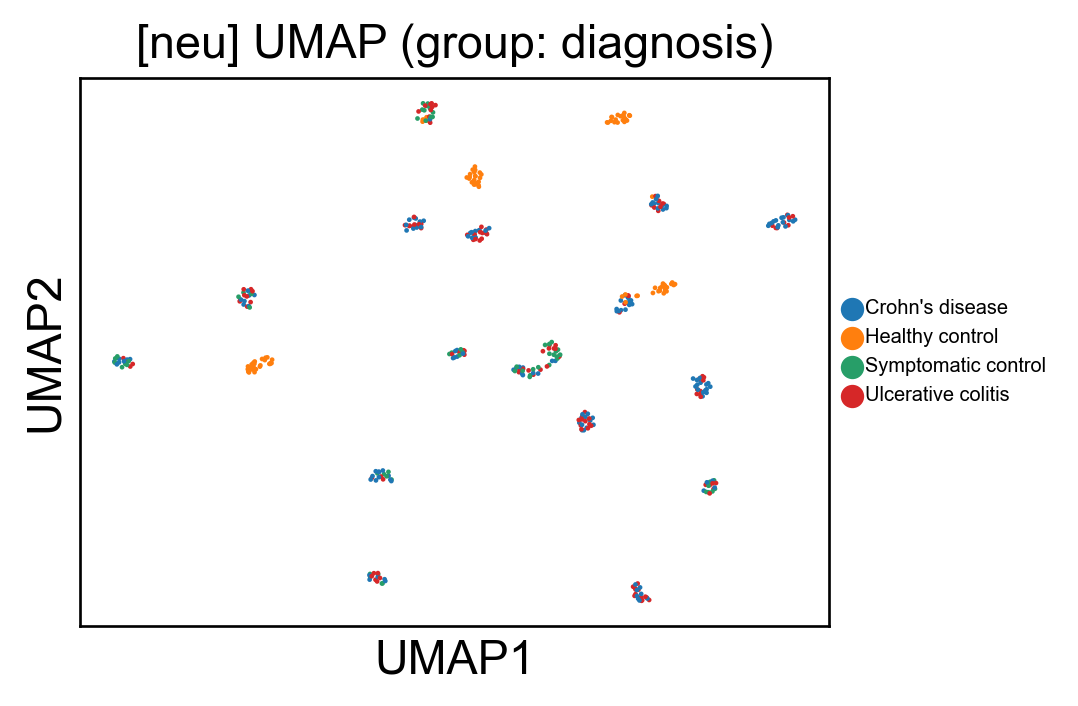

[neu] batch_key=Experiment, group_key=diagnosis


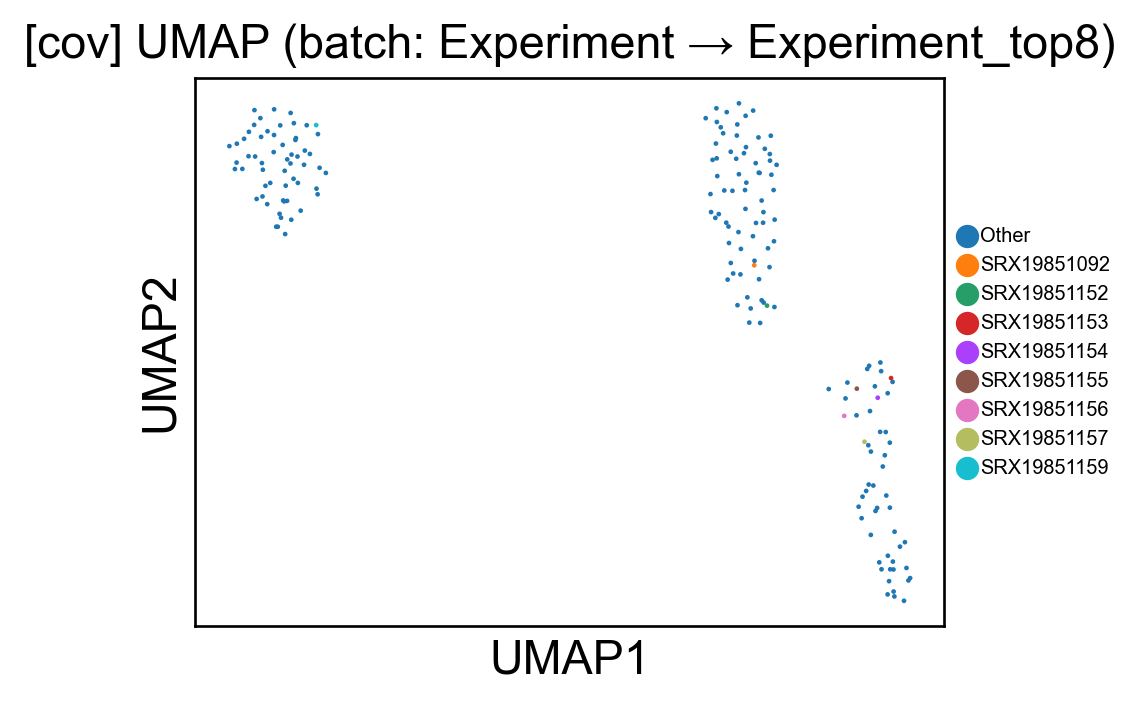

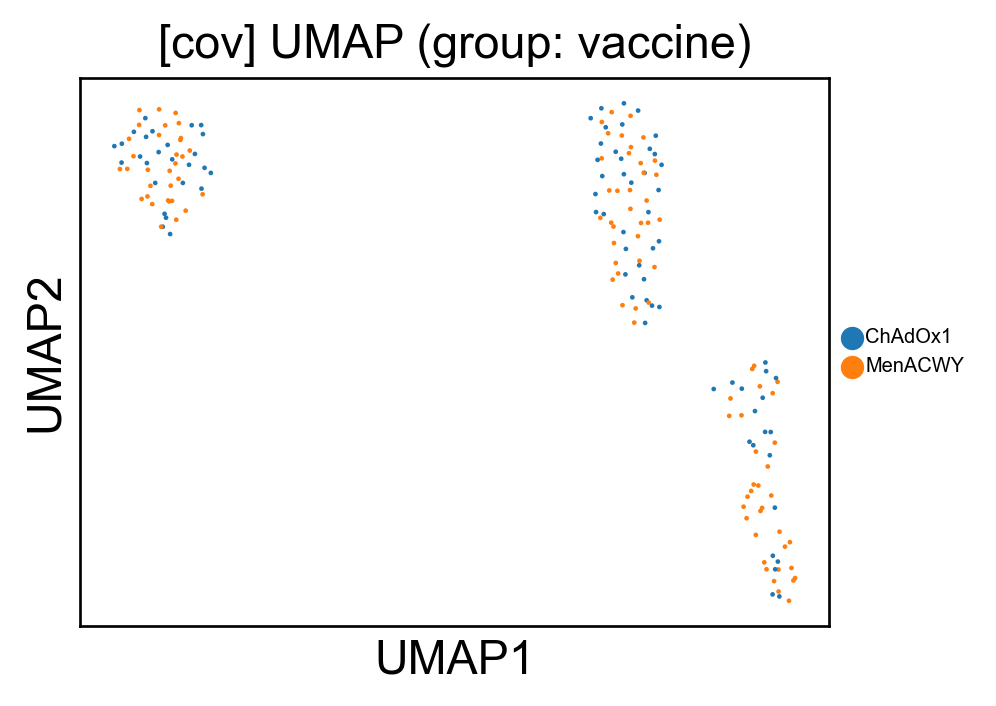

[cov] batch_key=Experiment, group_key=vaccine


In [ ]:
# ---- candidates tuned to your .obs ----
BATCH_CANDIDATES = [
    "Center_name","Sequencer","Lab_library_preparation_kit","Lab_RNA_extraction_protocol",
    "Lab_library_selection","Lab_library_source","Assay_type","Lab_library_layout","Sample_type",
    "Experiment","SRA_study","BioProject","GEO_Accession_exp","source_name","Consent",
    "Release_date","create_date","version","BioSample","Sample_name"
]
GROUP_CANDIDATES = [
    "diagnosis","treatment","cohort","vaccine","naat_result","timepoint",
    "status","disease","condition","group","Participant_number","sex","age"
]

# ---- helpers ----
def ensure_pca(adata, n_pcs=30, random_state=42):
    """Compute PCA on HVGs if available; no-op if X_pca already present."""
    if "X_pca" in adata.obsm and adata.obsm["X_pca"].shape[1] >= n_pcs:
        return
    if "highly_variable" in adata.var:
        sc.pp.scale(adata, zero_center=True, max_value=10)
        sc.tl.pca(adata, n_comps=n_pcs, use_highly_variable=True, random_state=random_state, svd_solver="arpack")
    else:
        sc.pp.scale(adata, zero_center=True, max_value=10)
        sc.tl.pca(adata, n_comps=n_pcs, random_state=random_state, svd_solver="arpack")

def pick_obs_key(adata, candidates, min_levels=2, max_levels=10_000):
    """Return first candidate that exists and has reasonable cardinality (not constant)."""
    for k in candidates:
        if k in adata.obs.columns:
            nlev = adata.obs[k].astype(str).nunique(dropna=True)
            if min_levels <= nlev <= max_levels:
                return k
    return None

def add_topk_other(adata, key, k=8, other_name="Other"):
    """Create a collapsed categorical with top-k frequent levels kept, others -> 'Other'."""
    col = f"{key}_top{k}"
    vc = adata.obs[key].astype(str).value_counts()
    keep = set(vc.head(k).index)
    adata.obs[col] = adata.obs[key].astype(str).where(adata.obs[key].astype(str).isin(keep), other_name)
    return col

# ---- main plotting function (replaces your try_plot_umap) ----
def try_plot_umap(ad, tag: str, n_pcs=30, random_state=42, n_neighbors=15, topk_k=8):
    # pick batch/group keys from your tailored candidate lists
    batch_key = pick_obs_key(ad, BATCH_CANDIDATES, min_levels=2)
    group_key = pick_obs_key(ad, GROUP_CANDIDATES, min_levels=2)

    # ensure PCA and build neighbors on PCs; then UMAP
    ensure_pca(ad, n_pcs=n_pcs, random_state=random_state)
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, n_pcs=min(n_pcs, ad.obsm["X_pca"].shape[1]))
    sc.tl.umap(ad, random_state=random_state)

    # batch UMAP (Top-K + Other if too many levels)
    if batch_key:
        nlev = ad.obs[batch_key].astype(str).nunique(dropna=True)
        color_key = batch_key if nlev <= topk_k else add_topk_other(ad, batch_key, k=topk_k)
        sc.pl.umap(
            ad, color=[color_key],
            title=f"[{tag}] UMAP (batch: {batch_key}{' → '+color_key if color_key!=batch_key else ''})",
            size=8, legend_loc="right margin", legend_fontsize=6, show=True
        )
    else:
        # still show a plain UMAP so you see structure even if no batch key found
        sc.pl.umap(ad, title=f"[{tag}] UMAP (no batch key found)", size=8, show=True)

    # group UMAP (Top-K + Other if too many levels)
    if group_key:
        nlev_g = ad.obs[group_key].astype(str).nunique(dropna=True)
        color_group = group_key if nlev_g <= topk_k else add_topk_other(ad, group_key, k=topk_k)
        sc.pl.umap(
            ad, color=[color_group],
            title=f"[{tag}] UMAP (group: {group_key}{' → '+color_group if color_group!=group_key else ''})",
            size=8, legend_loc="right margin", legend_fontsize=6, show=True
        )

    return batch_key, group_key  # handy to know what was used

# ---- run for your two datasets ----
for tag, ad in [("neu", neu_adata_proc), ("cov", cov_adata_proc)]:
    bk, gk = try_plot_umap(ad, tag)
    print(f"[{tag}] batch_key={bk}, group_key={gk}")


## 7. Differential Expression (DE) & Volcano Plots
- **What**: Perform differential expression between groups and visualize with volcano plots.
- **Why**: To assess whether DE results could be biased by technical effects.
- **Interpretation**: If top DE genes flip after correction, batch effects were likely confounding.


In [ ]:
# --- Candidate batch discovery & clustering utilities (no saving, inline only) ---

import re
from typing import List, Dict, Optional
from sklearn.metrics import silhouette_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def list_candidate_batch_cols(adata, min_levels=2, max_levels=50) -> List[str]:
    """Scan adata.obs for categorical-like columns that could act as batch labels."""
    keywords = ['batch','Batch','plate','Plate','run','Run','lane','Lane','well','Well',
                'donor','Donor','sample','Sample','library','Library','center','Center',
                'site','Site','chemistry','Chemistry','kit','Kit','date','Date']
    candidates = []
    for col in adata.obs.columns:
        ser = adata.obs[col]
        # treat as categorical if object/category/bool or few unique levels
        nunique = ser.nunique(dropna=True)
        if nunique >= min_levels and nunique <= max_levels:
            if pd.api.types.is_categorical_dtype(ser) or pd.api.types.is_object_dtype(ser) or pd.api.types.is_bool_dtype(ser):
                candidates.append(col)
            elif pd.api.types.is_integer_dtype(ser) or pd.api.types.is_string_dtype(ser):
                candidates.append(col)
            elif nunique <= 10:  # small number of levels even if numeric
                candidates.append(col)
        # keyword boost
    # Bring keyword hits to the front
    key_hits = [c for c in candidates if any(k in str(c) for k in keywords)]
    others   = [c for c in candidates if c not in key_hits]
    return key_hits + others

def ensure_pca_neighbors_umap(adata, n_pcs=30, n_neighbors=15):
    """Compute PCA, neighbors, UMAP if needed."""
    if 'X_pca' not in adata.obsm_keys():
        sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep='X_pca')
    if 'X_umap' not in adata.obsm_keys():
        sc.tl.umap(adata)

def run_leiden(adata, key_added='clusters', resolution=1.0):
    """Run Leiden clustering over neighbor graph."""
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    return key_added

def plot_dimreductions(adata, color_keys, title_prefix='EDA'):
    """Show UMAP and t-SNE colored by given obs keys."""
    ensure_pca_neighbors_umap(adata)
    if not isinstance(color_keys, list):
        color_keys = [color_keys]
    # UMAP
    sc.pl.umap(adata, color=color_keys, title=[f'{title_prefix}: UMAP colored by {", ".join(color_keys)}'], show=True)
    # t-SNE (optional)
    sc.tl.tsne(adata, use_rep='X_pca', n_pcs=min(30, adata.obsm['X_pca'].shape[1]))
    sc.pl.tsne(adata, color=color_keys, title=[f'{title_prefix}: t-SNE colored by {", ".join(color_keys)}'], show=True)


# Final Interpretation Guide
1. Batch strength: check Silhouette/Entropy/Predictability/iLISI/kBET.
2. QC evidence: RLE, density, heatmap for group-level shifts.
3. Variance explained: PCs significantly associated with candidate labels.
4. DE stability: compare volcano plots before vs. after correction.


In [ ]:
# --- Variance explained on PCs and predictability of labels from PCs ---

import numpy as np
import pandas as pd
from scipy import stats

def variance_explained_on_pcs(adata, label_key, n_pcs=20) -> pd.DataFrame:
    """
    For each of the first n PCs, compute one-way ANOVA across label groups,
    and report F, p-value, and an eta-squared-like effect size proxy.
    """
    if label_key not in adata.obs.columns:
        raise ValueError(f"{label_key} not in .obs")
    labels = adata.obs[label_key].astype('category')
    ensure_pca_neighbors_umap(adata)
    Xpca = adata.obsm['X_pca'][:, :n_pcs]
    groups = [Xpca[labels.cat.codes.values == k] for k in range(labels.cat.categories.size)]
    rows = []
    for pc in range(n_pcs):
        arrays = [g[:, pc] for g in groups if g.shape[0] > 1]
        if len(arrays) < 2:
            F, p, eta2 = np.nan, np.nan, np.nan
        else:
            F, p = stats.f_oneway(*arrays)
            # eta^2 proxy on PC scores: betweenSS/totalSS
            data = Xpca[:, pc]
            grand_mean = data.mean()
            ss_between = sum(len(a) * (a.mean() - grand_mean)**2 for a in arrays)
            ss_total   = ((data - grand_mean)**2).sum()
            eta2 = (ss_between/ss_total) if ss_total > 0 else np.nan
        rows.append({'pc': pc+1, 'F': F, 'pval': p, 'eta2': eta2})
    df = pd.DataFrame(rows)
    # Simple summary printout
    with pd.option_context('display.max_rows', None, 'display.precision', 4):
        print(f'[Variance explained] {label_key}')
        display(df)
    return df

def predictability_from_pcs(adata, label_key, n_pcs=30, cv_splits=5) -> float:
    """
    Cross-validated balanced accuracy predicting label_key from PCs.
    High accuracy suggests strong separability (could be batch).
    """
    if label_key not in adata.obs.columns:
        raise ValueError(f"{label_key} not in .obs")
    y = adata.obs[label_key].astype('category').cat.codes.values
    ensure_pca_neighbors_umap(adata)
    X = adata.obsm['X_pca'][:, :n_pcs]
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('clf', LogisticRegression(max_iter=200, n_jobs=None, multi_class='auto'))
    ])
    cv = StratifiedKFold(n_splits=min(cv_splits, len(np.unique(y))), shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='balanced_accuracy')
    acc = float(np.mean(scores))
    print(f'[Predictability] {label_key}: balanced accuracy (CV) = {acc:.3f}')
    return acc


— RLE/density/box on neu


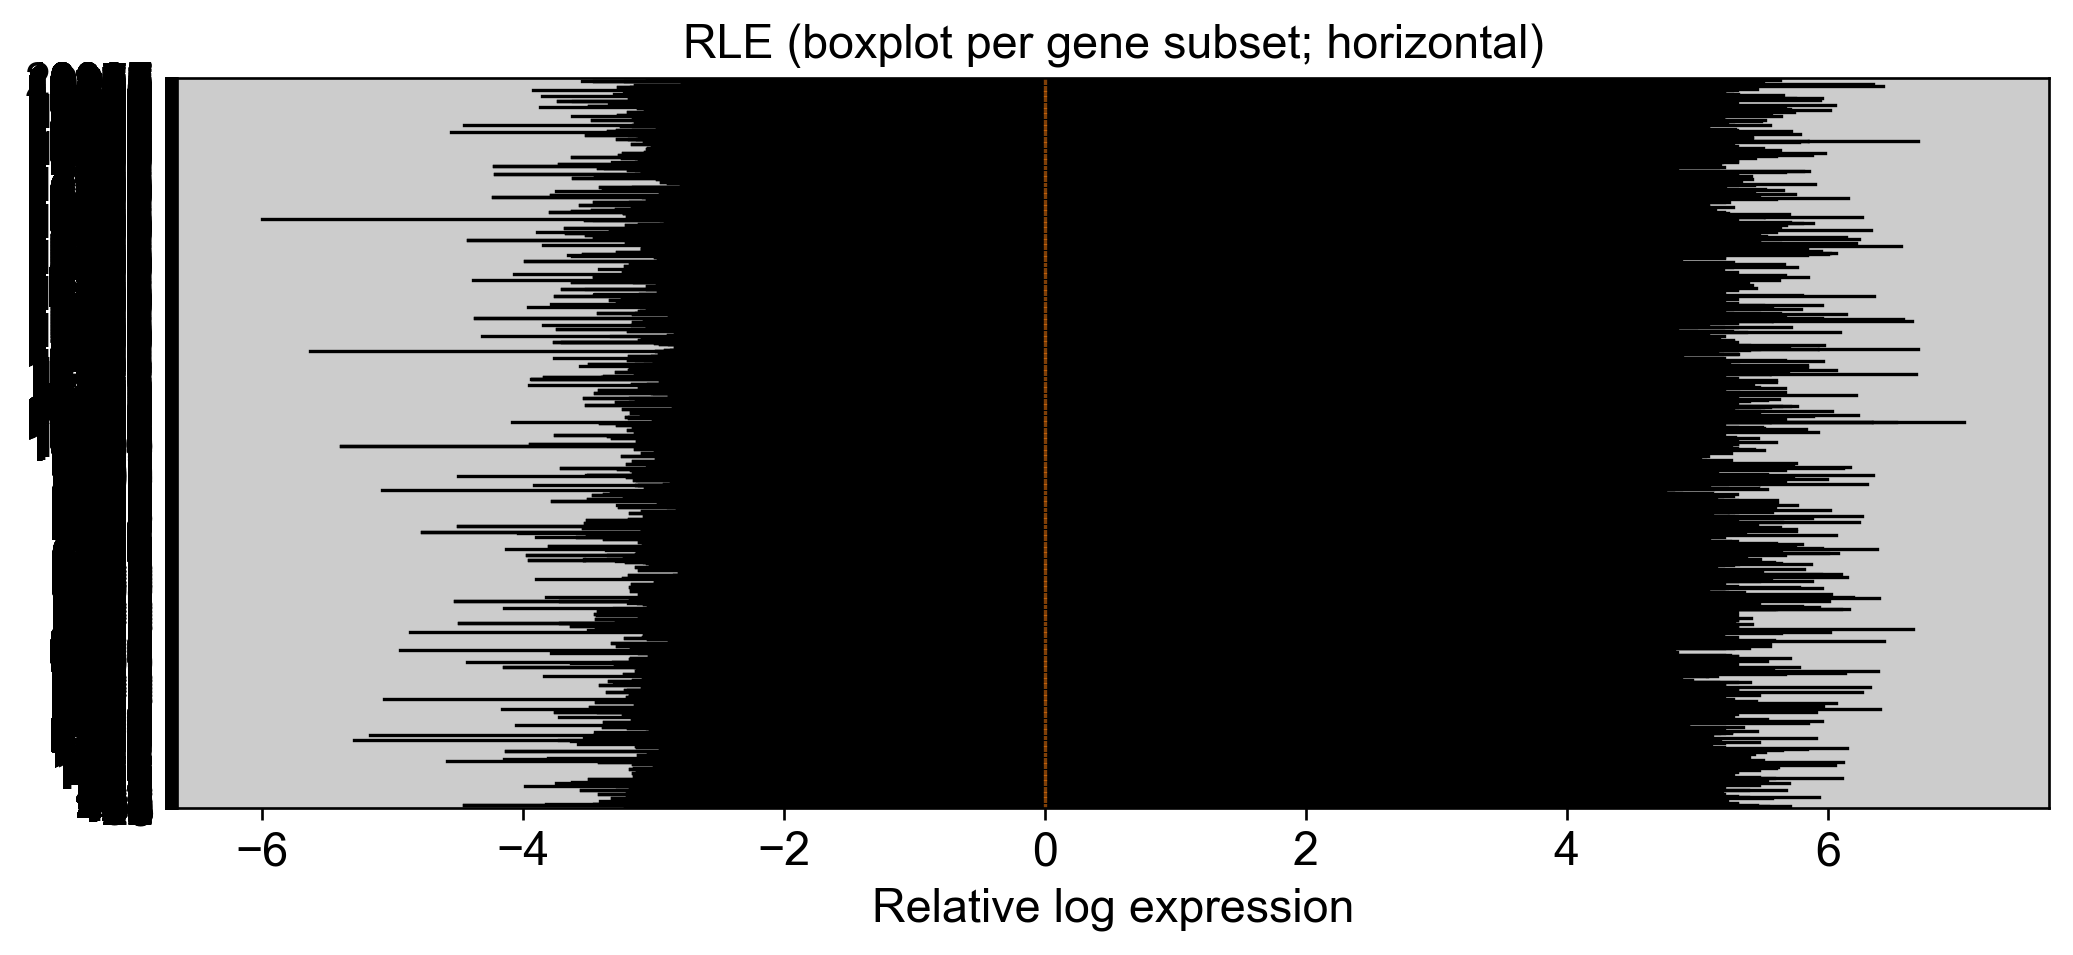

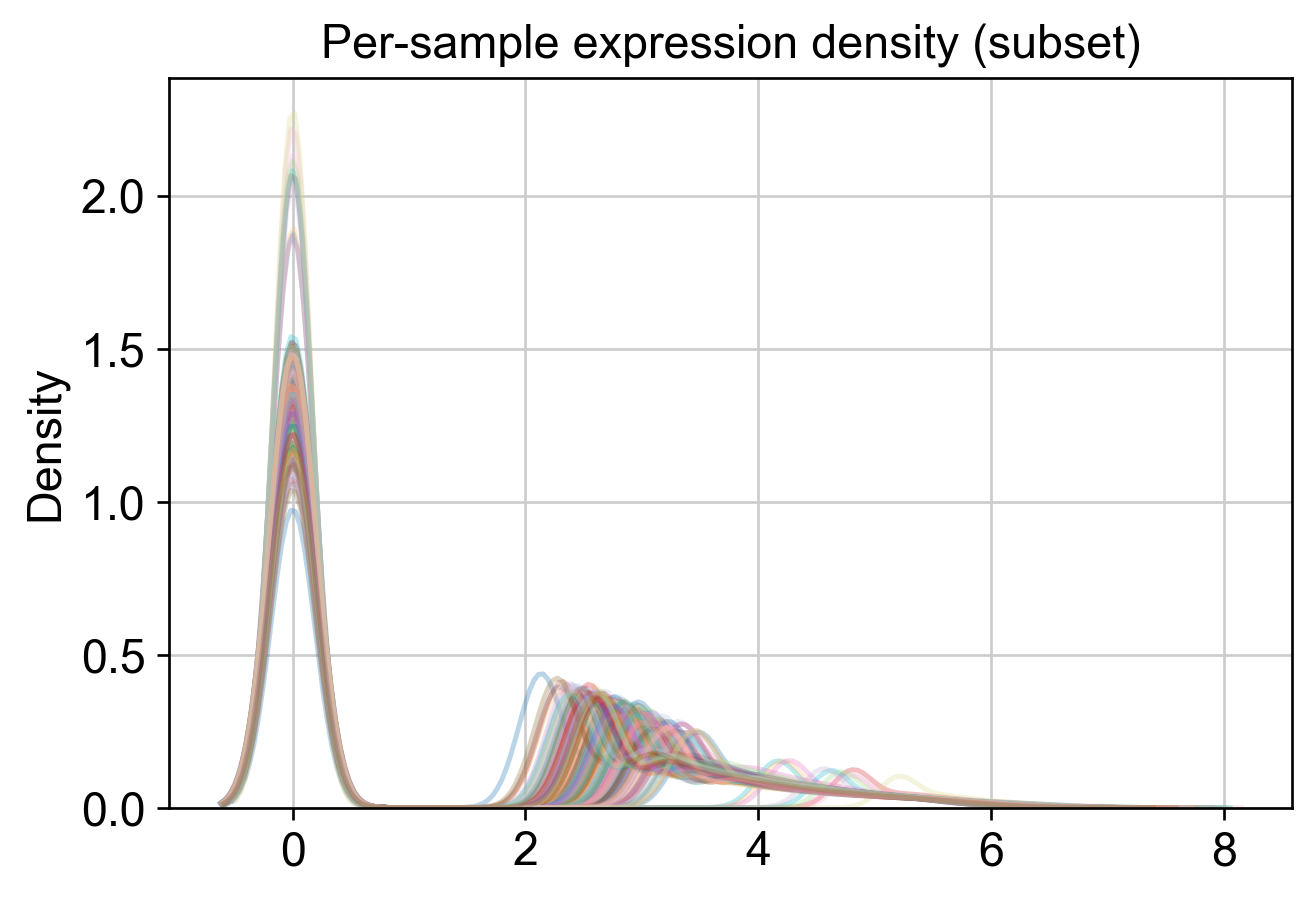

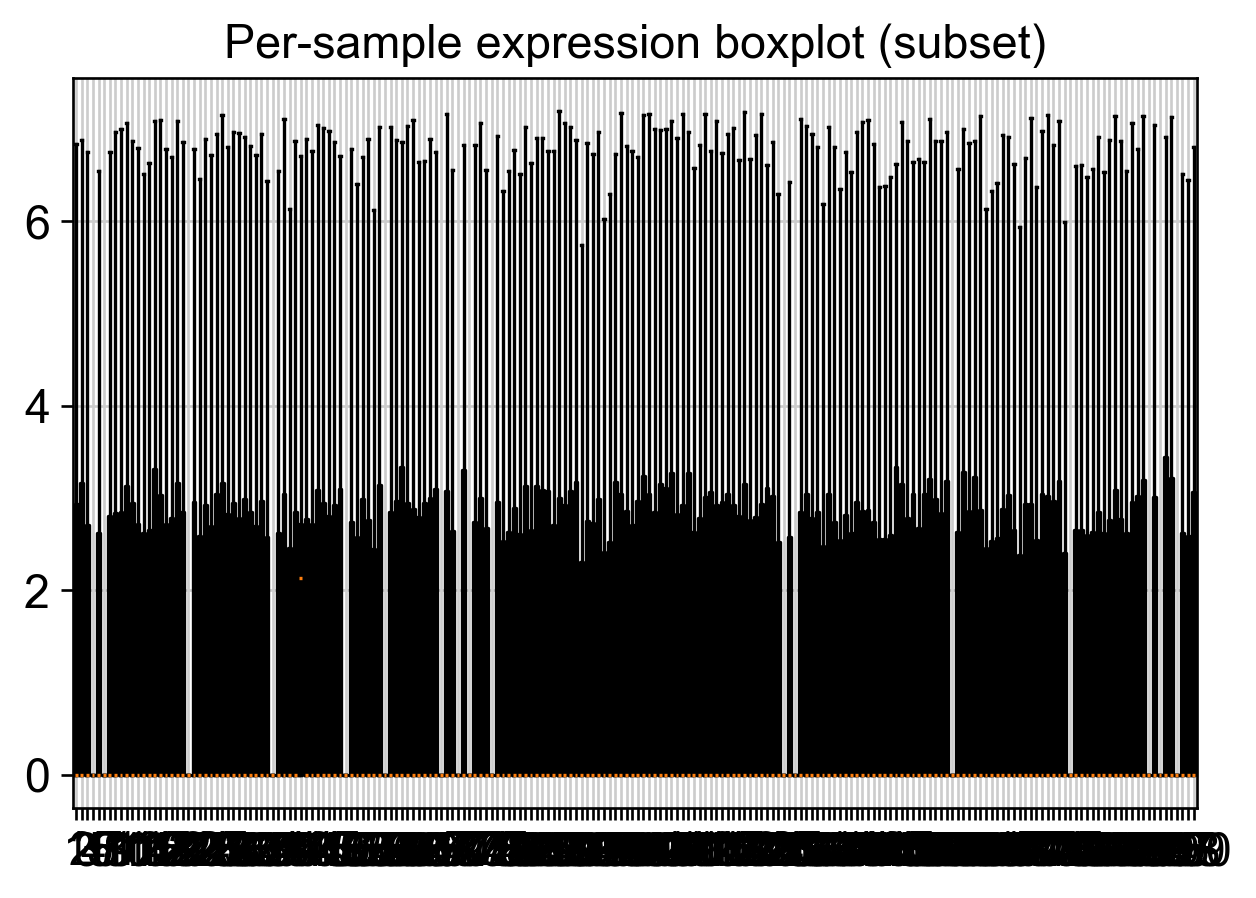

No QC columns available among: ('n_genes_by_counts', 'total_counts', 'pct_counts_mt')
— RLE/density/box on cov


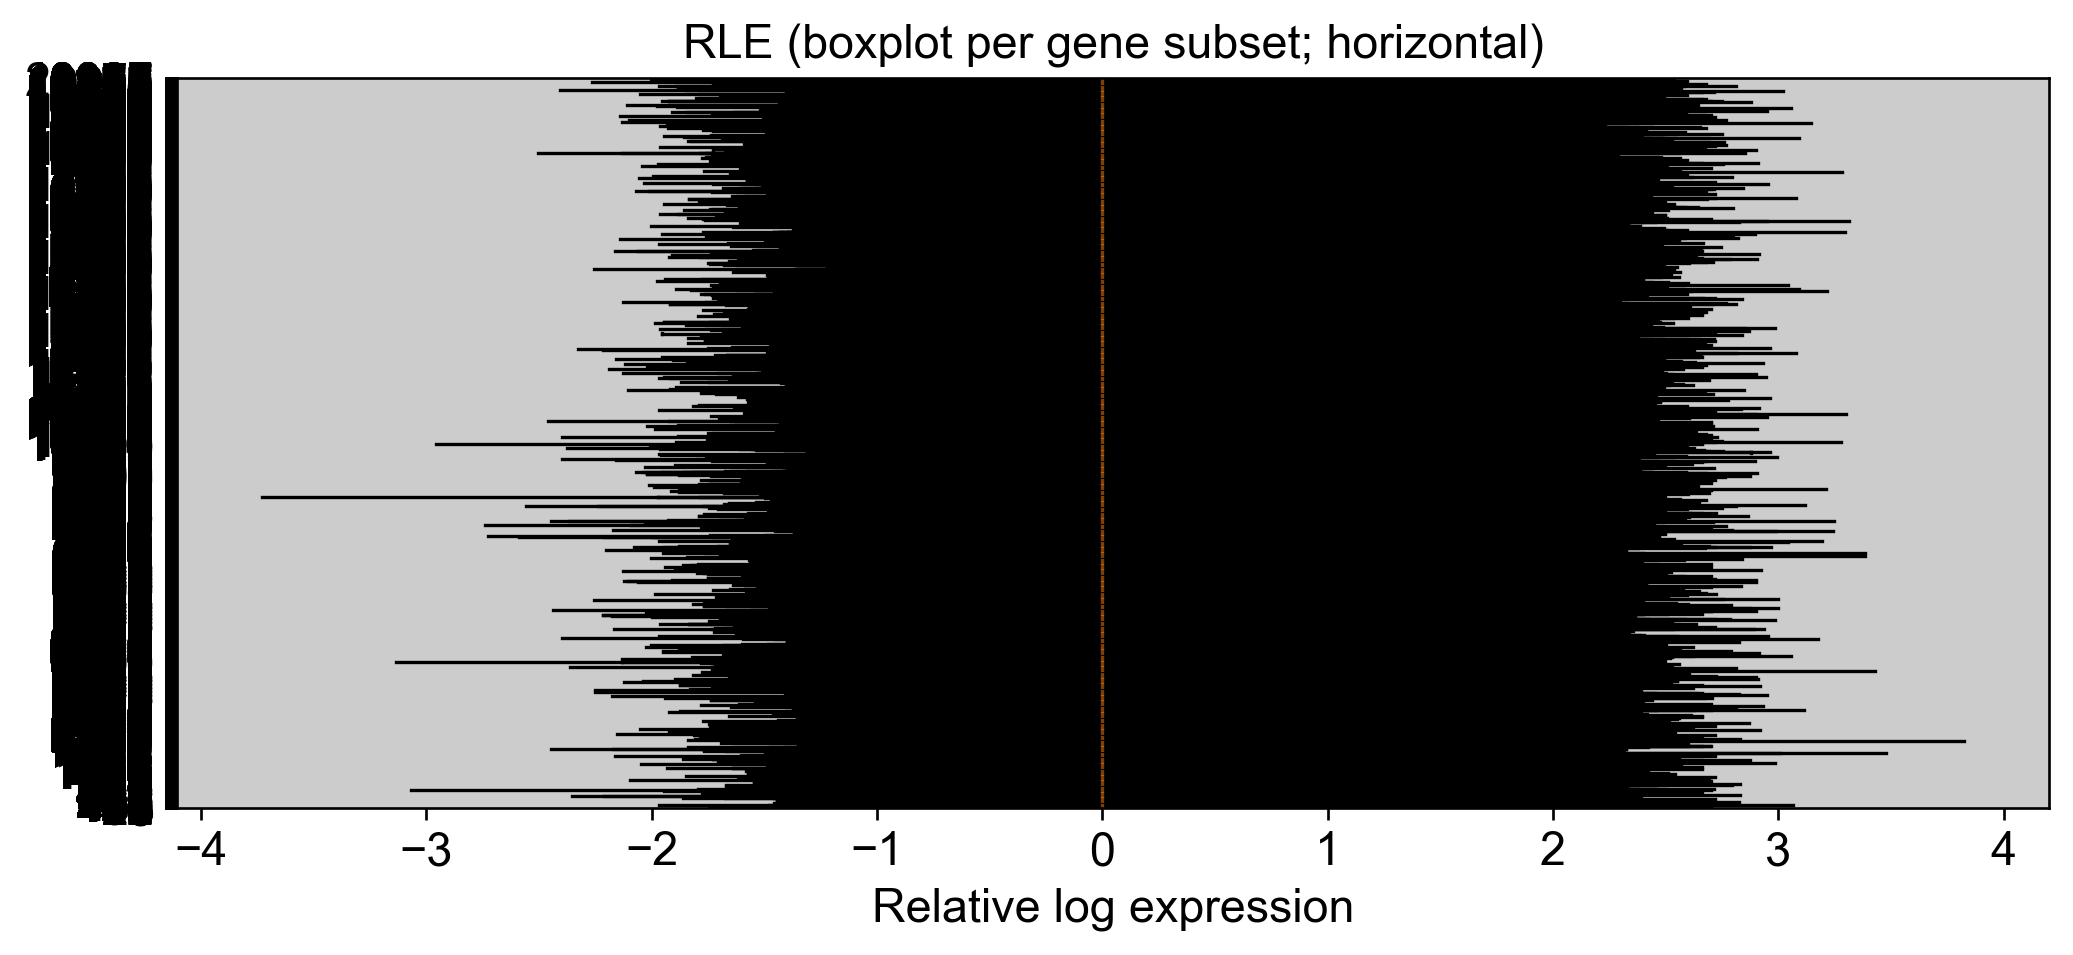

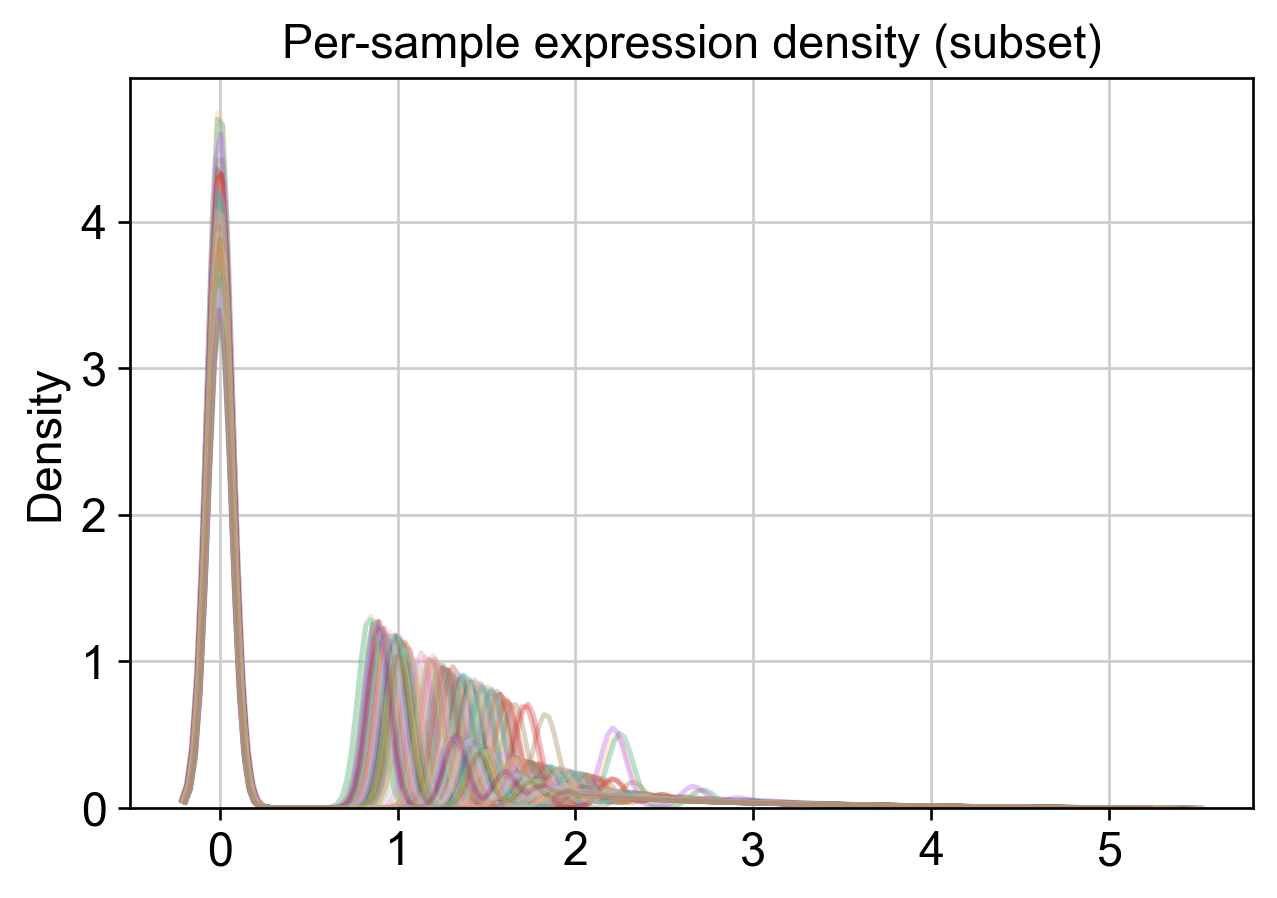

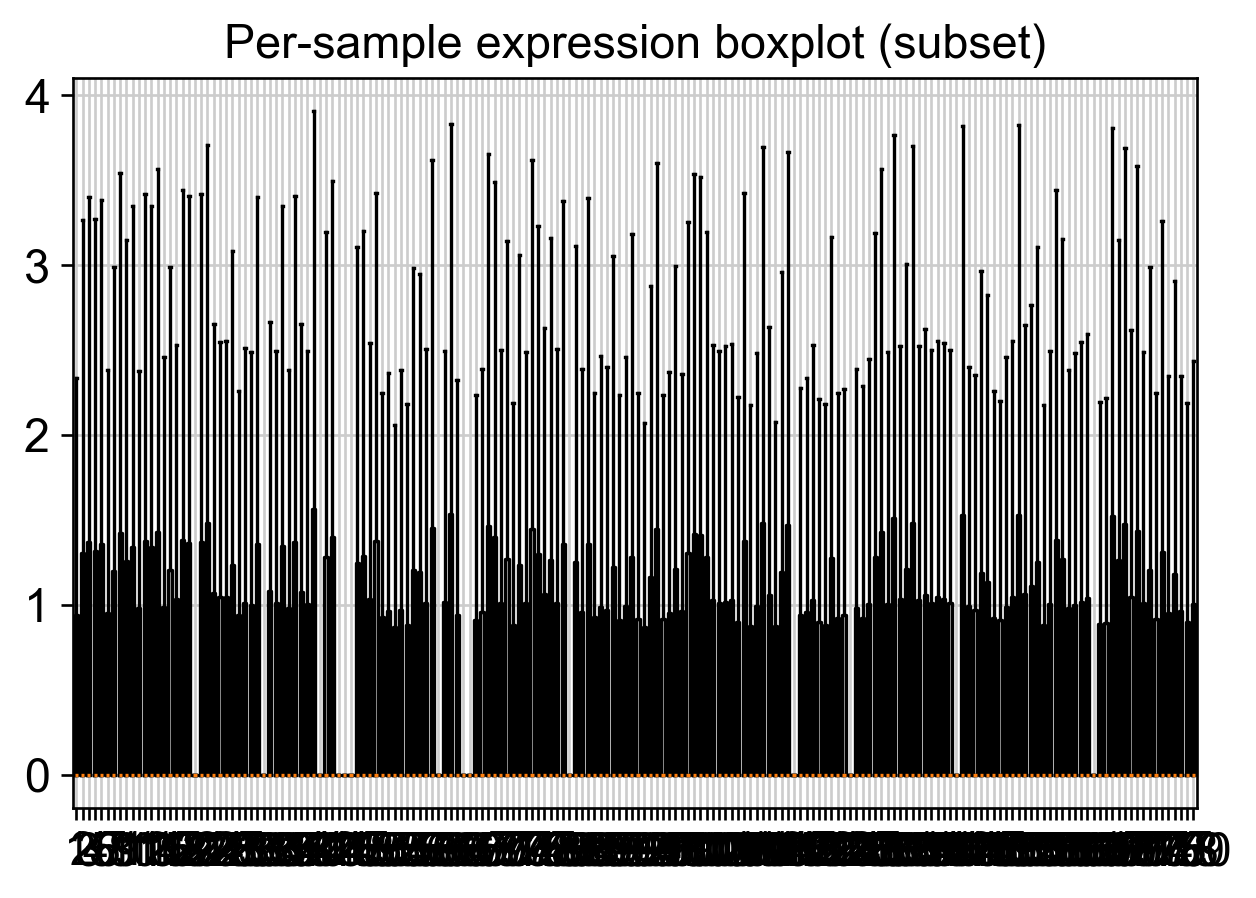

No QC columns available among: ('n_genes_by_counts', 'total_counts', 'pct_counts_mt')


In [ ]:
# --- RLE & expression density/box, and QC clustering heatmap ---

import matplotlib.pyplot as plt
import seaborn as sns

def rle_plot(adata, max_genes=20000):
    """
    Relative Log Expression (RLE):
    For each gene, subtract the across-sample median (on log-scale), then plot per-sample distribution.
    Note: on large single-cell data, this can be heavy; consider subsampling cells or genes.
    """
    X = adata.X.toarray() if sps.issparse(adata.X) else adata.X.copy()
    # Use log1p-transformed if available; otherwise do a quick log1p CPM
    if 'X_pca' not in adata.obsm_keys():
        sc.pp.normalize_total(adata, target_sum=1e6); sc.pp.log1p(adata)  # safe default
        X = adata.X.toarray() if sps.issparse(adata.X) else adata.X.copy()
    # Subset genes if too many
    if X.shape[1] > max_genes:
        idx = np.random.default_rng(0).choice(X.shape[1], size=max_genes, replace=False)
        X = X[:, idx]
    gene_median = np.median(X, axis=0)
    rle = X - gene_median
    # Boxplot by sample/cell
    plt.figure(figsize=(10, 4))
    plt.boxplot(rle, vert=False, showfliers=False)
    plt.title('RLE (boxplot per gene subset; horizontal)')
    plt.xlabel('Relative log expression')
    plt.show()

def density_and_box_per_sample(adata, max_samples=200):
    """Show density and boxplot of library-size-normalized log counts per sample/cell."""
    X = adata.X.toarray() if sps.issparse(adata.X) else adata.X
    n = min(adata.n_obs, max_samples)
    idx = np.random.default_rng(1).choice(adata.n_obs, size=n, replace=False)
    vals = X[idx]
    plt.figure()
    for i in range(n):
        sns.kdeplot(vals[i], bw_adjust=1.0, alpha=0.3)
    plt.title('Per-sample expression density (subset)')
    plt.show()
    plt.figure(figsize=(6,4))
    plt.boxplot([vals[i] for i in range(n)], showfliers=False)
    plt.title('Per-sample expression boxplot (subset)')
    plt.show()

def qc_heatmap_hclust(adata, keys=('n_genes_by_counts','total_counts','pct_counts_mt'), zscore=True):
    """
    Hierarchical clustering heatmap on QC metrics across samples/cells.
    Add mt% if gene names contain MT- prefix and the column is missing.
    """
    # Fill QC columns if missing
    if 'pct_counts_mt' not in adata.obs.columns:
        # rough mt detection by gene name prefix
        mt_mask = adata.var_names.str.upper().str.startswith(('MT-','MT_'))
        if mt_mask.any():
            sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    df = adata.obs[list(k for k in keys if k in adata.obs.columns)].copy()
    if df.shape[1] == 0:
        print('No QC columns available among:', keys); return
    if zscore:
        df = (df - df.mean())/df.std(ddof=0)
    sns.clustermap(df.fillna(0), cmap='vlag', figsize=(7,6))
    plt.show()

# Quick run on your two objects:
print('— RLE/density/box on neu')
rle_plot(neu_adata_proc); density_and_box_per_sample(neu_adata_proc); qc_heatmap_hclust(neu_adata_proc)
print('— RLE/density/box on cov')
rle_plot(cov_adata_proc); density_and_box_per_sample(cov_adata_proc); qc_heatmap_hclust(cov_adata_proc)


In [ ]:
# =========================
# Add: compact summary table (no saving)
# =========================
import pandas as pd
import numpy as np

# Heuristics to annotate kind of label (technical vs condition)
_CONDITION_KEYS = {
    "diagnosis","treatment","cohort","vaccine","naat_result","timepoint",
    "status","disease","condition","group","Participant_number","sex","age"
}
_TECH_HINTS = [
    "Center","Sequencer","Assay","Sample_type","Lab_","library","Library","kit","Kit",
    "Run","run","lane","Lane","plate","Plate","well","Well",
    "BioProject","BioSample","Experiment","SRA_study","Sample_name","GEO_Accession_exp",
    "source_name","Release_date","create_date","version"
]

def _label_kind(col: str) -> str:
    if any(k.lower() == col.lower() for k in _CONDITION_KEYS):
        return "condition"
    if any(h in col for h in _TECH_HINTS):
        return "technical"
    return "unknown"

def _cardinality_stats(adata, key: str):
    if key not in adata.obs.columns:
        return (np.nan, np.nan)
    s = adata.obs[key].astype(str)
    vc = s.value_counts(dropna=False)
    return int(vc.shape[0]), int(vc.min())

def build_summary_table(scan_dict: dict, adata, dataset_name: str) -> pd.DataFrame:
    """
    Turn scan results into an easy-to-read table (no file saving).
    Columns:
      dataset, label_key, kind, n_levels, min_per_level,
      predict_acc, silhouette_pca, knn_entropy,
      rank_acc, rank_sil, rank_ent, rank_avg, recommendation
    """
    rows = []
    for key, metrics in scan_dict.items():
        sil = metrics.get('silhouette_pca', np.nan)
        ent = metrics.get('knn_entropy', np.nan)
        acc = metrics.get('predictability_bal_acc', np.nan)
        nlev, min_per_level = _cardinality_stats(adata, key)
        rows.append({
            "dataset": dataset_name,
            "label_key": key,
            "kind": _label_kind(key),
            "n_levels": nlev,
            "min_per_level": min_per_level,
            "predict_acc": acc,
            "silhouette_pca": sil,
            "knn_entropy": ent,
        })
    df = pd.DataFrame(rows)

    # Ranks: higher acc/sil → stronger batch; lower entropy → stronger batch
    df["rank_acc"] = df["predict_acc"].rank(ascending=False, method="min", na_option="bottom")
    df["rank_sil"] = df["silhouette_pca"].rank(ascending=False, method="min", na_option="bottom")
    df["rank_ent"] = df["knn_entropy"].rank(ascending=True,  method="min", na_option="bottom")
    df["rank_avg"] = df[["rank_acc","rank_sil","rank_ent"]].mean(axis=1)

    # Simple recommendation
    def _recommend(row):
        if row["kind"] == "condition":
            return "NOT batch (biological)"
        if np.isnan(row["rank_avg"]):
            return "insufficient data"
        if row["rank_avg"] <= df["rank_avg"].quantile(0.35) and row["min_per_level"] >= 2:
            return "batch_candidate"
        return "weak_or_unclear"
    df["recommendation"] = df.apply(_recommend, axis=1)

    # Sort for readability
    return df.sort_values(["recommendation","rank_avg","kind","label_key"]).reset_index(drop=True)

# ---- build & display tables (after neu_scan/cov_scan are computed) ----
neu_table = build_summary_table(neu_scan, neu_adata_proc, "neutrophil")
cov_table = build_summary_table(cov_scan, cov_adata_proc, "covid")
combined_table = pd.concat([neu_table, cov_table], ignore_index=True)

# If you're in Jupyter, display() shows a nice table
try:
    display(combined_table)
except NameError:
    print(combined_table.head(30))

# (Optional) also peek at top batch candidates per dataset
print("\nTop batch candidates (neutrophil):")
print(neu_table[neu_table["recommendation"]=="batch_candidate"]
      .sort_values("rank_avg").head(10)[["label_key","predict_acc","silhouette_pca","knn_entropy","n_levels"]])

print("\nTop batch candidates (covid):")
print(cov_table[cov_table["recommendation"]=="batch_candidate"]
      .sort_values("rank_avg").head(10)[["label_key","predict_acc","silhouette_pca","knn_entropy","n_levels"]])


dataset                   label_key       kind  n_levels  \
0   neutrophil                      cohort  condition         2   
1   neutrophil                   treatment  condition         2   
2   neutrophil                   diagnosis  condition         4   
3   neutrophil                         sex  condition         2   
4   neutrophil                  BioProject  technical         2   
5   neutrophil             BioProject_top8  technical         2   
6   neutrophil                   SRA_study  technical         2   
7   neutrophil              SRA_study_top8  technical         2   
8   neutrophil                pseudo_batch    unknown        20   
9   neutrophil  QC_mapping_ratio_bacterial    unknown         3   
10  neutrophil             Experiment_top8  technical         9   
11  neutrophil                 create_date  technical        14   
12       covid                         sex  condition         2   
13       covid                 naat_result  condition         3   
14       covid                     vaccine  condition         2   
15       covid                   timepoint  condition         3   
16       covid                pseudo_batch    unknown         5   
17       covid             Avg_spot_length    unknown         5   
18       covid             Experiment_top8  technical         9   
19       covid                 create_date  technical         3   
20       covid      QC_mapping_ratio_viral    unknown         4   

    min_per_level  predict_acc  silhouette_pca   knn_entropy  rank_acc  \
0             205     1.000000        0.558201 -1.000089e-12       1.0   
1             205     1.000000        0.558201 -1.000089e-12       1.0   
2              65     0.538846       -0.045167  7.182266e-01       9.0   
3             214     0.500180       -0.002384  6.635965e-01      11.0   
4             205     1.000000        0.558201 -1.000089e-12       1.0   
5             205     1.000000        0.558201 -1.000089e-12       1.0   
6             205     1.000000        0.558201 -1.000089e-12       1.0   
7             205     1.000000        0.558201 -1.000089e-12       1.0   
8              16     0.987500        0.403266  6.231659e-02       7.0   
9              31     0.603287        0.048312  4.621574e-01       8.0   
10              1     0.412121       -0.490714  6.397299e-02      12.0   
11              3     0.502080       -0.091539  9.042728e-01      10.0   
12             54     0.640212        0.020586  5.682454e-01       4.0   
13             19     0.750858       -0.046446  4.243181e-01       2.0   
14             80     0.666250        0.003079  6.541080e-01       3.0   
15             29     0.611123       -0.012115  9.121400e-01       6.0   
16             24     0.954808        0.255035  2.392518e-01       1.0   
17              1     0.629210       -0.026830  5.991556e-01       5.0   
18              1     0.397143       -0.380433  1.545546e-01       9.0   
19             21     0.568365       -0.064775  6.181941e-01       7.0   
20              3     0.473443       -0.085331  6.980893e-01       8.0   

    rank_sil  rank_ent   rank_avg          recommendation  
0        1.0       1.0   1.000000  NOT batch (biological)  
1        1.0       1.0   1.000000  NOT batch (biological)  
2       10.0      11.0  10.000000  NOT batch (biological)  
3        9.0      10.0  10.000000  NOT batch (biological)  
4        1.0       1.0   1.000000         batch_candidate  
5        1.0       1.0   1.000000         batch_candidate  
6        1.0       1.0   1.000000         batch_candidate  
7        1.0       1.0   1.000000         batch_candidate  
8        7.0       7.0   7.000000         weak_or_unclear  
9        8.0       9.0   8.333333         weak_or_unclear  
10      12.0       8.0  10.666667         weak_or_unclear  
11      11.0      12.0  11.000000         weak_or_unclear  
12       2.0       4.0   3.333333  NOT batch (biological)  
13       6.0       3.0   3.666667  NOT batch (biological)  
14 


Top batch candidates (neutrophil):
         label_key  predict_acc  silhouette_pca   knn_entropy  n_levels
4       BioProject          1.0        0.558201 -1.000089e-12         2
5  BioProject_top8          1.0        0.558201 -1.000089e-12         2
6        SRA_study          1.0        0.558201 -1.000089e-12         2
7   SRA_study_top8          1.0        0.558201 -1.000089e-12         2

Top batch candidates (covid):
      label_key  predict_acc  silhouette_pca  knn_entropy  n_levels
4  pseudo_batch     0.954808        0.255035     0.239252         5


[neu] DE using BioProject: PRJNA717025 vs PRJNA717018


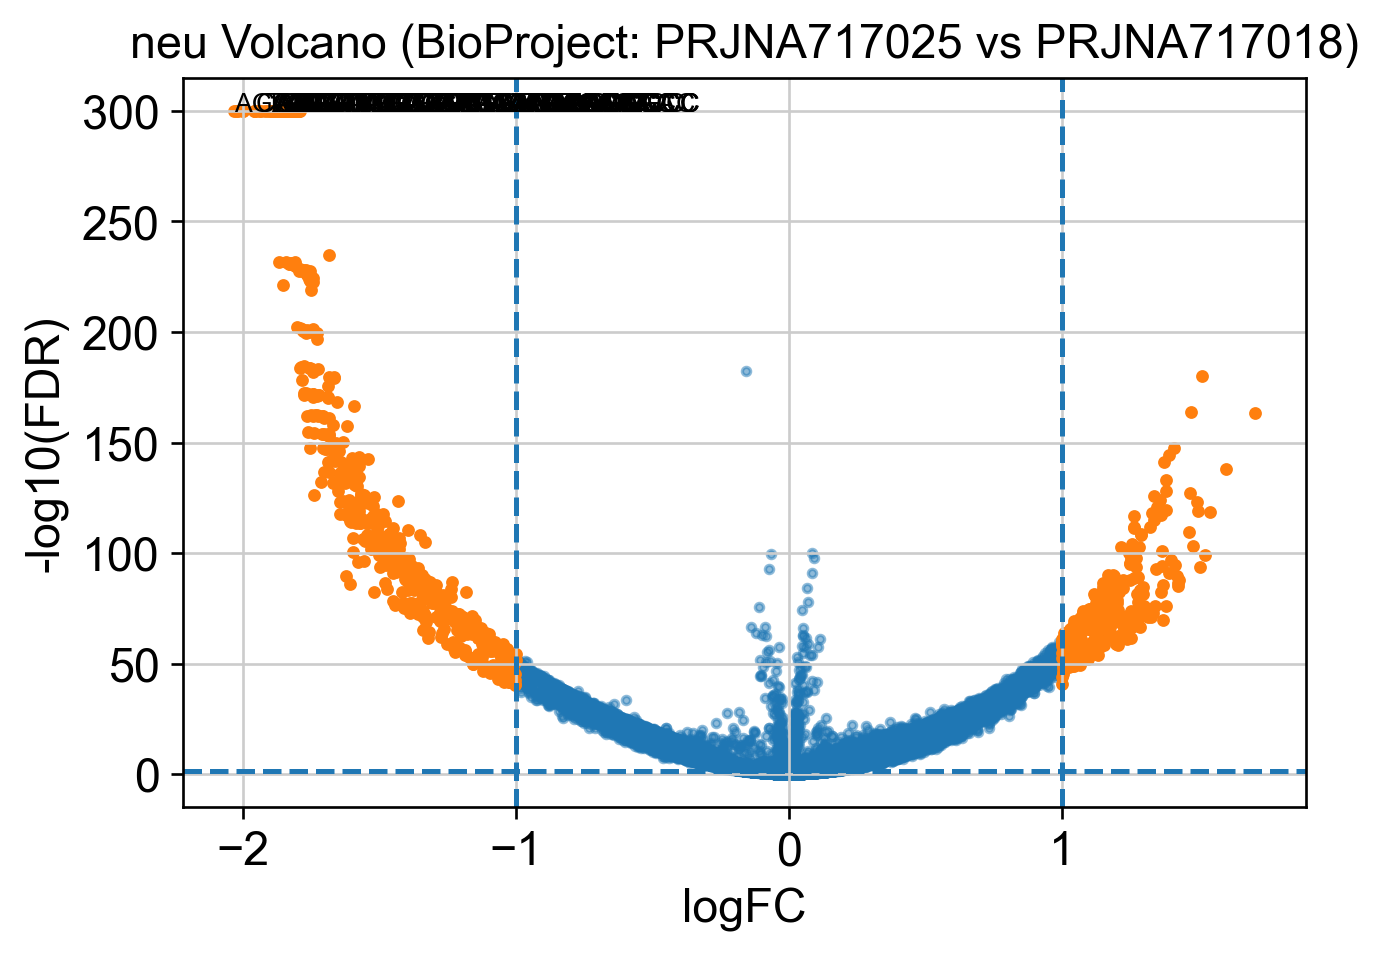

[cov] DE using pseudo_batch: 0 vs 1


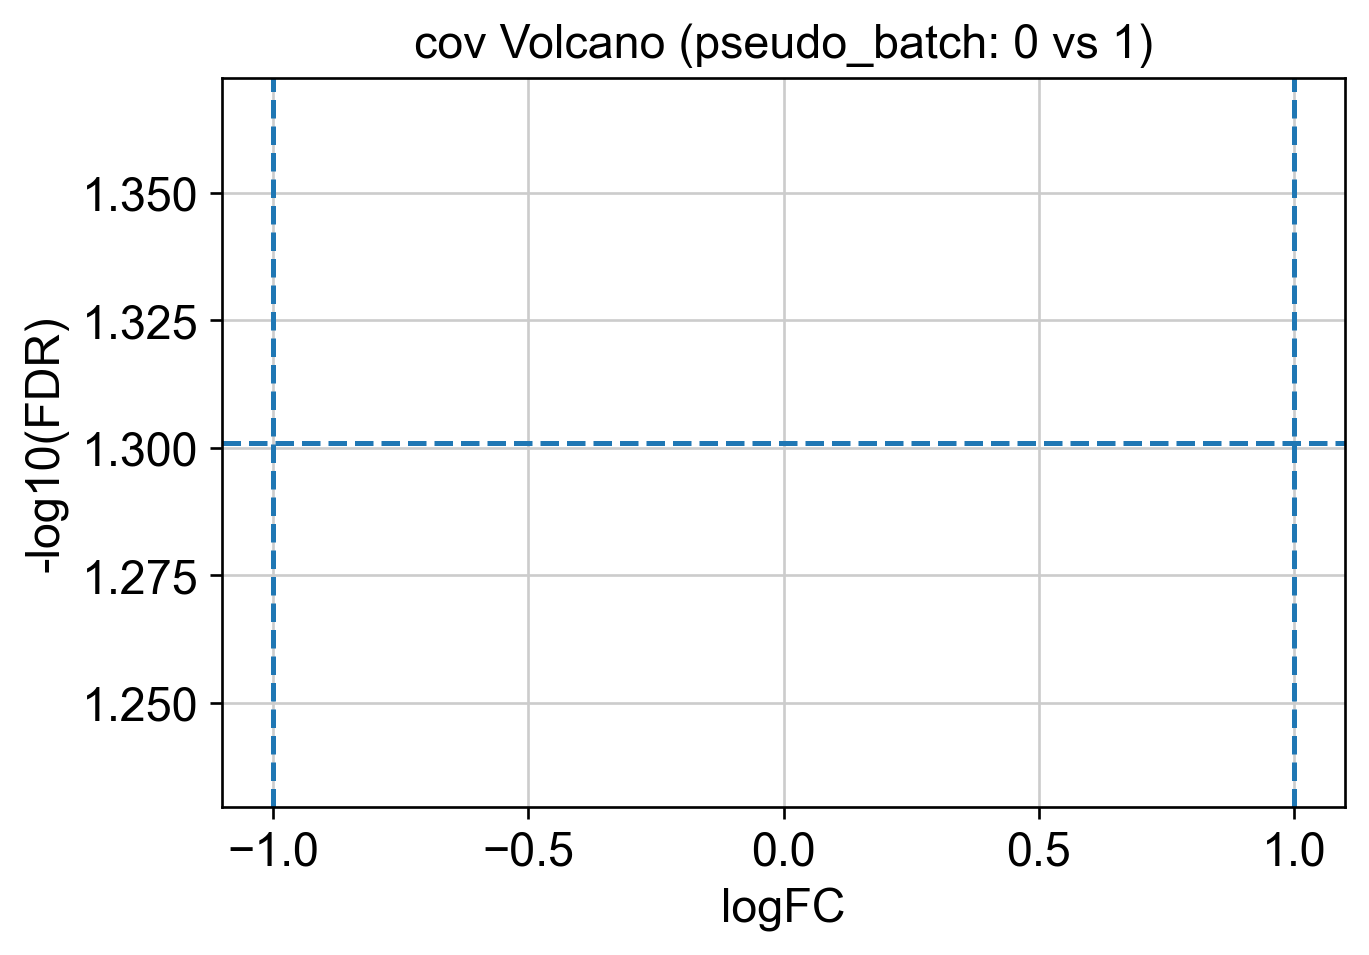

In [ ]:
# --- Differential expression and volcano plots ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind

def de_bulk_two_group(adata, group_key, g1, g2, log1p=True):
    """
    Simple bulk-like DE: two-sample t-test per gene with optional log1p.
    Returns DataFrame with logFC, pval, padj.
    """
    X = adata.X.toarray() if sps.issparse(adata.X) else adata.X
    if log1p:
        X = np.log1p(X)
    idx1 = (adata.obs[group_key] == g1).values
    idx2 = (adata.obs[group_key] == g2).values
    x1, x2 = X[idx1], X[idx2]
    # Means and logFC
    mean1 = x1.mean(axis=0); mean2 = x2.mean(axis=0)
    logfc = (mean1 - mean2)
    # T-test per gene
    t, p = ttest_ind(x1, x2, axis=0, equal_var=False, nan_policy='omit')
    padj = multipletests(p, method='fdr_bh')[1]
    df = pd.DataFrame({'gene': adata.var_names, 'logFC': logfc, 'pval': p, 'padj': padj})
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    return df.sort_values('padj')

def volcano(df, alpha=0.05, lfc_thr=1.0, title='Volcano', label_top=10):
    """Volcano plot from DE results DataFrame (columns: gene, logFC, padj)."""
    x = df['logFC'].values
    y = -np.log10(df['padj'].values + 1e-300)
    sig = (df['padj'] < alpha) & (np.abs(df['logFC']) >= lfc_thr)
    plt.figure()
    plt.scatter(x, y, s=6, alpha=0.5)
    plt.scatter(x[sig], y[sig], s=8)
    plt.axvline(+lfc_thr, ls='--'); plt.axvline(-lfc_thr, ls='--'); plt.axhline(-np.log10(alpha), ls='--')
    plt.title(title); plt.xlabel('logFC'); plt.ylabel('-log10(FDR)')
    # Label top genes by FDR
    top = df.sort_values('padj').head(label_top)
    for _, r in top.iterrows():
        plt.text(r['logFC'], -np.log10(r['padj']+1e-300), r['gene'], fontsize=8)
    plt.show()

def choose_group_pairs(adata, label_key):
    """Pick the two largest groups for demonstration."""
    sizes = adata.obs[label_key].value_counts()
    if len(sizes) < 2:
        print(f'Need at least 2 groups in {label_key} for DE.'); return None
    return tuple(sizes.index[:2])

# Use best candidate (or pseudo_batch) for each dataset
def best_label_from_scan(scan_res: Dict[str, Dict]) -> Optional[str]:
    if not scan_res: return None
    return sorted(scan_res.items(), key=lambda kv: kv[1].get('predictability_bal_acc', np.nan), reverse=True)[0][0]

for tag, ad, scan in [('neu', neu_adata_proc, neu_scan), ('cov', cov_adata_proc, cov_scan)]:
    best = best_label_from_scan(scan) or 'pseudo_batch'
    if best not in ad.obs.columns:
        print(f'[{tag}] No label available for DE.'); continue
    pair = choose_group_pairs(ad, best)
    if pair is None: 
        continue
    g1, g2 = pair
    print(f'[{tag}] DE using {best}: {g1} vs {g2}')
    # If many cells (scRNA-seq), Scanpy's rank_genes_groups is convenient
    if ad.n_obs > 500:
        sc.tl.rank_genes_groups(ad, groupby=best, method='t-test', use_raw=False)
        # Build volcano for the chosen contrast (approximate by extracting stats)
        rg = sc.get.rank_genes_groups_df(ad, group=g1)
        if 'logfoldchanges' in rg.columns:
            rg = rg.rename(columns={'logfoldchanges':'logFC','pvals_adj':'padj','names':'gene'})
        volcano(rg[['gene','logFC','padj']].dropna(), title=f'{tag} Volcano ({best}: {g1} vs rest)', label_top=15)
    else:
        # Bulk-like two-group t-test
        df = de_bulk_two_group(ad, best, g1, g2, log1p=True)
        volcano(df, title=f'{tag} Volcano ({best}: {g1} vs {g2})', label_top=15)
